In [8]:
import os, sys
import glob
import logging
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as pywcs

os.environ['CRDS_PATH'] = os.path.expanduser('/lustre/JDAP/home/jdap02/crds')
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
import jwst

# grizli stuff
import grizli
from grizli import utils, prep, jwst_utils, multifit, fitting, model
from grizli.pipeline import auto_script

utils.set_warnings()

print('Grizli version: ', grizli.__version__)
print('jwst pipeline version: ', jwst.__version__)


Grizli version:  1.9
jwst pipeline version:  1.14.0


In [9]:
# set home path
HOME_PATH = '/lustre/JDAP/home/jdap02/start_from_s1/'
field_root = 'glass-2022data'    # the root directory for this data reduction

# create directory structure
for dir in [os.path.join(HOME_PATH, field_root),
            os.path.join(HOME_PATH, field_root, 'RAW'),
            os.path.join(HOME_PATH, field_root, 'Prep'),
            os.path.join(HOME_PATH, field_root, 'Extractions')]:
    if not os.path.exists(dir):
        os.mkdir(dir)
        os.system('chmod ugoa+rwx {0}'.format(dir))


In [3]:
# renaming the keywords of NIRISS exposures to the convention of HST WFC3
os.chdir(os.path.join(HOME_PATH, field_root, 'RAW'))

# files = glob.glob('*rate.fits*')
# files.sort()
# for file in files:
#     _ = jwst_utils.set_jwst_to_hst_keywords(file, reset=True)

In [14]:
# create a log sheet showing basic info of exposure files
files = glob.glob('../RAW/*rate.fits*')
files.sort()
info = utils.get_flt_info(files=files)
info.write(
            os.path.join("../files.info"),
            format="ascii.commented_header",
            overwrite=True,
        )

In [4]:
# Use the CONTEXT that was used when making the calibrated images above. relevant for geometric distortion / WCS

im = pyfits.open(glob.glob('../RAW/*rate.fits*')[0])

print('CRDS_CONTEXT: ', im[0].header['CRDS_CTX'])

os.environ['CRDS_CONTEXT'] = im[0].header['CRDS_CTX']

CRDS_CONTEXT:  jwst_1241.pmap


# Parse Visits <a class="anchor" id="parse-visits"></a>
For NIRISS, this identifies which exposures are direct/grism images, and groups them into associations for processing. This works a bit differently for NIRISS than with HST. For NIRISS, we extract 'FILTER' which is the grism (GR150C or GR150R) and 'PUPIL' which is the direct filter (e.g, F150W) from the header, and match the grism images based on the direct filter. 

In [10]:
# first set up pipeline parameters
os.chdir(os.path.join(HOME_PATH, field_root))
kwargs = auto_script.get_yml_parameters()

# Parse visit associations
os.chdir(os.path.join(HOME_PATH, field_root, 'Prep'))
kwargs['parse_visits_args']['combine_same_pa'] = False
kwargs['parse_visits_args']['max_dt'] = 1e9

visits, all_groups, info = grizli.pipeline.auto_script.parse_visits(field_root=field_root,
                                                    **kwargs['parse_visits_args'])


sh: aws: command not found


# (2024-06-27 05:22:45.373)

auto_script.parse_visits(**{'files': [], 'field_root': 'glass-2022data', 'RAW_PATH': '../RAW', 'use_visit': True, 'combine_same_pa': False, 'combine_minexp': 2, 'is_dash': False, 'filters': ['F410M', 'F467M', 'F547M', 'F550M', 'F621M', 'F689M', 'F763M', 'F845M', 'F200LP', 'F350LP', 'F435W', 'F438W', 'F439W', 'F450W', 'F475W', 'F475X', 'F555W', 'F569W', 'F600LP', 'F606W', 'F622W', 'F625W', 'F675W', 'F702W', 'F775W', 'F791W', 'F814W', 'F850LP', 'G800L', 'F098M', 'F127M', 'F139M', 'F153M', 'F105W', 'F110W', 'F125W', 'F140W', 'F160W', 'G102', 'G141', 'F070W', 'F090W', 'F1000W', 'F1130W', 'F115W', 'F1280W', 'F140M', 'F1500W', 'F150W', 'F150W2', 'F158M', 'F162M', 'F164N', 'F1800W', 'F182M', 'F187N', 'F200W', 'F2100W', 'F210M', 'F212N', 'F250M', 'F2550W', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F380M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M', 'F560W', 'F770W', 'GR150C', 'GR150R', 'GRISMR', 'GRISMC'], 'max_dt'

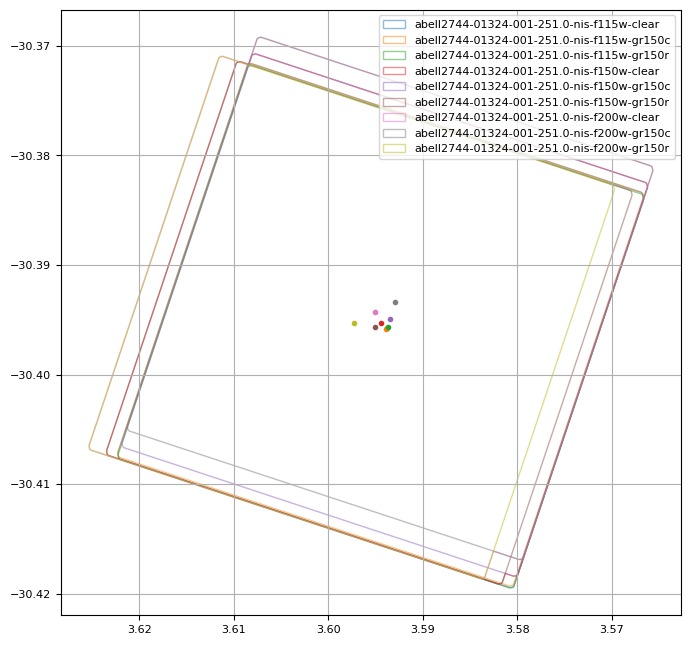

In [16]:
# Preview what will be processed
plt.rcParams.update({'font.size': 8})

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
colors += colors
colors += ['c', 'm']

fig, ax = plt.subplots(1,1,figsize=(8,8))

for i, v in enumerate(visits):
    sr = utils.SRegion(v['footprint'])

    ax.scatter(*sr.centroid[0], marker='.', c=colors[i])
    
    for patch in sr.patch(ec=colors[i], fc='None', alpha=0.5, label=v['product']):
        ax.add_patch(patch)

ax.set_aspect(1./np.cos(ax.get_ylim()[0]/180*np.pi)) # square with cos(dec)
ax.set_xlim(ax.get_xlim()[::-1])
ax.legend()
ax.grid()

# Run the preprocessing scripts

The processing does the following:

1. CR rejection
2. Simple shifts alignment between exposures
3. Global astrometry w.r.t some reference
 - Here the scripts find reference sources in the LegacySurveys DR9 catalog
 - The first visit is aligned to the external reference
 - Then for subsequent "visits", 
   the (globally aligned) first *NIRISS* image itself will be used as the astrometric reference
4. Final background subtraction with a SourceExtractor-like median background

Reference astrometry:

- `preprocess_args['master_radec'] = '[some_radec_file]'`: All visits will be aligned to this 
- `preprocess_args['parent_radec'] = '[some_radec_file]'`: First visit will be aligned to this, subsequent visits that overlap will be aligned to each other.
- `preprocess_args['master_radec'] = None`: Query all-sky catalogs (LS DR9, PS1, GAIA, etc) for first visit.  Subsequent visits that overlap will be aligned to each other.

In [6]:
# Parameter lists
visit_prep_args = kwargs['visit_prep_args']
preprocess_args = kwargs['preprocess_args']

# Maximum shift for "tweakshifts" relative alignment
IS_PARALLEL = False

tweak_max_dist = (5 if IS_PARALLEL else 1)
if 'tweak_max_dist' not in visit_prep_args:
    visit_prep_args['tweak_max_dist'] = tweak_max_dist

# Fit and subtract a SExtractor-like background to each visit
visit_prep_args['imaging_bkg_params']  = {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 
                                          'pixel_scale': 0.1, 'get_median': False}

# Alignment reference catalogs, searched in this order
visit_prep_args['reference_catalogs'] = ['LS_DR9', 'PS1','GAIA','SDSS','WISE']

#####################
### Alignment & mosaics   
os.chdir(os.path.join(HOME_PATH, field_root, 'Prep'))

# This script will do all the preprocessing of the grism *and* imaging visits 
auto_script.preprocess(field_root=field_root, HOME_PATH=HOME_PATH,
                       visit_prep_args=visit_prep_args, **preprocess_args)   

# (2024-06-26 16:46:07.996)

auto_script.preprocess(**{'field_root': 'glass-2022data', 'HOME_PATH': '/lustre/JDAP/home/jdap02/start_from_s1/', 'PERSIST_PATH': None, 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': None, 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 24, 0.05], 'align_assume_close': False, 'align_transform': None, 'align_ref_border': 100, 'align_guess': None, 'max_err_percentile': 99, 'align_min_flux_radius': 1.0, 'catalog_mask_pad': 0.05, 'match_catalog_density': False, 'skymethod': 'localmin', 'drizzle_params': {}, 'single_image_CRs': True, 'run_tweak_align': True, 'tweak_threshold': 3.0, 'tweak_fit_order': -1, 'tweak_max_dist': 100, 'tweak_n_min': 10, 'tweak_ref_exp': 0, 'tweak_mosaic_iters': 2, 'align_simple': False,

2024-06-26 23:50:19,631 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:50:19,632 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:50:19,633 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_02101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:50:27.941)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_02101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_04101_00001_nis_rate.fit

2024-06-26 23:50:29,434 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:50:29,435 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:50:29,435 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_04101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:50:33.701)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_04101_00002_nis_rate.fit

2024-06-26 23:50:35,169 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:50:35,170 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:50:35,171 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_04101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:50:39.471)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_04101_00003_nis_rate.fit

2024-06-26 23:50:43,374 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:50:43,374 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:50:43,375 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_04101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:50:47.655)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_04101_00004_nis_rate.fit

2024-06-26 23:50:49,212 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:50:49,213 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:50:49,214 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_04101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:50:53.498)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00004_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_06101_00001_nis_rate.fit

2024-06-26 23:50:54,951 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:50:54,952 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:50:54,952 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_06101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:50:59.280)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_06101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_06101_00002_nis_rate.fit

2024-06-26 23:51:00,860 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:51:00,861 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:51:00,861 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_06101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:51:05.153)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_06101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_06101_00003_nis_rate.fit

2024-06-26 23:51:06,761 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:51:06,762 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:51:06,763 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_06101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:51:11.226)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_06101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_05101_00001_nis_rate.fit

2024-06-26 23:51:24,475 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:51:24,476 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:51:24,476 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_05101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_05101_00002_nis_rate.fits -> jw01324001001_05101_00002_nis_rate.fits 
# (2024-06-26 16:51:29.490)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_05101_00002_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

2024-06-26 23:51:30,575 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:51:30,576 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:51:30,576 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_05101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_05101_00003_nis_rate.fits -> jw01324001001_05101_00003_nis_rate.fits 
# (2024-06-26 16:51:35.600)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_05101_00003_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

2024-06-26 23:51:36,676 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:51:36,677 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:51:36,677 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_05101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_05101_00004_nis_rate.fits -> jw01324001001_05101_00004_nis_rate.fits 
# (2024-06-26 16:51:41.434)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_05101_00004_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

2024-06-26 23:51:42,482 - stpipe - WARNING - /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2024-06-26 23:51:42,483 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2024-06-26 23:51:42,483 - stpipe - WARNING - 


exposure_oneoverf_correction: jw01324001001_05101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:51:46.733)

prep.mask_snowballs(**{'visit': {'files': ['jw01324001001_02101_00001_nis_rate.fits', 'jw01324001001_04101_00001_nis_rate.fits', 'jw01324001001_04101_00002_nis_rate.fits', 'jw01324001001_04101_00003_nis_rate.fits', 'jw01324001001_04101_00004_nis_rate.fits', 'jw01324001001_06101_00001_nis_rate.fits', 'jw01324001001_06101_00002_nis

2024-06-26 23:54:27,137 - stpipe - WARNING - Static mask for file 'jw01324001001_02101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-26 23:54:27,179 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-26 23:54:27,214 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-26 23:54:27,252 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00003_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-26 23:54:27,287 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00004_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-26 23:54:27,322 - stpipe - WARNING - Static mask for file 'jw01324001001_06101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-26 23:54:27,359 - stpipe - WARNING - Static mask for file 'jw01324001001_06101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-26 23:54:27,395 - stpipe - WARNING - Static mas

Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_sci.fits


2024-06-26 23:54:29,413 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


2024-06-26 23:54:29,415 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


2024-06-26 23:54:29,427 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


2024-06-26 23:54:29,468 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits


2024-06-26 23:54:29,470 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits
2024-06-26 23:54:29,470 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits


2024-06-26 23:54:29,472 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits
2024-06-26 23:54:29,473 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


2024-06-26 23:54:29,475 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits


2024-06-26 23:54:29,534 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits
2024-06-26 23:54:29,534 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


2024-06-26 23:54:39,928 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-26 23:54:39,930 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-26 23:54:40,943 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-26 23:54:40,944 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-26 23:54:41,947 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-26 23:54:41,949 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-26 23:54:42,945 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-26 23:54:42,946 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-26 23:54:43,953 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-26 23:54:43,954 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-26 23:54:44,948 - stpi

Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-26 23:54:48,654 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


2024-06-26 23:54:48,688 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 23:54:48.687 (26/06/2024)


==== Processing Step Final Drizzle finished at 23:54:48.687 (26/06/2024)


2024-06-26 23:54:48,689 - stpipe - INFO - 


2024-06-26 23:54:48,690 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 23:54:48.690 (26/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 23:54:48.690 (26/06/2024).


2024-06-26 23:54:48,692 - stpipe - INFO - 


2024-06-26 23:54:48,693 - stpipe - INFO - 


2024-06-26 23:54:48,694 - stpipe - INFO - 


2024-06-26 23:54:48,695 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-26 23:54:48,695 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-26 23:54:48,697 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-26 23:54:48,697 - stpipe - INFO - 


2024-06-26 23:54:48,698 - stpipe - INFO -          Initialization          1.8420 sec.


         Initialization          1.8420 sec.


2024-06-26 23:54:48,699 - stpipe - INFO -             Static Mask          0.0004 sec.


            Static Mask          0.0004 sec.


2024-06-26 23:54:48,700 - stpipe - INFO -            Subtract Sky          1.6500 sec.


           Subtract Sky          1.6500 sec.


2024-06-26 23:54:48,701 - stpipe - INFO -        Separate Drizzle          1.2255 sec.


       Separate Drizzle          1.2255 sec.


2024-06-26 23:54:48,702 - stpipe - INFO -           Create Median          2.6363 sec.


          Create Median          2.6363 sec.


2024-06-26 23:54:48,703 - stpipe - INFO -                    Blot          5.4958 sec.


                   Blot          5.4958 sec.


2024-06-26 23:54:48,704 - stpipe - INFO -                 Driz_CR          1.6426 sec.


                Driz_CR          1.6426 sec.


2024-06-26 23:54:48,705 - stpipe - INFO -           Final Drizzle          8.9034 sec.


          Final Drizzle          8.9034 sec.


2024-06-26 23:54:48,706 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-26 23:54:48,707 - stpipe - INFO -                   Total          23.3959 sec.


                  Total          23.3959 sec.


2024-06-26 23:54:48,708 - stpipe - INFO - 


2024-06-26 23:54:48,709 - stpipe - INFO - Removing intermediate files for jw01324001001_02101_00001_nis_rate.fits
2024-06-26 23:54:48,735 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00001_nis_rate.fits
2024-06-26 23:54:48,757 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00002_nis_rate.fits
2024-06-26 23:54:48,777 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00003_nis_rate.fits
2024-06-26 23:54:48,798 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00004_nis_rate.fits
2024-06-26 23:54:48,818 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00001_nis_rate.fits
2024-06-26 23:54:48,840 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00002_nis_rate.fits
2024-06-26 23:54:48,861 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00003_nis_rate.fits
2024-06-26 23:54:48,890 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
make_SEP_catalog: sep version = 1.2.1
# (2024-06-26 16:54:48.901)
sep: Image AB zeropoint =  26.390
# (2024-06-26 16:54:48.990)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.033
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.2.1
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.06556789130104387; subpix=0; flux_radii=[0.2, 0.5, 0.9]
# SEP abell2744-01324-001-251.0-nis-f115w-clear.cat.fits: 1607 objects
# (2024-06-26 16:54:51.373)

prep.align_drizzled_image(**{'root': 'abell2744-01324-001-251.0-nis-f115w-clear', 'mag_limits': [14, 24, 0.05], 'radec': 'abell2744-01324-001-251.0-nis-f115w-clear_ls_dr9.radec', 'NITER': 3, 'clip': 120, 'log': True, 'outlier_threshold': 4, 'verbose': True, 'guess': [0.0, 0.0, 0.0, 1], 'simple': False, 'rms_limit': 2, 'use_guess': False, 'triangle_size_limit': [5, 2400], 'max_sources': 200, 'triangle_ba_max': 0.9, 'max_e

2024-06-26 23:55:31,506 - stpipe - INFO -     with WCS of


Initialize abell2744-01324-001-251.0-nis-f115w-clear_wcs.log

....Updating header for 'jw01324001001_02101_00001_nis_rate.fits' ...


Processing jw01324001001_02101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_02101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764138444025374e-06 -1.735947107013807e-05
CD_21  CD_22: -1.7208108011604447e-05 -5.7251848763880635e-06
CRVAL    : 3.594348113484796 -30.39570254351293
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533224156238848
ORIENTAT : -108.25264874748459
WCSNAME  :  LS_DR9


2024-06-26 23:55:31,778 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00001_nis_rate.fits' ...


Processing jw01324001001_04101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764243281526162e-06 -1.7359435585266828e-05
CD_21  CD_22: -1.7208072294667555e-05 -5.725290642155201e-06
CRVAL    : 3.594522531122361 -30.395718304645438
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223947181246
ORIENTAT : -108.25299842467915
WCSNAME  :  LS_DR9


2024-06-26 23:55:32,062 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00002_nis_rate.fits' ...


Processing jw01324001001_04101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.7642145593137755e-06 -1.7359445095666966e-05
CD_21  CD_22: -1.7208081866433583e-05 -5.725261671673386e-06
CRVAL    : 3.594384861173048 -30.395538319713463
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223931593142
ORIENTAT : -108.2529028495025
WCSNAME  :  LS_DR9


2024-06-26 23:55:32,324 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00003_nis_rate.fits' ...


Processing jw01324001001_04101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764239028511476e-06 -1.7359436931981984e-05
CD_21  CD_22: -1.720807362186597e-05 -5.725286360388621e-06
CRVAL    : 3.5945463219687293 -30.395579697817183
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223915035508
ORIENTAT : -108.25298435672562
WCSNAME  :  LS_DR9


2024-06-26 23:55:32,600 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00004_nis_rate.fits' ...


Processing jw01324001001_04101_00004_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00004_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764205680849163e-06 -1.7359447978864522e-05
CD_21  CD_22: -1.7208084774041057e-05 -5.725252715265746e-06
CRVAL    : 3.594384687540011 -30.395539501059194
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223908472133
ORIENTAT : -108.252873357795
WCSNAME  :  LS_DR9


2024-06-26 23:55:32,878 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_06101_00001_nis_rate.fits' ...


Processing jw01324001001_06101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_06101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764239308430325e-06 -1.7359436192918815e-05
CD_21  CD_22: -1.720807290430888e-05 -5.7252866446424655e-06
CRVAL    : 3.5945574756742698 -30.395555629713122
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223701652187
ORIENTAT : -108.25298592846512
WCSNAME  :  LS_DR9


2024-06-26 23:55:33,141 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_06101_00002_nis_rate.fits' ...


Processing jw01324001001_06101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_06101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764213936610882e-06 -1.735944458698402e-05
CD_21  CD_22: -1.720808135815307e-05 -5.7252610404356275e-06
CRVAL    : 3.5944222857766337 -30.39537454928982
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223686138742
ORIENTAT : -108.2529014698597
WCSNAME  :  LS_DR9


2024-06-26 23:55:33,410 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_06101_00003_nis_rate.fits' ...


Processing jw01324001001_06101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_06101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764247815368337e-06 -1.735943326532646e-05
CD_21  CD_22: -1.7208069955736027e-05 -5.725295228250981e-06
CRVAL    : 3.5945830766910527 -30.395414061731675
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223666821396
ORIENTAT : -108.25301435402406
WCSNAME  :  LS_DR9


2024-06-26 23:55:33,662 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


# (2024-06-26 16:55:33.619)
# abell2744-01324-001-251.0-nis-f115w-clear: Second Drizzle
Setting up logfile :  astrodrizzle.log


2024-06-26 23:55:33,664 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-26 23:55:33,665 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 23:55:33.66 (26/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 23:55:33.66 (26/06/2024)


2024-06-26 23:55:33,666 - stpipe - INFO - 


2024-06-26 23:55:33,667 - stpipe - INFO - Version Information
2024-06-26 23:55:33,668 - stpipe - INFO - --------------------
2024-06-26 23:55:33,668 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-26 23:55:33,669 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-26 23:55:33,669 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-26 23:55:33,670 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-26 23:55:33,671 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-26 23:55:33,671 - stpipe - INFO - ==== Processing Step  Initialization  started at  23:55:33.671 (26/06/2024)


==== Processing Step  Initialization  started at  23:55:33.671 (26/06/2024)


2024-06-26 23:55:33,672 - stpipe - INFO - 


2024-06-26 23:55:33,821 - stpipe - INFO - Executing serially
2024-06-26 23:55:34,057 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f115w-clear_drz.fits
2024-06-26 23:55:34,061 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-26 23:55:34,064 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-26 23:55:34,065 - stpipe - INFO - # “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


2024-06-26 23:55:34,067 - stpipe - INFO - #  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


2024-06-26 23:55:34,068 - stpipe - INFO - #  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


2024-06-26 23:55:34,070 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-26 23:55:34,071 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-26 23:55:34,072 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-26 23:55:34,178 - stpipe - INFO - Reading in MDRIZSKY of 0.2242797166109085
2024-06-26 23:55:34,312 - stpipe - INFO - Reading in MDRIZSKY of 0.22614124417304993
2024-06-26 23:55:34,440 - stpipe - INFO - Reading in MDRIZSKY of 0.22705604135990143
2024-06-26 23:55:34,563 - stpipe - INFO - Reading in MDRIZSKY of 0.22320489585399628
2024-06-26 23:55:34,690 - stpipe - INFO - Reading in MDRIZSKY of 0.22687062621116638
2024-06-26 23:55:34,818 - stpipe - INFO - Reading in MDRIZSKY of 0.22612036764621735
2024-06-26 23:55:34,941 - stpipe - INFO - Reading in MDRIZSKY of 0.22614291310310364
2024-06-26 23:55:35,069 - stpipe - INFO - Reading in MDRIZSKY of 0.2260928899049759
2024-06-26 23:55:35,096 - stpipe - INFO - No context image will be created for jw01324001001_02101_00001_nis_rate.fits
2024-06-26 23:55:35,097 - stpipe - INFO - No context image will be created for jw01324001001_04101_0000

WCS Keywords


2024-06-26 23:55:35,506 - stpipe - INFO - 


2024-06-26 23:55:35,507 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-26 23:55:35,508 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-26 23:55:35,509 - stpipe - INFO - CRVAL : 3.594447402726356 -30.395535166696416 


CRVAL : 3.594447402726356 -30.395535166696416 


2024-06-26 23:55:35,510 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-26 23:55:35,511 - stpipe - INFO - CD1_1 CD1_2  : 5.704546970240943e-06 -1.729689437742937e-05 


CD1_1 CD1_2  : 5.704546970240943e-06 -1.729689437742937e-05 


2024-06-26 23:55:35,512 - stpipe - INFO - CD2_1 CD2_2  : -1.729689437742937e-05 -5.704546970240943e-06 


CD2_1 CD2_2  : -1.729689437742937e-05 -5.704546970240943e-06 


2024-06-26 23:55:35,513 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-26 23:55:35,515 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-26 23:55:35,516 - stpipe - INFO - *


*


2024-06-26 23:55:35,517 - stpipe - INFO - *  Estimated memory usage:  up to 647 Mb.


*  Estimated memory usage:  up to 647 Mb.


2024-06-26 23:55:35,518 - stpipe - INFO - *  Output image size:       2059 X 2078 pixels. 


*  Output image size:       2059 X 2078 pixels. 


2024-06-26 23:55:35,519 - stpipe - INFO - *  Output image file:       ~ 48 Mb. 


*  Output image file:       ~ 48 Mb. 


2024-06-26 23:55:35,520 - stpipe - INFO - *  Cores available:         8


*  Cores available:         8


2024-06-26 23:55:35,521 - stpipe - INFO - *


*


2024-06-26 23:55:35,522 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-26 23:55:35,523 - stpipe - INFO - ==== Processing Step Initialization finished at 23:55:35.523 (26/06/2024)


==== Processing Step Initialization finished at 23:55:35.523 (26/06/2024)


2024-06-26 23:55:35,524 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-26 23:55:35,525 - stpipe - INFO - 	build :	False
2024-06-26 23:55:35,525 - stpipe - INFO - 	coeffs :	True
2024-06-26 23:55:35,526 - stpipe - INFO - 	context :	False
2024-06-26 23:55:35,526 - stpipe - INFO - 	crbit :	4096
2024-06-26 23:55:35,527 - stpipe - INFO - 	group :	
2024-06-26 23:55:35,527 - stpipe - INFO - 	in_memory :	False
2024-06-26 23:55:35,528 - stpipe - INFO - 	input :	['jw01324001001_02101_00001_nis_rate.fits', 'jw01324001001_04101_00001_nis_rate.fits', 'jw01324001001_04101_00002_nis_rate.fits', 'jw01324001001_04101_00003_nis_rate.fits', 'jw01324001001_04101_00004_nis_rate.fits', 'jw01324001001_06101_00001_nis_rate.fits', 'jw01324001001_06101_00002_nis_rate.fits', 'jw01324001001_06101_00003_nis_rate.fits']
2024-06-26 23:55:35,528 - stpipe - INFO - 	mdriztab :	False
2024-06-26 23:55:35,529 - stpipe - INFO - 	num_cores :	None
2024-06-26 23:55:35,530 - stpipe - INFO - 	out

==== Processing Step  Static Mask  started at  23:55:35.534 (26/06/2024)


2024-06-26 23:55:35,535 - stpipe - INFO - 


2024-06-26 23:55:35,536 - stpipe - INFO - Static Mask step not performed.
2024-06-26 23:55:35,536 - stpipe - INFO - ==== Processing Step Static Mask finished at 23:55:35.536 (26/06/2024)


==== Processing Step Static Mask finished at 23:55:35.536 (26/06/2024)


2024-06-26 23:55:35,538 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  23:55:35.538 (26/06/2024)


==== Processing Step  Subtract Sky  started at  23:55:35.538 (26/06/2024)


2024-06-26 23:55:35,539 - stpipe - INFO - 


2024-06-26 23:55:35,540 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-26 23:55:35,540 - stpipe - INFO - 	sky_bits :	0
2024-06-26 23:55:35,541 - stpipe - INFO - 	skyclip :	5
2024-06-26 23:55:35,541 - stpipe - INFO - 	skyfile :	
2024-06-26 23:55:35,542 - stpipe - INFO - 	skylower :	None
2024-06-26 23:55:35,543 - stpipe - INFO - 	skylsigma :	4.0
2024-06-26 23:55:35,543 - stpipe - INFO - 	skymask_cat :	
2024-06-26 23:55:35,544 - stpipe - INFO - 	skymethod :	localmin
2024-06-26 23:55:35,544 - stpipe - INFO - 	skystat :	median
2024-06-26 23:55:35,545 - stpipe - INFO - 	skysub :	True
2024-06-26 23:55:35,545 - stpipe - INFO - 	skyupper :	None
2024-06-26 23:55:35,546 - stpipe - INFO - 	skyuser :	
2024-06-26 23:55:35,546 - stpipe - INFO - 	skyusigma :	4.0
2024-06-26 23:55:35,547 - stpipe - INFO - 	skywidth :	0.1
2024-06-26 23:55:35,547 - stpipe - INFO - 	use_static :	True
2024-06-26 23:55:35,567 - stpipe - WARNING - Static mask for file 'jw01324001001_02101_00001_nis_

***** skymatch started on 2024-06-26 23:55:35.837957


2024-06-26 23:55:35,839 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-06-26 23:55:35,840 - stpipe - INFO - 


2024-06-26 23:55:35,841 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-06-26 23:55:35,842 - stpipe - INFO - 


2024-06-26 23:55:35,843 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-06-26 23:55:35,844 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-06-26 23:55:35,846 - stpipe - INFO - 


2024-06-26 23:55:35,847 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-06-26 23:55:35,848 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-06-26 23:55:35,849 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-06-26 23:55:35,850 - stpipe - INFO - 


2024-06-26 23:55:35,852 - stpipe - INFO - 


2024-06-26 23:55:35,853 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-06-26 23:55:35,854 - stpipe - INFO - 


2024-06-26 23:55:35,855 - stpipe - INFO -    **  Input image: 'jw01324001001_02101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_02101_00001_nis_rate.fits'


2024-06-26 23:55:35,856 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_02101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_02101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,857 - stpipe - INFO - 


2024-06-26 23:55:35,858 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00001_nis_rate.fits'


2024-06-26 23:55:35,859 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,860 - stpipe - INFO - 


2024-06-26 23:55:35,861 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00002_nis_rate.fits'


2024-06-26 23:55:35,862 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,863 - stpipe - INFO - 


2024-06-26 23:55:35,864 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00003_nis_rate.fits'


2024-06-26 23:55:35,865 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,866 - stpipe - INFO - 


2024-06-26 23:55:35,867 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00004_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00004_nis_rate.fits'


2024-06-26 23:55:35,868 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00004_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00004_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,869 - stpipe - INFO - 


2024-06-26 23:55:35,870 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00001_nis_rate.fits'


2024-06-26 23:55:35,871 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,872 - stpipe - INFO - 


2024-06-26 23:55:35,873 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00002_nis_rate.fits'


2024-06-26 23:55:35,875 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,876 - stpipe - INFO - 


2024-06-26 23:55:35,877 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00003_nis_rate.fits'


2024-06-26 23:55:35,878 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-26 23:55:35,879 - stpipe - INFO - 


2024-06-26 23:55:35,880 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-06-26 23:55:35,881 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-06-26 23:55:35,882 - stpipe - INFO -        lower = None


       lower = None


2024-06-26 23:55:35,883 - stpipe - INFO -        upper = None


       upper = None


2024-06-26 23:55:35,884 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-06-26 23:55:35,885 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-06-26 23:55:35,886 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-06-26 23:55:35,887 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-06-26 23:55:35,888 - stpipe - INFO - 


2024-06-26 23:55:35,889 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-06-26 23:55:35,890 - stpipe - INFO - 


2024-06-26 23:55:35,891 - stpipe - INFO -    *   Image: jw01324001001_02101_00001_nis_rate.fits


   *   Image: jw01324001001_02101_00001_nis_rate.fits


2024-06-26 23:55:35,906 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:35,907 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:35,908 - stpipe - INFO -              Conversion factor (data->brightness):  232.60420762770124


             Conversion factor (data->brightness):  232.60420762770124


2024-06-26 23:55:35,909 - stpipe - INFO - 


2024-06-26 23:55:35,910 - stpipe - INFO -    *   Image: jw01324001001_04101_00001_nis_rate.fits


   *   Image: jw01324001001_04101_00001_nis_rate.fits


2024-06-26 23:55:35,924 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:35,925 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:35,926 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042220702437


             Conversion factor (data->brightness):  232.6042220702437


2024-06-26 23:55:35,927 - stpipe - INFO - 


2024-06-26 23:55:35,928 - stpipe - INFO -    *   Image: jw01324001001_04101_00002_nis_rate.fits


   *   Image: jw01324001001_04101_00002_nis_rate.fits


2024-06-26 23:55:35,941 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:35,942 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:35,943 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042230008491


             Conversion factor (data->brightness):  232.6042230008491


2024-06-26 23:55:35,944 - stpipe - INFO - 


2024-06-26 23:55:35,945 - stpipe - INFO -    *   Image: jw01324001001_04101_00003_nis_rate.fits


   *   Image: jw01324001001_04101_00003_nis_rate.fits


2024-06-26 23:55:35,958 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:35,959 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:35,960 - stpipe - INFO -              Conversion factor (data->brightness):  232.60422401583082


             Conversion factor (data->brightness):  232.60422401583082


2024-06-26 23:55:35,961 - stpipe - INFO - 


2024-06-26 23:55:35,963 - stpipe - INFO -    *   Image: jw01324001001_04101_00004_nis_rate.fits


   *   Image: jw01324001001_04101_00004_nis_rate.fits


2024-06-26 23:55:35,976 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:35,977 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:35,978 - stpipe - INFO -              Conversion factor (data->brightness):  232.60422500700295


             Conversion factor (data->brightness):  232.60422500700295


2024-06-26 23:55:35,979 - stpipe - INFO - 


2024-06-26 23:55:35,980 - stpipe - INFO -    *   Image: jw01324001001_06101_00001_nis_rate.fits


   *   Image: jw01324001001_06101_00001_nis_rate.fits


2024-06-26 23:55:35,994 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:35,995 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:35,996 - stpipe - INFO -              Conversion factor (data->brightness):  232.60423958089416


             Conversion factor (data->brightness):  232.60423958089416


2024-06-26 23:55:35,997 - stpipe - INFO - 


2024-06-26 23:55:35,998 - stpipe - INFO -    *   Image: jw01324001001_06101_00002_nis_rate.fits


   *   Image: jw01324001001_06101_00002_nis_rate.fits


2024-06-26 23:55:36,013 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:36,014 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:36,015 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042405159067


             Conversion factor (data->brightness):  232.6042405159067


2024-06-26 23:55:36,016 - stpipe - INFO - 


2024-06-26 23:55:36,017 - stpipe - INFO -    *   Image: jw01324001001_06101_00003_nis_rate.fits


   *   Image: jw01324001001_06101_00003_nis_rate.fits


2024-06-26 23:55:36,032 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-26 23:55:36,033 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-26 23:55:36,034 - stpipe - INFO -              Conversion factor (data->brightness):  232.60424153510039


             Conversion factor (data->brightness):  232.60424153510039


2024-06-26 23:55:36,035 - stpipe - INFO - 


2024-06-26 23:55:36,037 - stpipe - INFO - 


2024-06-26 23:55:36,038 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-06-26 23:55:36,039 - stpipe - INFO - 


2024-06-26 23:55:36,173 - stpipe - INFO -    *   Image:   'jw01324001001_02101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.16840576924576 (brightness units)


   *   Image:   'jw01324001001_02101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.16840576924576 (brightness units)


2024-06-26 23:55:36,174 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:36,175 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22428   NEW MDRIZSKY = 0.22428


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22428   NEW MDRIZSKY = 0.22428


2024-06-26 23:55:36,300 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.60140817886931 (brightness units)


   *   Image:   'jw01324001001_04101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.60140817886931 (brightness units)


2024-06-26 23:55:36,301 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:36,303 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226141   NEW MDRIZSKY = 0.226141


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226141   NEW MDRIZSKY = 0.226141


2024-06-26 23:55:36,436 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.814194078168526 (brightness units)


   *   Image:   'jw01324001001_04101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.814194078168526 (brightness units)


2024-06-26 23:55:36,437 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:36,438 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.227056   NEW MDRIZSKY = 0.227056


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.227056   NEW MDRIZSKY = 0.227056


2024-06-26 23:55:36,559 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00003_nis_rate.fits['SCI',1]'  --  SKY = 51.91840159665314 (brightness units)


   *   Image:   'jw01324001001_04101_00003_nis_rate.fits['SCI',1]'  --  SKY = 51.91840159665314 (brightness units)


2024-06-26 23:55:36,560 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:36,561 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.223205   NEW MDRIZSKY = 0.223205


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.223205   NEW MDRIZSKY = 0.223205


2024-06-26 23:55:36,695 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00004_nis_rate.fits['SCI',1]'  --  SKY = 52.77106618670181 (brightness units)


   *   Image:   'jw01324001001_04101_00004_nis_rate.fits['SCI',1]'  --  SKY = 52.77106618670181 (brightness units)


2024-06-26 23:55:36,696 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:36,698 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226871   NEW MDRIZSKY = 0.226871


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226871   NEW MDRIZSKY = 0.226871


2024-06-26 23:55:36,832 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.596556170100605 (brightness units)


   *   Image:   'jw01324001001_06101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.596556170100605 (brightness units)


2024-06-26 23:55:36,833 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:36,835 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22612   NEW MDRIZSKY = 0.22612


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22612   NEW MDRIZSKY = 0.22612


2024-06-26 23:55:36,966 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.6018005504021 (brightness units)


   *   Image:   'jw01324001001_06101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.6018005504021 (brightness units)


2024-06-26 23:55:36,967 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:36,969 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226143   NEW MDRIZSKY = 0.226143


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226143   NEW MDRIZSKY = 0.226143


2024-06-26 23:55:37,084 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00003_nis_rate.fits['SCI',1]'  --  SKY = 52.59016517282587 (brightness units)


   *   Image:   'jw01324001001_06101_00003_nis_rate.fits['SCI',1]'  --  SKY = 52.59016517282587 (brightness units)


2024-06-26 23:55:37,085 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-26 23:55:37,086 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226093   NEW MDRIZSKY = 0.226093


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226093   NEW MDRIZSKY = 0.226093


2024-06-26 23:55:37,088 - stpipe - INFO - ***** skymatch ended on 2024-06-26 23:55:37.087977


***** skymatch ended on 2024-06-26 23:55:37.087977


2024-06-26 23:55:37,089 - stpipe - INFO - TOTAL RUN TIME: 0:00:01.250020


TOTAL RUN TIME: 0:00:01.250020


2024-06-26 23:55:37,263 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 23:55:37.262 (26/06/2024)


==== Processing Step Subtract Sky finished at 23:55:37.262 (26/06/2024)


2024-06-26 23:55:37,264 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  23:55:37.264 (26/06/2024)


==== Processing Step  Separate Drizzle  started at  23:55:37.264 (26/06/2024)


2024-06-26 23:55:37,266 - stpipe - INFO - 


2024-06-26 23:55:37,269 - stpipe - INFO - Interpreted paramDict with single=True as:
2024-06-26 23:55:37,269 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 4, 'compress': False, 'units': 'cps'}
2024-06-26 23:55:37,270 - stpipe - INFO - USER INPUT PARAMETERS for Separate Drizzle Step:
2024-06-26 23:55:37,271 - stpipe - INFO - 	bits :	4
2024-06-26 23:55:37,272 - stpipe - INFO - 	build :	False
2024-06-26 23:55:37,273 - stpipe - INFO - 	clean :	True
2024-06-26 23:55:37,273 - stpipe - INFO - 	coeffs :	True
2024-06-26 23:55:37,274 - stpipe - INFO - 	compress :	False
2024-06-26 23:55:37,274 - stpipe - INFO - 	crbit :	None
2024-06-26 23:55:37,274 - stpipe - INFO - 	fillval :	None
2024-06-26 23:55:37,275 - stpipe - INFO - 	kernel :	turbo
2024-06-26 23:55:37,276 - stpipe - INFO - 	num_cores :	None
2024-06-26 23:55:37,276 - stpipe - INFO - 	pixfrac :	1.0
2024-06-26 23:55:37,277 - stp

WCS Keywords


2024-06-26 23:55:37,283 - stpipe - INFO - 


2024-06-26 23:55:37,284 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-26 23:55:37,286 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-26 23:55:37,287 - stpipe - INFO - CRVAL : 3.594447402726356 -30.395535166696416 


CRVAL : 3.594447402726356 -30.395535166696416 


2024-06-26 23:55:37,288 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-26 23:55:37,289 - stpipe - INFO - CD1_1 CD1_2  : 5.704546970240943e-06 -1.729689437742937e-05 


CD1_1 CD1_2  : 5.704546970240943e-06 -1.729689437742937e-05 


2024-06-26 23:55:37,290 - stpipe - INFO - CD2_1 CD2_2  : -1.729689437742937e-05 -5.704546970240943e-06 


CD2_1 CD2_2  : -1.729689437742937e-05 -5.704546970240943e-06 


2024-06-26 23:55:37,291 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-26 23:55:37,292 - stpipe - INFO - Executing 8 parallel workers
2024-06-26 23:55:37,319 - stpipe - INFO - -Drizzle input: jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:37,337 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:37,354 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00002_nis_rate.fits[sci,1]
2024-06-26 23:55:37,363 - stpipe - INFO - Applying sky value of 0.224280 to jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:37,381 - stpipe - INFO - Applying sky value of 0.226141 to jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:37,374 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00003_nis_rate.fits[sci,1]
2024-06-26 23:55:37,391 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00004_nis_rate.fits[sci,1]
2024-06-26 23:55:37,398 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:55:37,409 - stpipe - INFO - Applying sky value of 0.22

-Generating simple FITS output: jw01324001001_02101_00001_nis_rate_single_sci.fits


2024-06-26 23:55:37,773 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00001_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_04101_00001_nis_rate_single_sci.fits


2024-06-26 23:55:37,776 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_04101_00002_nis_rate_single_sci.fits


2024-06-26 23:55:37,810 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00003_nis_rate_single_sci.fits
2024-06-26 23:55:37,811 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00004_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_04101_00003_nis_rate_single_sci.fits
-Generating simple FITS output: jw01324001001_04101_00004_nis_rate_single_sci.fits


2024-06-26 23:55:37,813 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00001_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_06101_00001_nis_rate_single_sci.fits


2024-06-26 23:55:37,823 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_sci.fits


2024-06-26 23:55:37,839 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_sci.fits


2024-06-26 23:55:37,846 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_sci.fits


2024-06-26 23:55:37,850 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_06101_00002_nis_rate_single_sci.fits


2024-06-26 23:55:37,871 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00003_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_06101_00003_nis_rate_single_sci.fits


2024-06-26 23:55:37,880 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_sci.fits
2024-06-26 23:55:37,881 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_sci.fits


2024-06-26 23:55:37,885 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_sci.fits


2024-06-26 23:55:37,889 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


2024-06-26 23:55:37,896 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits


2024-06-26 23:55:37,902 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits


2024-06-26 23:55:37,922 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


2024-06-26 23:55:37,934 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits


2024-06-26 23:55:37,943 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


2024-06-26 23:55:37,944 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits


2024-06-26 23:55:37,949 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits


2024-06-26 23:55:37,989 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


2024-06-26 23:55:38,002 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


2024-06-26 23:55:38,467 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 23:55:38.467 (26/06/2024)


==== Processing Step Separate Drizzle finished at 23:55:38.467 (26/06/2024)


2024-06-26 23:55:38,470 - stpipe - INFO - ==== Processing Step  Create Median  started at  23:55:38 (26/06/2024)


==== Processing Step  Create Median  started at  23:55:38 (26/06/2024)


2024-06-26 23:55:38,472 - stpipe - INFO - 


2024-06-26 23:55:38,473 - stpipe - INFO - USER INPUT PARAMETERS for Create Median Step:
2024-06-26 23:55:38,474 - stpipe - INFO - 	combine_bufsize :	None
2024-06-26 23:55:38,474 - stpipe - INFO - 	combine_grow :	1
2024-06-26 23:55:38,475 - stpipe - INFO - 	combine_hthresh :	None
2024-06-26 23:55:38,476 - stpipe - INFO - 	combine_lthresh :	None
2024-06-26 23:55:38,476 - stpipe - INFO - 	combine_maskpt :	0.3
2024-06-26 23:55:38,477 - stpipe - INFO - 	combine_nhigh :	0
2024-06-26 23:55:38,477 - stpipe - INFO - 	combine_nlow :	0
2024-06-26 23:55:38,477 - stpipe - INFO - 	combine_nsigma :	4 3
2024-06-26 23:55:38,478 - stpipe - INFO - 	combine_type :	minmed
2024-06-26 23:55:38,479 - stpipe - INFO - 	compress :	False
2024-06-26 23:55:38,479 - stpipe - INFO - 	median :	True
2024-06-26 23:55:38,480 - stpipe - INFO - 	median_newmasks :	True
2024-06-26 23:55:38,480 - stpipe - INFO - 	proc_unit :	native
2024-06-26 23:55:38,517 - stpipe - INFO - reference sky value for image 'jw01324001001_02101_00

reference sky value for image 'jw01324001001_02101_00001_nis_rate.fits' is 77.05735219402611


2024-06-26 23:55:38,547 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00001_nis_rate.fits' is 77.69693024924398


reference sky value for image 'jw01324001001_04101_00001_nis_rate.fits' is 77.69693024924398


2024-06-26 23:55:38,577 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00002_nis_rate.fits' is 78.01123352231085


reference sky value for image 'jw01324001001_04101_00002_nis_rate.fits' is 78.01123352231085


2024-06-26 23:55:38,608 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00003_nis_rate.fits' is 76.68806850282847


reference sky value for image 'jw01324001001_04101_00003_nis_rate.fits' is 76.68806850282847


2024-06-26 23:55:38,637 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00004_nis_rate.fits' is 77.94752914175392


reference sky value for image 'jw01324001001_04101_00004_nis_rate.fits' is 77.94752914175392


2024-06-26 23:55:38,666 - stpipe - INFO - reference sky value for image 'jw01324001001_06101_00001_nis_rate.fits' is 77.68975755478442


reference sky value for image 'jw01324001001_06101_00001_nis_rate.fits' is 77.68975755478442


2024-06-26 23:55:38,694 - stpipe - INFO - reference sky value for image 'jw01324001001_06101_00002_nis_rate.fits' is 77.69750365522503


reference sky value for image 'jw01324001001_06101_00002_nis_rate.fits' is 77.69750365522503


2024-06-26 23:55:38,724 - stpipe - INFO - reference sky value for image 'jw01324001001_06101_00003_nis_rate.fits' is 77.6803168348819


reference sky value for image 'jw01324001001_06101_00003_nis_rate.fits' is 77.6803168348819


2024-06-26 23:55:41,029 - stpipe - INFO - Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-clear_med.fits'


Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-clear_med.fits'


2024-06-26 23:55:41,055 - stpipe - INFO - ==== Processing Step Create Median finished at 23:55:41.055 (26/06/2024)


==== Processing Step Create Median finished at 23:55:41.055 (26/06/2024)


2024-06-26 23:55:41,057 - stpipe - INFO - ==== Processing Step  Blot  started at  23:55:41.057 (26/06/2024)


==== Processing Step  Blot  started at  23:55:41.057 (26/06/2024)


2024-06-26 23:55:41,059 - stpipe - INFO - 


2024-06-26 23:55:41,061 - stpipe - INFO - USER INPUT PARAMETERS for Blot Step:
2024-06-26 23:55:41,061 - stpipe - INFO - 	blot_addsky :	True
2024-06-26 23:55:41,062 - stpipe - INFO - 	blot_interp :	poly5
2024-06-26 23:55:41,062 - stpipe - INFO - 	blot_sinscl :	1.0
2024-06-26 23:55:41,063 - stpipe - INFO - 	blot_skyval :	0.0
2024-06-26 23:55:41,064 - stpipe - INFO - 	coeffs :	True
2024-06-26 23:55:41,065 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_02101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_02101_00001_nis_rate.fits[sci,1]


2024-06-26 23:55:41,086 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:41,650 - stpipe - INFO - Applying sky value of 0.224280 to blotted image jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:41,716 - stpipe - INFO - -Generating simple FITS output: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


2024-06-26 23:55:41,730 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


2024-06-26 23:55:41,765 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00001_nis_rate.fits[sci,1]


2024-06-26 23:55:41,785 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:42,352 - stpipe - INFO - Applying sky value of 0.226141 to blotted image jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:42,424 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


2024-06-26 23:55:42,438 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


2024-06-26 23:55:42,468 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00002_nis_rate.fits[sci,1]


2024-06-26 23:55:42,490 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:43,054 - stpipe - INFO - Applying sky value of 0.227056 to blotted image jw01324001001_04101_00002_nis_rate.fits[sci,1]
2024-06-26 23:55:43,118 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


2024-06-26 23:55:43,132 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


2024-06-26 23:55:43,161 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00003_nis_rate.fits[sci,1]


2024-06-26 23:55:43,183 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:43,745 - stpipe - INFO - Applying sky value of 0.223205 to blotted image jw01324001001_04101_00003_nis_rate.fits[sci,1]
2024-06-26 23:55:43,808 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


2024-06-26 23:55:43,821 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


2024-06-26 23:55:43,850 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00004_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00004_nis_rate.fits[sci,1]


2024-06-26 23:55:43,870 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:44,435 - stpipe - INFO - Applying sky value of 0.226871 to blotted image jw01324001001_04101_00004_nis_rate.fits[sci,1]
2024-06-26 23:55:44,500 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


2024-06-26 23:55:44,513 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


2024-06-26 23:55:44,542 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_06101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_06101_00001_nis_rate.fits[sci,1]


2024-06-26 23:55:44,562 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:45,118 - stpipe - INFO - Applying sky value of 0.226120 to blotted image jw01324001001_06101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:45,184 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


2024-06-26 23:55:45,197 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


2024-06-26 23:55:45,226 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_06101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_06101_00002_nis_rate.fits[sci,1]


2024-06-26 23:55:45,246 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:45,812 - stpipe - INFO - Applying sky value of 0.226143 to blotted image jw01324001001_06101_00002_nis_rate.fits[sci,1]
2024-06-26 23:55:45,875 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


2024-06-26 23:55:45,888 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


2024-06-26 23:55:45,917 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_06101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_06101_00003_nis_rate.fits[sci,1]


2024-06-26 23:55:45,937 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-26 23:55:46,505 - stpipe - INFO - Applying sky value of 0.226093 to blotted image jw01324001001_06101_00003_nis_rate.fits[sci,1]
2024-06-26 23:55:46,571 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


2024-06-26 23:55:46,585 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


2024-06-26 23:55:46,614 - stpipe - INFO - ==== Processing Step Blot finished at 23:55:46.614 (26/06/2024)


==== Processing Step Blot finished at 23:55:46.614 (26/06/2024)


2024-06-26 23:55:46,615 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  23:55:46.615 (26/06/2024)


==== Processing Step  Driz_CR  started at  23:55:46.615 (26/06/2024)


2024-06-26 23:55:46,616 - stpipe - INFO - 


2024-06-26 23:55:46,618 - stpipe - INFO - USER INPUT PARAMETERS for Driz_CR Step:
2024-06-26 23:55:46,618 - stpipe - INFO - 	crbit :	4096
2024-06-26 23:55:46,619 - stpipe - INFO - 	driz_cr :	True
2024-06-26 23:55:46,619 - stpipe - INFO - 	driz_cr_corr :	False
2024-06-26 23:55:46,620 - stpipe - INFO - 	driz_cr_ctegrow :	0
2024-06-26 23:55:46,620 - stpipe - INFO - 	driz_cr_grow :	1
2024-06-26 23:55:46,621 - stpipe - INFO - 	driz_cr_scale :	2.5 0.7
2024-06-26 23:55:46,621 - stpipe - INFO - 	driz_cr_snr :	8.0 5.0
2024-06-26 23:55:46,622 - stpipe - INFO - 	inmemory :	False
2024-06-26 23:55:46,622 - stpipe - INFO - Executing 8 parallel workers
2024-06-26 23:55:47,476 - stpipe - INFO - Creating output: jw01324001001_02101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_02101_00001_nis_rate_sci1_crmask.fits


2024-06-26 23:55:47,508 - stpipe - INFO - Creating output: jw01324001001_04101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00001_nis_rate_sci1_crmask.fits


2024-06-26 23:55:47,608 - stpipe - INFO - Creating output: jw01324001001_04101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00002_nis_rate_sci1_crmask.fits


2024-06-26 23:55:47,658 - stpipe - INFO - Creating output: jw01324001001_04101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00003_nis_rate_sci1_crmask.fits


2024-06-26 23:55:47,687 - stpipe - INFO - Creating output: jw01324001001_04101_00004_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00004_nis_rate_sci1_crmask.fits


2024-06-26 23:55:47,719 - stpipe - INFO - Creating output: jw01324001001_06101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_06101_00001_nis_rate_sci1_crmask.fits


2024-06-26 23:55:47,771 - stpipe - INFO - Creating output: jw01324001001_06101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_06101_00002_nis_rate_sci1_crmask.fits


2024-06-26 23:55:47,804 - stpipe - INFO - Creating output: jw01324001001_06101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_06101_00003_nis_rate_sci1_crmask.fits


2024-06-26 23:55:48,206 - stpipe - INFO - ==== Processing Step Driz_CR finished at 23:55:48.205 (26/06/2024)


==== Processing Step Driz_CR finished at 23:55:48.205 (26/06/2024)


2024-06-26 23:55:48,230 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  23:55:48.230 (26/06/2024)


==== Processing Step  Final Drizzle  started at  23:55:48.230 (26/06/2024)


2024-06-26 23:55:48,231 - stpipe - INFO - 


2024-06-26 23:55:48,232 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-26 23:55:48,232 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-26 23:55:48,233 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-26 23:55:48,233 - stpipe - INFO - 	bits :	4
2024-06-26 23:55:48,234 - stpipe - INFO - 	build :	False
2024-06-26 23:55:48,235 - stpipe - INFO - 	clean :	True
2024-06-26 23:55:48,235 - stpipe - INFO - 	coeffs :	True
2024-06-26 23:55:48,235 - stpipe - INFO - 	crbit :	4096
2024-06-26 23:55:48,236 - stpipe - INFO - 	fillval :	None
2024-06-26 23:55:48,236 - stpipe - INFO - 	kernel :	square
2024-06-26 23:55:48,237 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-26 23:55:48,237 - stpipe - INFO - 	maskval :	None
2024-06-26 23:55:48,238 - stpipe - INFO - 	pixfrac :	0.8
2024

WCS Keywords


2024-06-26 23:55:48,245 - stpipe - INFO - 


2024-06-26 23:55:48,246 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-26 23:55:48,247 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-26 23:55:48,248 - stpipe - INFO - CRVAL : 3.594447402726356 -30.395535166696416 


CRVAL : 3.594447402726356 -30.395535166696416 


2024-06-26 23:55:48,249 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-26 23:55:48,250 - stpipe - INFO - CD1_1 CD1_2  : 5.704546970240943e-06 -1.729689437742937e-05 


CD1_1 CD1_2  : 5.704546970240943e-06 -1.729689437742937e-05 


2024-06-26 23:55:48,251 - stpipe - INFO - CD2_1 CD2_2  : -1.729689437742937e-05 -5.704546970240943e-06 


CD2_1 CD2_2  : -1.729689437742937e-05 -5.704546970240943e-06 


2024-06-26 23:55:48,252 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-26 23:55:48,262 - stpipe - INFO - -Drizzle input: jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:48,290 - stpipe - INFO - Applying sky value of 0.224280 to jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:48,396 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-26 23:55:48,399 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-26 23:55:48,400 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-26 23:55:48,447 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:55:48,448 - stpipe - INFO - stepsize = 10
2024-06-26 23:55:48,463 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:55:48,463 - stpipe - INFO - 
2024-06-26 23:55:49,219 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-26 23:55:49,245 - stpipe - INFO - Applying sky value of 0.226141 to jw01324001001_04101_00001_nis_rate.fits[sci,1]


-Generating simple FITS output: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-26 23:55:56,795 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-26 23:55:56,912 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


2024-06-26 23:56:02,342 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00002_nis_rate.fits[sci,1]
2024-06-26 23:56:02,367 - stpipe - INFO - Applying sky value of 0.227034 to jw01324001001_04101_00002_nis_rate.fits[sci,1]
2024-06-26 23:56:02,385 - stpipe - WARNING - No CR mask file found! Input DQ array not updated.
2024-06-26 23:56:02,387 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-26 23:56:02,390 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-26 23:56:02,391 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-26 23:56:02,434 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:02,435 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:02,449 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:02,450 - stpipe - INFO - 
2024-06-26 23:56:03,195 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00003_nis_rate.fits[sci,1]
2024-06-26 23:56:03,220 - s

Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-26 23:56:08,369 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


2024-06-26 23:56:08,407 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 23:56:08.406 (26/06/2024)


==== Processing Step Final Drizzle finished at 23:56:08.406 (26/06/2024)


2024-06-26 23:56:08,408 - stpipe - INFO - 


2024-06-26 23:56:08,409 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 23:56:08.409 (26/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 23:56:08.409 (26/06/2024).


2024-06-26 23:56:08,410 - stpipe - INFO - 


2024-06-26 23:56:08,411 - stpipe - INFO - 


2024-06-26 23:56:08,412 - stpipe - INFO - 


2024-06-26 23:56:08,413 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-26 23:56:08,414 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-26 23:56:08,415 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-26 23:56:08,416 - stpipe - INFO - 


2024-06-26 23:56:08,417 - stpipe - INFO -          Initialization          1.3895 sec.


         Initialization          1.3895 sec.


2024-06-26 23:56:08,418 - stpipe - INFO -             Static Mask          0.0035 sec.


            Static Mask          0.0035 sec.


2024-06-26 23:56:08,419 - stpipe - INFO -            Subtract Sky          1.6399 sec.


           Subtract Sky          1.6399 sec.


2024-06-26 23:56:08,420 - stpipe - INFO -        Separate Drizzle          0.0038 sec.


       Separate Drizzle          0.0038 sec.


2024-06-26 23:56:08,421 - stpipe - INFO -           Create Median          0.0000 sec.


          Create Median          0.0000 sec.


2024-06-26 23:56:08,422 - stpipe - INFO -                    Blot          0.0038 sec.


                   Blot          0.0038 sec.


2024-06-26 23:56:08,423 - stpipe - INFO -                 Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


2024-06-26 23:56:08,424 - stpipe - INFO -           Final Drizzle          7.8337 sec.


          Final Drizzle          7.8337 sec.


2024-06-26 23:56:08,425 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-26 23:56:08,426 - stpipe - INFO -                   Total          10.8741 sec.


                  Total          10.8741 sec.


2024-06-26 23:56:08,427 - stpipe - INFO - 


2024-06-26 23:56:08,428 - stpipe - INFO - Removing intermediate files for jw01324001001_02101_00001_nis_rate.fits
2024-06-26 23:56:08,435 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00001_nis_rate.fits
2024-06-26 23:56:08,441 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00002_nis_rate.fits
2024-06-26 23:56:08,447 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00003_nis_rate.fits
2024-06-26 23:56:08,453 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00004_nis_rate.fits
2024-06-26 23:56:08,459 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00001_nis_rate.fits
2024-06-26 23:56:08,474 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00003_nis_rate.fits
2024-06-26 23:56:08,490 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
# Imaging background: {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 'pixel_scale': 0.1, 'get_median': False}
# (2024-06-26 16:56:08.793)

prep.blot_background(**{'visit': {'files': ['jw01324001001_02101_00001_nis_rate.fits', 'jw01324001001_04101_00001_nis_rate.fits', 'jw01324001001_04101_00002_nis_rate.fits', 'jw01324001001_04101_00003_nis_rate.fits', 'jw01324001001_04101_00004_nis_rate.fits', 'jw01324001001_06101_00001_nis_rate.fits', 'jw01324001001_06101_00002_nis_rate.fits', 'jw01324001001_06101_00003_nis_rate.fits'], 'footprint': <POLYGON ((3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.58 ...>, 'product': 'abell2744-01324-001-251.0-nis-f115w-clear'}, 'bkg_params': {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 'pixel_scale': 0.1}, 'verbose': True, 'skip_existing': True, 'get_median': False, 'log': True, 'stepsize': 10, 'kwargs': {}})

#   Blot background from abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits
#   Blot background: 

2024-06-26 23:56:21,092 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:21,093 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:21,110 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:21,110 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-26 23:56:22,782 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:22,783 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:22,797 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:22,798 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-26 23:56:24,424 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:24,425 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:24,439 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:24,439 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-26 23:56:26,046 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:26,047 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:26,061 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:26,061 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-26 23:56:27,697 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:27,698 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:27,712 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:27,712 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-26 23:56:29,359 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:29,360 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:29,374 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:29,374 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-26 23:56:31,051 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:31,052 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:31,066 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:31,066 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-26 23:56:32,723 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-26 23:56:32,724 - stpipe - INFO - stepsize = 10
2024-06-26 23:56:32,738 - stpipe - INFO - -Drizzling using kernel = square
2024-06-26 23:56:32,738 - stpipe - INFO - 


exposure_oneoverf_correction: jw01324001001_04101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:57:47.116)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_04101_00002_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_04101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:57:53.253)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_04101_00003_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_04101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:57:59.446)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_04101_00004_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_04101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:58:05.491)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_04101_00004_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_06101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_06101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:58:11.515)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_06101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_06101_00002_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_06101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:58:17.702)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_06101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_06101_00003_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_06101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 11495.5
PHOTFLAM = 2.2833e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:58:24.166)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_06101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_03101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_03101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_03101_00002_nis_rate.fits -> jw01324001001_03101_00002_nis_rate.fits 
# (2024-06-26 16:58:42.073)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_03101_00002_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_03101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_03101_00003_nis_rate.fits -> jw01324001001_03101_00003_nis_rate.fits 
# (2024-06-26 16:58:48.780)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_03101_00003_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_03101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_03101_00004_nis_rate.fits -> jw01324001001_03101_00004_nis_rate.fits 
# (2024-06-26 16:58:55.215)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_03101_00004_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_03101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f115w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0036.asdf
# photometry keywords
PHOTFNU = 2.2915e-08
PHOTPLAM = 11495.5
PHOTFLAM = 5.1848e-21
ZP = 28.00
TO_MJYSR = 0.227

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 16:59:01.446)

prep.mask_snowballs(**{'visit': {'files': ['jw01324001001_02101_00001_nis_rate.fits', 'jw01324001001_04101_00001_nis_rate.fits', 'jw01324001001_04101_00002_nis_rate.fits', 'jw01324001001_04101_00003_nis_rate.fits', 'jw01324001001_04101_00004_nis_rate.fits', 'jw01324001001_06101_00001_nis_rate.fits', 'jw01324001001_06101_00002_nis

2024-06-27 00:01:29,643 - stpipe - WARNING - Static mask for file 'jw01324001001_02101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:01:29,684 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:01:29,732 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:01:29,764 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00003_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:01:29,796 - stpipe - WARNING - Static mask for file 'jw01324001001_04101_00004_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:01:29,833 - stpipe - WARNING - Static mask for file 'jw01324001001_06101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:01:29,868 - stpipe - WARNING - Static mask for file 'jw01324001001_06101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:01:29,901 - stpipe - WARNING - Static mas

Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_sci.fits


2024-06-27 00:01:31,667 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_sci.fits


2024-06-27 00:01:31,674 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_sci.fits


2024-06-27 00:01:31,692 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_sci.fits


2024-06-27 00:01:31,699 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits
2024-06-27 00:01:31,702 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


2024-06-27 00:01:31,723 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_sci.fits


2024-06-27 00:01:31,733 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits
2024-06-27 00:01:31,737 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits


2024-06-27 00:01:31,745 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


2024-06-27 00:01:31,758 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits


2024-06-27 00:01:31,767 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits


2024-06-27 00:01:31,776 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


2024-06-27 00:01:31,811 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits


2024-06-27 00:01:31,816 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


2024-06-27 00:01:31,869 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


2024-06-27 00:01:42,250 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-27 00:01:42,252 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:01:43,250 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-27 00:01:43,251 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:01:44,248 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-27 00:01:44,249 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:01:45,249 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-27 00:01:45,250 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:01:46,262 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-27 00:01:46,263 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:01:47,351 - stpi

Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-27 00:01:51,496 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


2024-06-27 00:01:51,532 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:01:51.531 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:01:51.531 (27/06/2024)


2024-06-27 00:01:51,533 - stpipe - INFO - 


2024-06-27 00:01:51,534 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:01:51.534 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:01:51.534 (27/06/2024).


2024-06-27 00:01:51,535 - stpipe - INFO - 


2024-06-27 00:01:51,536 - stpipe - INFO - 


2024-06-27 00:01:51,537 - stpipe - INFO - 


2024-06-27 00:01:51,538 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:01:51,539 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:01:51,540 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:01:51,541 - stpipe - INFO - 


2024-06-27 00:01:51,542 - stpipe - INFO -          Initialization          1.6233 sec.


         Initialization          1.6233 sec.


2024-06-27 00:01:51,543 - stpipe - INFO -             Static Mask          0.0003 sec.


            Static Mask          0.0003 sec.


2024-06-27 00:01:51,544 - stpipe - INFO -            Subtract Sky          1.5423 sec.


           Subtract Sky          1.5423 sec.


2024-06-27 00:01:51,545 - stpipe - INFO -        Separate Drizzle          1.1430 sec.


       Separate Drizzle          1.1430 sec.


2024-06-27 00:01:51,546 - stpipe - INFO -           Create Median          2.6752 sec.


          Create Median          2.6752 sec.


2024-06-27 00:01:51,547 - stpipe - INFO -                    Blot          5.5274 sec.


                   Blot          5.5274 sec.


2024-06-27 00:01:51,548 - stpipe - INFO -                 Driz_CR          1.5861 sec.


                Driz_CR          1.5861 sec.


2024-06-27 00:01:51,549 - stpipe - INFO -           Final Drizzle          9.4045 sec.


          Final Drizzle          9.4045 sec.


2024-06-27 00:01:51,550 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:01:51,551 - stpipe - INFO -                   Total          23.5021 sec.


                  Total          23.5021 sec.


2024-06-27 00:01:51,552 - stpipe - INFO - 


2024-06-27 00:01:51,553 - stpipe - INFO - Removing intermediate files for jw01324001001_02101_00001_nis_rate.fits
2024-06-27 00:01:51,577 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00001_nis_rate.fits
2024-06-27 00:01:51,597 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00002_nis_rate.fits
2024-06-27 00:01:51,616 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00003_nis_rate.fits
2024-06-27 00:01:51,637 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00004_nis_rate.fits
2024-06-27 00:01:51,657 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00001_nis_rate.fits
2024-06-27 00:01:51,680 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00002_nis_rate.fits
2024-06-27 00:01:51,704 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00003_nis_rate.fits
2024-06-27 00:01:51,735 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
make_SEP_catalog: sep version = 1.2.1
# (2024-06-26 17:01:51.749)
sep: Image AB zeropoint =  26.390
# (2024-06-26 17:01:51.872)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.033
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.2.1
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.06556789130104387; subpix=0; flux_radii=[0.2, 0.5, 0.9]
# SEP abell2744-01324-001-251.0-nis-f115w-clear.cat.fits: 1607 objects
# (2024-06-26 17:01:54.098)

prep.align_drizzled_image(**{'root': 'abell2744-01324-001-251.0-nis-f115w-clear', 'mag_limits': [14, 24, 0.05], 'radec': 'abell2744-01324-001-251.0-nis-f115w-clear.cat.radec', 'NITER': 3, 'clip': 120, 'log': True, 'outlier_threshold': 4, 'verbose': True, 'guess': [0.0, 0.0, 0.0, 1], 'simple': False, 'rms_limit': 2, 'use_guess': False, 'triangle_size_limit': [5, 2400], 'max_sources': 200, 'triangle_ba_max': 0.9, 'max_err_

2024-06-27 00:02:21,712 - stpipe - INFO -     with WCS of


  tristars.match: Nin=100, Nout=100, match=100
# wcs abell2744-01324-001-251.0-nis-f115w-clear (2) 100:   0.00   0.00  -0.000   1.000
Initialize abell2744-01324-001-251.0-nis-f115w-clear_wcs.log

....Updating header for 'jw01324001001_02101_00001_nis_rate.fits' ...


Processing jw01324001001_02101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_02101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764021445704797e-06 -1.7359509992603155e-05
CD_21  CD_22: -1.720814720473036e-05 -5.725066847371811e-06
CRVAL    : 3.59434812475231 -30.39570267222983
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533224156238848
ORIENTAT : -108.252259190619
WCSNAME  :  USER


2024-06-27 00:02:21,969 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00001_nis_rate.fits' ...


Processing jw01324001001_04101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764126281245066e-06 -1.7359474514348134e-05
CD_21  CD_22: -1.7208111489462243e-05 -5.7251726173284395e-06
CRVAL    : 3.5945225422658638 -30.39571843438522
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223947181246
ORIENTAT : -108.25260887377712
WCSNAME  :  USER


2024-06-27 00:02:22,225 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00002_nis_rate.fits' ...


Processing jw01324001001_04101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764097561162759e-06 -1.735948402251513e-05
CD_21  CD_22: -1.7208121058331943e-05 -5.725143645680434e-06
CRVAL    : 3.5943848737351 -30.395538448645876
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223931593142
ORIENTAT : -108.2525132973205
WCSNAME  :  USER


2024-06-27 00:02:22,479 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00003_nis_rate.fits' ...


Processing jw01324001001_04101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764122030413396e-06 -1.735947585461917e-05
CD_21  CD_22: -1.720811281764576e-05 -5.725168329205862e-06
CRVAL    : 3.594546334204833 -30.395579827696498
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223915035508
ORIENTAT : -108.2525947932284
WCSNAME  :  USER


2024-06-27 00:02:22,739 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_04101_00004_nis_rate.fits' ...


Processing jw01324001001_04101_00004_nis_rate.fits['SCI',1]

Updating header for jw01324001001_04101_00004_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764088683579917e-06 -1.7359486907519455e-05
CD_21  CD_22: -1.720812396142573e-05 -5.725134687558319e-06
CRVAL    : 3.5943847000927516 -30.395539629990594
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223908472133
ORIENTAT : -108.25248379873419
WCSNAME  :  USER


2024-06-27 00:02:22,992 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_06101_00001_nis_rate.fits' ...


Processing jw01324001001_06101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_06101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764122314507563e-06 -1.7359475118028404e-05
CD_21  CD_22: -1.720811209541634e-05 -5.7251686099439325e-06
CRVAL    : 3.5945574881000875 -30.39555575965784
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223701652187
ORIENTAT : -108.25259635206194
WCSNAME  :  USER


2024-06-27 00:02:23,234 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_06101_00002_nis_rate.fits' ...


Processing jw01324001001_06101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_06101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764096938321493e-06 -1.7359483510007122e-05
CD_21  CD_22: -1.720812054922024e-05 -5.725143010815269e-06
CRVAL    : 3.5944222996296467 -30.395374678441712
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223686138742
ORIENTAT : -108.25251191062043
WCSNAME  :  USER


2024-06-27 00:02:23,486 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_06101_00003_nis_rate.fits' ...


Processing jw01324001001_06101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_06101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764130818634577e-06 -1.7359472191430915e-05
CD_21  CD_22: -1.72081091463201e-05 -5.725177195363057e-06
CRVAL    : 3.5945830902328315 -30.39541419182653
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533223666821396
ORIENTAT : -108.252624782032
WCSNAME  :  USER


2024-06-27 00:02:23,704 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


# (2024-06-26 17:02:23.668)
# abell2744-01324-001-251.0-nis-f115w-clear: Second Drizzle
Setting up logfile :  astrodrizzle.log


2024-06-27 00:02:23,706 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:02:23,707 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:02:23.707 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:02:23.707 (27/06/2024)


2024-06-27 00:02:23,708 - stpipe - INFO - 


2024-06-27 00:02:23,709 - stpipe - INFO - Version Information
2024-06-27 00:02:23,709 - stpipe - INFO - --------------------
2024-06-27 00:02:23,710 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:02:23,710 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:02:23,711 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:02:23,711 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:02:23,712 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:02:23,713 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:02:23.713 (27/06/2024)


==== Processing Step  Initialization  started at  00:02:23.713 (27/06/2024)


2024-06-27 00:02:23,714 - stpipe - INFO - 


2024-06-27 00:02:23,860 - stpipe - INFO - Executing serially
2024-06-27 00:02:24,084 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f115w-clear_drz.fits
2024-06-27 00:02:24,088 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:02:24,089 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:02:24,090 - stpipe - INFO - # “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


2024-06-27 00:02:24,091 - stpipe - INFO - #  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


2024-06-27 00:02:24,092 - stpipe - INFO - #  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


2024-06-27 00:02:24,092 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:02:24,094 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:02:24,094 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:02:24,199 - stpipe - INFO - Reading in MDRIZSKY of 0.2242797166109085
2024-06-27 00:02:24,323 - stpipe - INFO - Reading in MDRIZSKY of 0.22614124417304993
2024-06-27 00:02:24,450 - stpipe - INFO - Reading in MDRIZSKY of 0.22705604135990143
2024-06-27 00:02:24,577 - stpipe - INFO - Reading in MDRIZSKY of 0.22320489585399628
2024-06-27 00:02:24,695 - stpipe - INFO - Reading in MDRIZSKY of 0.22687062621116638
2024-06-27 00:02:24,811 - stpipe - INFO - Reading in MDRIZSKY of 0.22612036764621735
2024-06-27 00:02:24,929 - stpipe - INFO - Reading in MDRIZSKY of 0.22614291310310364
2024-06-27 00:02:25,049 - stpipe - INFO - Reading in MDRIZSKY of 0.2260928899049759
2024-06-27 00:02:25,074 - stpipe - INFO - No context image will be created for jw01324001001_02101_00001_nis_rate.fits
2024-06-27 00:02:25,074 - stpipe - INFO - No context image will be created for jw01324001001_04101_0000

WCS Keywords


2024-06-27 00:02:25,471 - stpipe - INFO - 


2024-06-27 00:02:25,472 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:02:25,473 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:02:25,474 - stpipe - INFO - CRVAL : 3.59444741531363 -30.395535295996243 


CRVAL : 3.59444741531363 -30.395535295996243 


2024-06-27 00:02:25,475 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-27 00:02:25,476 - stpipe - INFO - CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


2024-06-27 00:02:25,477 - stpipe - INFO - CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


2024-06-27 00:02:25,478 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-27 00:02:25,479 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:02:25,480 - stpipe - INFO - *


*


2024-06-27 00:02:25,481 - stpipe - INFO - *  Estimated memory usage:  up to 647 Mb.


*  Estimated memory usage:  up to 647 Mb.


2024-06-27 00:02:25,482 - stpipe - INFO - *  Output image size:       2059 X 2078 pixels. 


*  Output image size:       2059 X 2078 pixels. 


2024-06-27 00:02:25,483 - stpipe - INFO - *  Output image file:       ~ 48 Mb. 


*  Output image file:       ~ 48 Mb. 


2024-06-27 00:02:25,484 - stpipe - INFO - *  Cores available:         8


*  Cores available:         8


2024-06-27 00:02:25,485 - stpipe - INFO - *


*


2024-06-27 00:02:25,485 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:02:25,487 - stpipe - INFO - ==== Processing Step Initialization finished at 00:02:25.48 (27/06/2024)


==== Processing Step Initialization finished at 00:02:25.48 (27/06/2024)


2024-06-27 00:02:25,488 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:02:25,488 - stpipe - INFO - 	build :	False
2024-06-27 00:02:25,489 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:02:25,489 - stpipe - INFO - 	context :	False
2024-06-27 00:02:25,490 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:02:25,490 - stpipe - INFO - 	group :	
2024-06-27 00:02:25,490 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:02:25,491 - stpipe - INFO - 	input :	['jw01324001001_02101_00001_nis_rate.fits', 'jw01324001001_04101_00001_nis_rate.fits', 'jw01324001001_04101_00002_nis_rate.fits', 'jw01324001001_04101_00003_nis_rate.fits', 'jw01324001001_04101_00004_nis_rate.fits', 'jw01324001001_06101_00001_nis_rate.fits', 'jw01324001001_06101_00002_nis_rate.fits', 'jw01324001001_06101_00003_nis_rate.fits']
2024-06-27 00:02:25,492 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:02:25,492 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:02:25,492 - stpipe - INFO - 	out

==== Processing Step  Static Mask  started at  00:02:25.496 (27/06/2024)


2024-06-27 00:02:25,497 - stpipe - INFO - 


2024-06-27 00:02:25,498 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:02:25,499 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:02:25.499 (27/06/2024)


==== Processing Step Static Mask finished at 00:02:25.499 (27/06/2024)


2024-06-27 00:02:25,500 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:02:25.500 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:02:25.500 (27/06/2024)


2024-06-27 00:02:25,501 - stpipe - INFO - 


2024-06-27 00:02:25,502 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:02:25,503 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:02:25,503 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:02:25,504 - stpipe - INFO - 	skyfile :	
2024-06-27 00:02:25,504 - stpipe - INFO - 	skylower :	None
2024-06-27 00:02:25,505 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:02:25,505 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:02:25,506 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:02:25,506 - stpipe - INFO - 	skystat :	median
2024-06-27 00:02:25,507 - stpipe - INFO - 	skysub :	True
2024-06-27 00:02:25,507 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:02:25,508 - stpipe - INFO - 	skyuser :	
2024-06-27 00:02:25,508 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:02:25,509 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:02:25,509 - stpipe - INFO - 	use_static :	True
2024-06-27 00:02:25,530 - stpipe - WARNING - Static mask for file 'jw01324001001_02101_00001_nis_

***** skymatch started on 2024-06-27 00:02:25.775175


2024-06-27 00:02:25,776 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-06-27 00:02:25,777 - stpipe - INFO - 


2024-06-27 00:02:25,778 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-06-27 00:02:25,779 - stpipe - INFO - 


2024-06-27 00:02:25,780 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-06-27 00:02:25,781 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-06-27 00:02:25,782 - stpipe - INFO - 


2024-06-27 00:02:25,783 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-06-27 00:02:25,784 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-06-27 00:02:25,785 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-06-27 00:02:25,786 - stpipe - INFO - 


2024-06-27 00:02:25,787 - stpipe - INFO - 


2024-06-27 00:02:25,788 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-06-27 00:02:25,789 - stpipe - INFO - 


2024-06-27 00:02:25,792 - stpipe - INFO -    **  Input image: 'jw01324001001_02101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_02101_00001_nis_rate.fits'


2024-06-27 00:02:25,793 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_02101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_02101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,794 - stpipe - INFO - 


2024-06-27 00:02:25,795 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00001_nis_rate.fits'


2024-06-27 00:02:25,796 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,797 - stpipe - INFO - 


2024-06-27 00:02:25,798 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00002_nis_rate.fits'


2024-06-27 00:02:25,799 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,800 - stpipe - INFO - 


2024-06-27 00:02:25,801 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00003_nis_rate.fits'


2024-06-27 00:02:25,802 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,803 - stpipe - INFO - 


2024-06-27 00:02:25,803 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00004_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00004_nis_rate.fits'


2024-06-27 00:02:25,804 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00004_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00004_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,805 - stpipe - INFO - 


2024-06-27 00:02:25,806 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00001_nis_rate.fits'


2024-06-27 00:02:25,807 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,808 - stpipe - INFO - 


2024-06-27 00:02:25,809 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00002_nis_rate.fits'


2024-06-27 00:02:25,810 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,811 - stpipe - INFO - 


2024-06-27 00:02:25,812 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00003_nis_rate.fits'


2024-06-27 00:02:25,813 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:25,814 - stpipe - INFO - 


2024-06-27 00:02:25,814 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-06-27 00:02:25,815 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-06-27 00:02:25,816 - stpipe - INFO -        lower = None


       lower = None


2024-06-27 00:02:25,817 - stpipe - INFO -        upper = None


       upper = None


2024-06-27 00:02:25,818 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-06-27 00:02:25,819 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-06-27 00:02:25,820 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-06-27 00:02:25,821 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-06-27 00:02:25,822 - stpipe - INFO - 


2024-06-27 00:02:25,823 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-06-27 00:02:25,823 - stpipe - INFO - 


2024-06-27 00:02:25,825 - stpipe - INFO -    *   Image: jw01324001001_02101_00001_nis_rate.fits


   *   Image: jw01324001001_02101_00001_nis_rate.fits


2024-06-27 00:02:25,838 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,839 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,840 - stpipe - INFO -              Conversion factor (data->brightness):  232.60420762770124


             Conversion factor (data->brightness):  232.60420762770124


2024-06-27 00:02:25,841 - stpipe - INFO - 


2024-06-27 00:02:25,842 - stpipe - INFO -    *   Image: jw01324001001_04101_00001_nis_rate.fits


   *   Image: jw01324001001_04101_00001_nis_rate.fits


2024-06-27 00:02:25,855 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,856 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,857 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042220702437


             Conversion factor (data->brightness):  232.6042220702437


2024-06-27 00:02:25,858 - stpipe - INFO - 


2024-06-27 00:02:25,859 - stpipe - INFO -    *   Image: jw01324001001_04101_00002_nis_rate.fits


   *   Image: jw01324001001_04101_00002_nis_rate.fits


2024-06-27 00:02:25,872 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,873 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,874 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042230008491


             Conversion factor (data->brightness):  232.6042230008491


2024-06-27 00:02:25,875 - stpipe - INFO - 


2024-06-27 00:02:25,876 - stpipe - INFO -    *   Image: jw01324001001_04101_00003_nis_rate.fits


   *   Image: jw01324001001_04101_00003_nis_rate.fits


2024-06-27 00:02:25,889 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,890 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,891 - stpipe - INFO -              Conversion factor (data->brightness):  232.60422401583082


             Conversion factor (data->brightness):  232.60422401583082


2024-06-27 00:02:25,892 - stpipe - INFO - 


2024-06-27 00:02:25,893 - stpipe - INFO -    *   Image: jw01324001001_04101_00004_nis_rate.fits


   *   Image: jw01324001001_04101_00004_nis_rate.fits


2024-06-27 00:02:25,906 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,906 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,908 - stpipe - INFO -              Conversion factor (data->brightness):  232.60422500700295


             Conversion factor (data->brightness):  232.60422500700295


2024-06-27 00:02:25,908 - stpipe - INFO - 


2024-06-27 00:02:25,909 - stpipe - INFO -    *   Image: jw01324001001_06101_00001_nis_rate.fits


   *   Image: jw01324001001_06101_00001_nis_rate.fits


2024-06-27 00:02:25,922 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,923 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,924 - stpipe - INFO -              Conversion factor (data->brightness):  232.60423958089416


             Conversion factor (data->brightness):  232.60423958089416


2024-06-27 00:02:25,925 - stpipe - INFO - 


2024-06-27 00:02:25,926 - stpipe - INFO -    *   Image: jw01324001001_06101_00002_nis_rate.fits


   *   Image: jw01324001001_06101_00002_nis_rate.fits


2024-06-27 00:02:25,939 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,940 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,941 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042405159067


             Conversion factor (data->brightness):  232.6042405159067


2024-06-27 00:02:25,942 - stpipe - INFO - 


2024-06-27 00:02:25,943 - stpipe - INFO -    *   Image: jw01324001001_06101_00003_nis_rate.fits


   *   Image: jw01324001001_06101_00003_nis_rate.fits


2024-06-27 00:02:25,955 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:25,956 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:25,957 - stpipe - INFO -              Conversion factor (data->brightness):  232.60424153510039


             Conversion factor (data->brightness):  232.60424153510039


2024-06-27 00:02:25,958 - stpipe - INFO - 


2024-06-27 00:02:25,959 - stpipe - INFO - 


2024-06-27 00:02:25,960 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-06-27 00:02:25,961 - stpipe - INFO - 


2024-06-27 00:02:26,082 - stpipe - INFO -    *   Image:   'jw01324001001_02101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.16840576924576 (brightness units)


   *   Image:   'jw01324001001_02101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.16840576924576 (brightness units)


2024-06-27 00:02:26,083 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,084 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22428   NEW MDRIZSKY = 0.22428


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22428   NEW MDRIZSKY = 0.22428


2024-06-27 00:02:26,203 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.60140817886931 (brightness units)


   *   Image:   'jw01324001001_04101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.60140817886931 (brightness units)


2024-06-27 00:02:26,205 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,206 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226141   NEW MDRIZSKY = 0.226141


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226141   NEW MDRIZSKY = 0.226141


2024-06-27 00:02:26,337 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.814194078168526 (brightness units)


   *   Image:   'jw01324001001_04101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.814194078168526 (brightness units)


2024-06-27 00:02:26,338 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,339 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.227056   NEW MDRIZSKY = 0.227056


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.227056   NEW MDRIZSKY = 0.227056


2024-06-27 00:02:26,456 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00003_nis_rate.fits['SCI',1]'  --  SKY = 51.91840159665314 (brightness units)


   *   Image:   'jw01324001001_04101_00003_nis_rate.fits['SCI',1]'  --  SKY = 51.91840159665314 (brightness units)


2024-06-27 00:02:26,457 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,458 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.223205   NEW MDRIZSKY = 0.223205


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.223205   NEW MDRIZSKY = 0.223205


2024-06-27 00:02:26,591 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00004_nis_rate.fits['SCI',1]'  --  SKY = 52.77106618670181 (brightness units)


   *   Image:   'jw01324001001_04101_00004_nis_rate.fits['SCI',1]'  --  SKY = 52.77106618670181 (brightness units)


2024-06-27 00:02:26,594 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,595 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226871   NEW MDRIZSKY = 0.226871


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226871   NEW MDRIZSKY = 0.226871


2024-06-27 00:02:26,720 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.596556170100605 (brightness units)


   *   Image:   'jw01324001001_06101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.596556170100605 (brightness units)


2024-06-27 00:02:26,722 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,723 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22612   NEW MDRIZSKY = 0.22612


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22612   NEW MDRIZSKY = 0.22612


2024-06-27 00:02:26,847 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.6018005504021 (brightness units)


   *   Image:   'jw01324001001_06101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.6018005504021 (brightness units)


2024-06-27 00:02:26,848 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,850 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226143   NEW MDRIZSKY = 0.226143


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226143   NEW MDRIZSKY = 0.226143


2024-06-27 00:02:26,961 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00003_nis_rate.fits['SCI',1]'  --  SKY = 52.59016517282587 (brightness units)


   *   Image:   'jw01324001001_06101_00003_nis_rate.fits['SCI',1]'  --  SKY = 52.59016517282587 (brightness units)


2024-06-27 00:02:26,962 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:26,963 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226093   NEW MDRIZSKY = 0.226093


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226093   NEW MDRIZSKY = 0.226093


2024-06-27 00:02:26,964 - stpipe - INFO - ***** skymatch ended on 2024-06-27 00:02:26.964269


***** skymatch ended on 2024-06-27 00:02:26.964269


2024-06-27 00:02:26,965 - stpipe - INFO - TOTAL RUN TIME: 0:00:01.189094


TOTAL RUN TIME: 0:00:01.189094


2024-06-27 00:02:27,132 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:02:27.132 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:02:27.132 (27/06/2024)


2024-06-27 00:02:27,134 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:02:27.134 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:02:27.134 (27/06/2024)


2024-06-27 00:02:27,135 - stpipe - INFO - 


2024-06-27 00:02:27,136 - stpipe - INFO - Interpreted paramDict with single=True as:
2024-06-27 00:02:27,137 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 4, 'compress': False, 'units': 'cps'}
2024-06-27 00:02:27,137 - stpipe - INFO - USER INPUT PARAMETERS for Separate Drizzle Step:
2024-06-27 00:02:27,138 - stpipe - INFO - 	bits :	4
2024-06-27 00:02:27,138 - stpipe - INFO - 	build :	False
2024-06-27 00:02:27,139 - stpipe - INFO - 	clean :	True
2024-06-27 00:02:27,139 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:02:27,140 - stpipe - INFO - 	compress :	False
2024-06-27 00:02:27,140 - stpipe - INFO - 	crbit :	None
2024-06-27 00:02:27,141 - stpipe - INFO - 	fillval :	None
2024-06-27 00:02:27,141 - stpipe - INFO - 	kernel :	turbo
2024-06-27 00:02:27,142 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:02:27,142 - stpipe - INFO - 	pixfrac :	1.0
2024-06-27 00:02:27,143 - stp

WCS Keywords


2024-06-27 00:02:27,148 - stpipe - INFO - 


2024-06-27 00:02:27,149 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:02:27,150 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:02:27,151 - stpipe - INFO - CRVAL : 3.59444741531363 -30.395535295996243 


CRVAL : 3.59444741531363 -30.395535295996243 


2024-06-27 00:02:27,152 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-27 00:02:27,153 - stpipe - INFO - CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


2024-06-27 00:02:27,154 - stpipe - INFO - CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


2024-06-27 00:02:27,155 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-27 00:02:27,156 - stpipe - INFO - Executing 8 parallel workers
2024-06-27 00:02:27,182 - stpipe - INFO - -Drizzle input: jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:27,197 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:27,218 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00002_nis_rate.fits[sci,1]
2024-06-27 00:02:27,230 - stpipe - INFO - Applying sky value of 0.224280 to jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:27,241 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00003_nis_rate.fits[sci,1]
2024-06-27 00:02:27,243 - stpipe - INFO - Applying sky value of 0.226141 to jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:27,267 - stpipe - INFO - Applying sky value of 0.227056 to jw01324001001_04101_00002_nis_rate.fits[sci,1]
2024-06-27 00:02:27,268 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:02:27,288 - stpipe - INFO - -Drizzle

-Generating simple FITS output: jw01324001001_04101_00001_nis_rate_single_sci.fits


2024-06-27 00:02:27,692 - stpipe - INFO - -Generating simple FITS output: jw01324001001_02101_00001_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_02101_00001_nis_rate_single_sci.fits


2024-06-27 00:02:27,695 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00004_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_04101_00004_nis_rate_single_sci.fits


2024-06-27 00:02:27,697 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_04101_00002_nis_rate_single_sci.fits


2024-06-27 00:02:27,699 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_sci.fits


2024-06-27 00:02:27,701 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00001_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_06101_00001_nis_rate_single_sci.fits


2024-06-27 00:02:27,721 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_06101_00002_nis_rate_single_sci.fits


2024-06-27 00:02:27,736 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00003_nis_rate_single_sci.fits
2024-06-27 00:02:27,732 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00003_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_06101_00003_nis_rate_single_sci.fits
-Generating simple FITS output: jw01324001001_04101_00003_nis_rate_single_sci.fits


2024-06-27 00:02:27,758 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00001_nis_rate_single_wht.fits


2024-06-27 00:02:27,760 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_sci.fits


2024-06-27 00:02:27,763 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_sci.fits


2024-06-27 00:02:27,769 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_sci.fits


2024-06-27 00:02:27,770 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_sci.fits


2024-06-27 00:02:27,791 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_sci.fits


2024-06-27 00:02:27,802 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_sci.fits


2024-06-27 00:02:27,812 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_sci.fits


2024-06-27 00:02:27,823 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits
2024-06-27 00:02:27,823 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_02101_00001_nis_rate_single_wht.fits


2024-06-27 00:02:27,825 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_single_wht.fits


2024-06-27 00:02:27,847 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_single_wht.fits


2024-06-27 00:02:27,866 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_single_wht.fits


2024-06-27 00:02:27,876 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits
2024-06-27 00:02:27,876 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_06101_00003_nis_rate_single_wht.fits


2024-06-27 00:02:28,321 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:02:28.320 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:02:28.320 (27/06/2024)


2024-06-27 00:02:28,323 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:02:28.323 (27/06/2024)


==== Processing Step  Create Median  started at  00:02:28.323 (27/06/2024)


2024-06-27 00:02:28,324 - stpipe - INFO - 


2024-06-27 00:02:28,325 - stpipe - INFO - USER INPUT PARAMETERS for Create Median Step:
2024-06-27 00:02:28,326 - stpipe - INFO - 	combine_bufsize :	None
2024-06-27 00:02:28,327 - stpipe - INFO - 	combine_grow :	1
2024-06-27 00:02:28,327 - stpipe - INFO - 	combine_hthresh :	None
2024-06-27 00:02:28,328 - stpipe - INFO - 	combine_lthresh :	None
2024-06-27 00:02:28,328 - stpipe - INFO - 	combine_maskpt :	0.3
2024-06-27 00:02:28,329 - stpipe - INFO - 	combine_nhigh :	0
2024-06-27 00:02:28,329 - stpipe - INFO - 	combine_nlow :	0
2024-06-27 00:02:28,330 - stpipe - INFO - 	combine_nsigma :	4 3
2024-06-27 00:02:28,330 - stpipe - INFO - 	combine_type :	minmed
2024-06-27 00:02:28,331 - stpipe - INFO - 	compress :	False
2024-06-27 00:02:28,331 - stpipe - INFO - 	median :	True
2024-06-27 00:02:28,332 - stpipe - INFO - 	median_newmasks :	True
2024-06-27 00:02:28,332 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:02:28,371 - stpipe - INFO - reference sky value for image 'jw01324001001_02101_00

reference sky value for image 'jw01324001001_02101_00001_nis_rate.fits' is 77.05735219402611


2024-06-27 00:02:28,399 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00001_nis_rate.fits' is 77.69693024924398


reference sky value for image 'jw01324001001_04101_00001_nis_rate.fits' is 77.69693024924398


2024-06-27 00:02:28,428 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00002_nis_rate.fits' is 78.01123352231085


reference sky value for image 'jw01324001001_04101_00002_nis_rate.fits' is 78.01123352231085


2024-06-27 00:02:28,457 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00003_nis_rate.fits' is 76.68806850282847


reference sky value for image 'jw01324001001_04101_00003_nis_rate.fits' is 76.68806850282847


2024-06-27 00:02:28,487 - stpipe - INFO - reference sky value for image 'jw01324001001_04101_00004_nis_rate.fits' is 77.94752914175392


reference sky value for image 'jw01324001001_04101_00004_nis_rate.fits' is 77.94752914175392


2024-06-27 00:02:28,515 - stpipe - INFO - reference sky value for image 'jw01324001001_06101_00001_nis_rate.fits' is 77.68975755478442


reference sky value for image 'jw01324001001_06101_00001_nis_rate.fits' is 77.68975755478442


2024-06-27 00:02:28,543 - stpipe - INFO - reference sky value for image 'jw01324001001_06101_00002_nis_rate.fits' is 77.69750365522503


reference sky value for image 'jw01324001001_06101_00002_nis_rate.fits' is 77.69750365522503


2024-06-27 00:02:28,572 - stpipe - INFO - reference sky value for image 'jw01324001001_06101_00003_nis_rate.fits' is 77.6803168348819


reference sky value for image 'jw01324001001_06101_00003_nis_rate.fits' is 77.6803168348819


2024-06-27 00:02:30,862 - stpipe - INFO - Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-clear_med.fits'


Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-clear_med.fits'


2024-06-27 00:02:30,885 - stpipe - INFO - ==== Processing Step Create Median finished at 00:02:30.885 (27/06/2024)


==== Processing Step Create Median finished at 00:02:30.885 (27/06/2024)


2024-06-27 00:02:30,886 - stpipe - INFO - ==== Processing Step  Blot  started at  00:02:30.886 (27/06/2024)


==== Processing Step  Blot  started at  00:02:30.886 (27/06/2024)


2024-06-27 00:02:30,887 - stpipe - INFO - 


2024-06-27 00:02:30,889 - stpipe - INFO - USER INPUT PARAMETERS for Blot Step:
2024-06-27 00:02:30,889 - stpipe - INFO - 	blot_addsky :	True
2024-06-27 00:02:30,890 - stpipe - INFO - 	blot_interp :	poly5
2024-06-27 00:02:30,890 - stpipe - INFO - 	blot_sinscl :	1.0
2024-06-27 00:02:30,891 - stpipe - INFO - 	blot_skyval :	0.0
2024-06-27 00:02:30,891 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:02:30,892 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_02101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_02101_00001_nis_rate.fits[sci,1]


2024-06-27 00:02:30,914 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:31,473 - stpipe - INFO - Applying sky value of 0.224280 to blotted image jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:31,545 - stpipe - INFO - -Generating simple FITS output: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:02:31,559 - stpipe - INFO - Writing out image to disk: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_02101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:02:31,589 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00001_nis_rate.fits[sci,1]


2024-06-27 00:02:31,609 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:32,171 - stpipe - INFO - Applying sky value of 0.226141 to blotted image jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:32,236 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:02:32,250 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:02:32,279 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00002_nis_rate.fits[sci,1]


2024-06-27 00:02:32,299 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:32,860 - stpipe - INFO - Applying sky value of 0.227056 to blotted image jw01324001001_04101_00002_nis_rate.fits[sci,1]
2024-06-27 00:02:32,925 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:02:32,944 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:02:32,975 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00003_nis_rate.fits[sci,1]


2024-06-27 00:02:32,994 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:33,556 - stpipe - INFO - Applying sky value of 0.223205 to blotted image jw01324001001_04101_00003_nis_rate.fits[sci,1]
2024-06-27 00:02:33,628 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:02:33,642 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:02:33,673 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_04101_00004_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_04101_00004_nis_rate.fits[sci,1]


2024-06-27 00:02:33,693 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:34,253 - stpipe - INFO - Applying sky value of 0.226871 to blotted image jw01324001001_04101_00004_nis_rate.fits[sci,1]
2024-06-27 00:02:34,317 - stpipe - INFO - -Generating simple FITS output: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:02:34,331 - stpipe - INFO - Writing out image to disk: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_04101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:02:34,361 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_06101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_06101_00001_nis_rate.fits[sci,1]


2024-06-27 00:02:34,381 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:34,944 - stpipe - INFO - Applying sky value of 0.226120 to blotted image jw01324001001_06101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:35,010 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:02:35,025 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_06101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:02:35,055 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_06101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_06101_00002_nis_rate.fits[sci,1]


2024-06-27 00:02:35,074 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:35,644 - stpipe - INFO - Applying sky value of 0.226143 to blotted image jw01324001001_06101_00002_nis_rate.fits[sci,1]
2024-06-27 00:02:35,707 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:02:35,720 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_06101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:02:35,750 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_06101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_06101_00003_nis_rate.fits[sci,1]


2024-06-27 00:02:35,770 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:02:36,333 - stpipe - INFO - Applying sky value of 0.226093 to blotted image jw01324001001_06101_00003_nis_rate.fits[sci,1]
2024-06-27 00:02:36,399 - stpipe - INFO - -Generating simple FITS output: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:02:36,413 - stpipe - INFO - Writing out image to disk: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_06101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:02:36,442 - stpipe - INFO - ==== Processing Step Blot finished at 00:02:36.442 (27/06/2024)


==== Processing Step Blot finished at 00:02:36.442 (27/06/2024)


2024-06-27 00:02:36,446 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:02:36.445 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:02:36.445 (27/06/2024)


2024-06-27 00:02:36,447 - stpipe - INFO - 


2024-06-27 00:02:36,448 - stpipe - INFO - USER INPUT PARAMETERS for Driz_CR Step:
2024-06-27 00:02:36,449 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:02:36,450 - stpipe - INFO - 	driz_cr :	True
2024-06-27 00:02:36,450 - stpipe - INFO - 	driz_cr_corr :	False
2024-06-27 00:02:36,451 - stpipe - INFO - 	driz_cr_ctegrow :	0
2024-06-27 00:02:36,451 - stpipe - INFO - 	driz_cr_grow :	1
2024-06-27 00:02:36,452 - stpipe - INFO - 	driz_cr_scale :	2.5 0.7
2024-06-27 00:02:36,453 - stpipe - INFO - 	driz_cr_snr :	8.0 5.0
2024-06-27 00:02:36,454 - stpipe - INFO - 	inmemory :	False
2024-06-27 00:02:36,454 - stpipe - INFO - Executing 8 parallel workers
2024-06-27 00:02:37,345 - stpipe - INFO - Creating output: jw01324001001_02101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_02101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:02:37,445 - stpipe - INFO - Creating output: jw01324001001_04101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:02:37,452 - stpipe - INFO - Creating output: jw01324001001_04101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:02:37,460 - stpipe - INFO - Creating output: jw01324001001_04101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:02:37,544 - stpipe - INFO - Creating output: jw01324001001_04101_00004_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_04101_00004_nis_rate_sci1_crmask.fits


2024-06-27 00:02:37,596 - stpipe - INFO - Creating output: jw01324001001_06101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_06101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:02:37,634 - stpipe - INFO - Creating output: jw01324001001_06101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_06101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:02:37,669 - stpipe - INFO - Creating output: jw01324001001_06101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_06101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:02:38,050 - stpipe - INFO - ==== Processing Step Driz_CR finished at 00:02:38.0 (27/06/2024)


==== Processing Step Driz_CR finished at 00:02:38.0 (27/06/2024)


2024-06-27 00:02:38,078 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:02:38.077 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:02:38.077 (27/06/2024)


2024-06-27 00:02:38,079 - stpipe - INFO - 


2024-06-27 00:02:38,081 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:02:38,081 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:02:38,082 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:02:38,082 - stpipe - INFO - 	bits :	4
2024-06-27 00:02:38,083 - stpipe - INFO - 	build :	False
2024-06-27 00:02:38,083 - stpipe - INFO - 	clean :	True
2024-06-27 00:02:38,084 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:02:38,084 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:02:38,085 - stpipe - INFO - 	fillval :	None
2024-06-27 00:02:38,085 - stpipe - INFO - 	kernel :	square
2024-06-27 00:02:38,086 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:02:38,087 - stpipe - INFO - 	maskval :	None
2024-06-27 00:02:38,087 - stpipe - INFO - 	pixfrac :	0.8
2024

WCS Keywords


2024-06-27 00:02:38,095 - stpipe - INFO - 


2024-06-27 00:02:38,096 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:02:38,097 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:02:38,098 - stpipe - INFO - CRVAL : 3.59444741531363 -30.395535295996243 


CRVAL : 3.59444741531363 -30.395535295996243 


2024-06-27 00:02:38,099 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-27 00:02:38,100 - stpipe - INFO - CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


2024-06-27 00:02:38,101 - stpipe - INFO - CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


2024-06-27 00:02:38,102 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-27 00:02:38,113 - stpipe - INFO - -Drizzle input: jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:38,142 - stpipe - INFO - Applying sky value of 0.224280 to jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:38,257 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:02:38,261 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-27 00:02:38,262 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:02:38,309 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:02:38,311 - stpipe - INFO - stepsize = 10
2024-06-27 00:02:38,325 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:02:38,326 - stpipe - INFO - 
2024-06-27 00:02:39,092 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:39,120 - stpipe - INFO - Applying sky value of 0.226141 to jw01324001001_04101_00001_nis_rate.fits[sci,1]


-Generating simple FITS output: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-27 00:02:47,044 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-27 00:02:47,180 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


2024-06-27 00:02:47,217 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:02:47.216 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:02:47.216 (27/06/2024)


2024-06-27 00:02:47,218 - stpipe - INFO - 


2024-06-27 00:02:47,219 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:02:47.219 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:02:47.219 (27/06/2024).


2024-06-27 00:02:47,220 - stpipe - INFO - 


2024-06-27 00:02:47,222 - stpipe - INFO - 


2024-06-27 00:02:47,223 - stpipe - INFO - 


2024-06-27 00:02:47,224 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:02:47,225 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:02:47,226 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:02:47,227 - stpipe - INFO - 


2024-06-27 00:02:47,228 - stpipe - INFO -          Initialization          1.7735 sec.


         Initialization          1.7735 sec.


2024-06-27 00:02:47,229 - stpipe - INFO -             Static Mask          0.0027 sec.


            Static Mask          0.0027 sec.


2024-06-27 00:02:47,230 - stpipe - INFO -            Subtract Sky          1.6319 sec.


           Subtract Sky          1.6319 sec.


2024-06-27 00:02:47,231 - stpipe - INFO -        Separate Drizzle          1.1864 sec.


       Separate Drizzle          1.1864 sec.


2024-06-27 00:02:47,232 - stpipe - INFO -           Create Median          2.5615 sec.


          Create Median          2.5615 sec.


2024-06-27 00:02:47,233 - stpipe - INFO -                    Blot          5.5557 sec.


                   Blot          5.5557 sec.


2024-06-27 00:02:47,235 - stpipe - INFO -                 Driz_CR          1.6034 sec.


                Driz_CR          1.6034 sec.


2024-06-27 00:02:47,236 - stpipe - INFO -           Final Drizzle          9.1391 sec.


          Final Drizzle          9.1391 sec.


2024-06-27 00:02:47,237 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:02:47,238 - stpipe - INFO -                   Total          23.4543 sec.


                  Total          23.4543 sec.


2024-06-27 00:02:47,239 - stpipe - INFO - 


2024-06-27 00:02:47,240 - stpipe - INFO - Removing intermediate files for jw01324001001_02101_00001_nis_rate.fits
2024-06-27 00:02:47,266 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00001_nis_rate.fits
2024-06-27 00:02:47,287 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00002_nis_rate.fits
2024-06-27 00:02:47,308 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00003_nis_rate.fits
2024-06-27 00:02:47,331 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00004_nis_rate.fits
2024-06-27 00:02:47,350 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00001_nis_rate.fits
2024-06-27 00:02:47,370 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00002_nis_rate.fits
2024-06-27 00:02:47,390 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00003_nis_rate.fits
2024-06-27 00:02:47,418 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
nircam_wisp_correction - jw01324001001_02101_00001_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_04101_00001_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_04101_00002_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_04101_00003_nis_rate.fits: Instrument NIRISS not supported


2024-06-27 00:02:47,676 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


nircam_wisp_correction - jw01324001001_04101_00004_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_06101_00001_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_06101_00002_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_06101_00003_nis_rate.fits: Instrument NIRISS not supported
Setting up logfile :  astrodrizzle.log


2024-06-27 00:02:47,678 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:02:47,679 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:02:47.679 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:02:47.679 (27/06/2024)


2024-06-27 00:02:47,680 - stpipe - INFO - 


2024-06-27 00:02:47,681 - stpipe - INFO - Version Information
2024-06-27 00:02:47,681 - stpipe - INFO - --------------------
2024-06-27 00:02:47,682 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:02:47,683 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:02:47,683 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:02:47,684 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:02:47,684 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:02:47,685 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:02:47.685 (27/06/2024)


==== Processing Step  Initialization  started at  00:02:47.685 (27/06/2024)


2024-06-27 00:02:47,686 - stpipe - INFO - 


2024-06-27 00:02:47,833 - stpipe - INFO - Executing serially
2024-06-27 00:02:48,063 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f115w-clear_drz.fits
2024-06-27 00:02:48,068 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:02:48,070 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:02:48,071 - stpipe - INFO - # “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


2024-06-27 00:02:48,072 - stpipe - INFO - #  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


2024-06-27 00:02:48,073 - stpipe - INFO - #  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


2024-06-27 00:02:48,074 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:02:48,075 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:02:48,076 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:02:48,188 - stpipe - INFO - Reading in MDRIZSKY of 0.2242797166109085
2024-06-27 00:02:48,322 - stpipe - INFO - Reading in MDRIZSKY of 0.22614124417304993
2024-06-27 00:02:48,448 - stpipe - INFO - Reading in MDRIZSKY of 0.22705604135990143
2024-06-27 00:02:48,573 - stpipe - INFO - Reading in MDRIZSKY of 0.22320489585399628
2024-06-27 00:02:48,696 - stpipe - INFO - Reading in MDRIZSKY of 0.22687062621116638
2024-06-27 00:02:48,819 - stpipe - INFO - Reading in MDRIZSKY of 0.22612036764621735
2024-06-27 00:02:48,942 - stpipe - INFO - Reading in MDRIZSKY of 0.22614291310310364
2024-06-27 00:02:49,063 - stpipe - INFO - Reading in MDRIZSKY of 0.2260928899049759
2024-06-27 00:02:49,088 - stpipe - INFO - No context image will be created for jw01324001001_02101_00001_nis_rate.fits
2024-06-27 00:02:49,089 - stpipe - INFO - No context image will be created for jw01324001001_04101_0000

WCS Keywords


2024-06-27 00:02:49,100 - stpipe - INFO - 


2024-06-27 00:02:49,102 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:02:49,103 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:02:49,104 - stpipe - INFO - CRVAL : 3.59444741531363 -30.395535295996243 


CRVAL : 3.59444741531363 -30.395535295996243 


2024-06-27 00:02:49,106 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-27 00:02:49,107 - stpipe - INFO - CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


2024-06-27 00:02:49,108 - stpipe - INFO - CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


2024-06-27 00:02:49,109 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-27 00:02:49,110 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:02:49,111 - stpipe - INFO - *


*


2024-06-27 00:02:49,113 - stpipe - INFO - *  Estimated memory usage:  up to 80 Mb.


*  Estimated memory usage:  up to 80 Mb.


2024-06-27 00:02:49,114 - stpipe - INFO - *  Output image size:       2059 X 2078 pixels. 


*  Output image size:       2059 X 2078 pixels. 


2024-06-27 00:02:49,115 - stpipe - INFO - *  Output image file:       ~ 48 Mb. 


*  Output image file:       ~ 48 Mb. 


2024-06-27 00:02:49,116 - stpipe - INFO - *  Cores available:         1


*  Cores available:         1


2024-06-27 00:02:49,117 - stpipe - INFO - *


*


2024-06-27 00:02:49,118 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:02:49,119 - stpipe - INFO - ==== Processing Step Initialization finished at 00:02:49.118 (27/06/2024)


==== Processing Step Initialization finished at 00:02:49.118 (27/06/2024)


2024-06-27 00:02:49,120 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:02:49,120 - stpipe - INFO - 	build :	False
2024-06-27 00:02:49,121 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:02:49,121 - stpipe - INFO - 	context :	False
2024-06-27 00:02:49,122 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:02:49,122 - stpipe - INFO - 	group :	
2024-06-27 00:02:49,123 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:02:49,123 - stpipe - INFO - 	input :	['jw01324001001_02101_00001_nis_rate.fits', 'jw01324001001_04101_00001_nis_rate.fits', 'jw01324001001_04101_00002_nis_rate.fits', 'jw01324001001_04101_00003_nis_rate.fits', 'jw01324001001_04101_00004_nis_rate.fits', 'jw01324001001_06101_00001_nis_rate.fits', 'jw01324001001_06101_00002_nis_rate.fits', 'jw01324001001_06101_00003_nis_rate.fits']
2024-06-27 00:02:49,124 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:02:49,124 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:02:49,125 - stpipe - INFO - 	out

==== Processing Step  Static Mask  started at  00:02:49.129 (27/06/2024)


2024-06-27 00:02:49,130 - stpipe - INFO - 


2024-06-27 00:02:49,131 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:02:49,132 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:02:49.13 (27/06/2024)


==== Processing Step Static Mask finished at 00:02:49.13 (27/06/2024)


2024-06-27 00:02:49,133 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:02:49.13 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:02:49.13 (27/06/2024)


2024-06-27 00:02:49,134 - stpipe - INFO - 


2024-06-27 00:02:49,135 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:02:49,136 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:02:49,136 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:02:49,137 - stpipe - INFO - 	skyfile :	
2024-06-27 00:02:49,138 - stpipe - INFO - 	skylower :	None
2024-06-27 00:02:49,138 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:02:49,139 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:02:49,139 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:02:49,140 - stpipe - INFO - 	skystat :	median
2024-06-27 00:02:49,140 - stpipe - INFO - 	skysub :	True
2024-06-27 00:02:49,141 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:02:49,141 - stpipe - INFO - 	skyuser :	
2024-06-27 00:02:49,142 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:02:49,142 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:02:49,143 - stpipe - INFO - 	use_static :	True
2024-06-27 00:02:49,164 - stpipe - WARNING - Static mask for file 'jw01324001001_02101_00001_nis_

***** skymatch started on 2024-06-27 00:02:49.427277


2024-06-27 00:02:49,428 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-06-27 00:02:49,429 - stpipe - INFO - 


2024-06-27 00:02:49,430 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-06-27 00:02:49,431 - stpipe - INFO - 


2024-06-27 00:02:49,432 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-06-27 00:02:49,433 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-06-27 00:02:49,434 - stpipe - INFO - 


2024-06-27 00:02:49,435 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-06-27 00:02:49,437 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-06-27 00:02:49,438 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-06-27 00:02:49,439 - stpipe - INFO - 


2024-06-27 00:02:49,441 - stpipe - INFO - 


2024-06-27 00:02:49,442 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-06-27 00:02:49,443 - stpipe - INFO - 


2024-06-27 00:02:49,444 - stpipe - INFO -    **  Input image: 'jw01324001001_02101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_02101_00001_nis_rate.fits'


2024-06-27 00:02:49,445 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_02101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_02101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,446 - stpipe - INFO - 


2024-06-27 00:02:49,447 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00001_nis_rate.fits'


2024-06-27 00:02:49,448 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,449 - stpipe - INFO - 


2024-06-27 00:02:49,451 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00002_nis_rate.fits'


2024-06-27 00:02:49,452 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,453 - stpipe - INFO - 


2024-06-27 00:02:49,454 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00003_nis_rate.fits'


2024-06-27 00:02:49,455 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,456 - stpipe - INFO - 


2024-06-27 00:02:49,457 - stpipe - INFO -    **  Input image: 'jw01324001001_04101_00004_nis_rate.fits'


   **  Input image: 'jw01324001001_04101_00004_nis_rate.fits'


2024-06-27 00:02:49,458 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_04101_00004_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_04101_00004_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,459 - stpipe - INFO - 


2024-06-27 00:02:49,460 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00001_nis_rate.fits'


2024-06-27 00:02:49,461 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,462 - stpipe - INFO - 


2024-06-27 00:02:49,463 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00002_nis_rate.fits'


2024-06-27 00:02:49,464 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,465 - stpipe - INFO - 


2024-06-27 00:02:49,466 - stpipe - INFO -    **  Input image: 'jw01324001001_06101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_06101_00003_nis_rate.fits'


2024-06-27 00:02:49,467 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_06101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_06101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:02:49,469 - stpipe - INFO - 


2024-06-27 00:02:49,470 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-06-27 00:02:49,471 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-06-27 00:02:49,472 - stpipe - INFO -        lower = None


       lower = None


2024-06-27 00:02:49,473 - stpipe - INFO -        upper = None


       upper = None


2024-06-27 00:02:49,474 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-06-27 00:02:49,475 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-06-27 00:02:49,476 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-06-27 00:02:49,478 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-06-27 00:02:49,479 - stpipe - INFO - 


2024-06-27 00:02:49,480 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-06-27 00:02:49,481 - stpipe - INFO - 


2024-06-27 00:02:49,482 - stpipe - INFO -    *   Image: jw01324001001_02101_00001_nis_rate.fits


   *   Image: jw01324001001_02101_00001_nis_rate.fits


2024-06-27 00:02:49,496 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,497 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,498 - stpipe - INFO -              Conversion factor (data->brightness):  232.60420762770124


             Conversion factor (data->brightness):  232.60420762770124


2024-06-27 00:02:49,499 - stpipe - INFO - 


2024-06-27 00:02:49,500 - stpipe - INFO -    *   Image: jw01324001001_04101_00001_nis_rate.fits


   *   Image: jw01324001001_04101_00001_nis_rate.fits


2024-06-27 00:02:49,513 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,515 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,516 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042220702437


             Conversion factor (data->brightness):  232.6042220702437


2024-06-27 00:02:49,517 - stpipe - INFO - 


2024-06-27 00:02:49,518 - stpipe - INFO -    *   Image: jw01324001001_04101_00002_nis_rate.fits


   *   Image: jw01324001001_04101_00002_nis_rate.fits


2024-06-27 00:02:49,530 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,532 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,533 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042230008491


             Conversion factor (data->brightness):  232.6042230008491


2024-06-27 00:02:49,534 - stpipe - INFO - 


2024-06-27 00:02:49,535 - stpipe - INFO -    *   Image: jw01324001001_04101_00003_nis_rate.fits


   *   Image: jw01324001001_04101_00003_nis_rate.fits


2024-06-27 00:02:49,549 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,550 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,551 - stpipe - INFO -              Conversion factor (data->brightness):  232.60422401583082


             Conversion factor (data->brightness):  232.60422401583082


2024-06-27 00:02:49,552 - stpipe - INFO - 


2024-06-27 00:02:49,554 - stpipe - INFO -    *   Image: jw01324001001_04101_00004_nis_rate.fits


   *   Image: jw01324001001_04101_00004_nis_rate.fits


2024-06-27 00:02:49,566 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,567 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,568 - stpipe - INFO -              Conversion factor (data->brightness):  232.60422500700295


             Conversion factor (data->brightness):  232.60422500700295


2024-06-27 00:02:49,569 - stpipe - INFO - 


2024-06-27 00:02:49,571 - stpipe - INFO -    *   Image: jw01324001001_06101_00001_nis_rate.fits


   *   Image: jw01324001001_06101_00001_nis_rate.fits


2024-06-27 00:02:49,583 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,584 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,585 - stpipe - INFO -              Conversion factor (data->brightness):  232.60423958089416


             Conversion factor (data->brightness):  232.60423958089416


2024-06-27 00:02:49,586 - stpipe - INFO - 


2024-06-27 00:02:49,588 - stpipe - INFO -    *   Image: jw01324001001_06101_00002_nis_rate.fits


   *   Image: jw01324001001_06101_00002_nis_rate.fits


2024-06-27 00:02:49,600 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,601 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,602 - stpipe - INFO -              Conversion factor (data->brightness):  232.6042405159067


             Conversion factor (data->brightness):  232.6042405159067


2024-06-27 00:02:49,603 - stpipe - INFO - 


2024-06-27 00:02:49,604 - stpipe - INFO -    *   Image: jw01324001001_06101_00003_nis_rate.fits


   *   Image: jw01324001001_06101_00003_nis_rate.fits


2024-06-27 00:02:49,617 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:02:49,618 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:02:49,620 - stpipe - INFO -              Conversion factor (data->brightness):  232.60424153510039


             Conversion factor (data->brightness):  232.60424153510039


2024-06-27 00:02:49,621 - stpipe - INFO - 


2024-06-27 00:02:49,622 - stpipe - INFO - 


2024-06-27 00:02:49,623 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-06-27 00:02:49,624 - stpipe - INFO - 


2024-06-27 00:02:49,755 - stpipe - INFO -    *   Image:   'jw01324001001_02101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.15980297657545 (brightness units)


   *   Image:   'jw01324001001_02101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.15980297657545 (brightness units)


2024-06-27 00:02:49,756 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:49,757 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.224243   NEW MDRIZSKY = 0.224243


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.224243   NEW MDRIZSKY = 0.224243


2024-06-27 00:02:49,877 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.59448989714647 (brightness units)


   *   Image:   'jw01324001001_04101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.59448989714647 (brightness units)


2024-06-27 00:02:49,879 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:49,880 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226112   NEW MDRIZSKY = 0.226112


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226112   NEW MDRIZSKY = 0.226112


2024-06-27 00:02:49,999 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.8090816204621 (brightness units)


   *   Image:   'jw01324001001_04101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.8090816204621 (brightness units)


2024-06-27 00:02:50,001 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:50,002 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.227034   NEW MDRIZSKY = 0.227034


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.227034   NEW MDRIZSKY = 0.227034


2024-06-27 00:02:50,115 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00003_nis_rate.fits['SCI',1]'  --  SKY = 51.91231170632813 (brightness units)


   *   Image:   'jw01324001001_04101_00003_nis_rate.fits['SCI',1]'  --  SKY = 51.91231170632813 (brightness units)


2024-06-27 00:02:50,117 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:50,118 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.223179   NEW MDRIZSKY = 0.223179


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.223179   NEW MDRIZSKY = 0.223179


2024-06-27 00:02:50,238 - stpipe - INFO -    *   Image:   'jw01324001001_04101_00004_nis_rate.fits['SCI',1]'  --  SKY = 52.76373197612547 (brightness units)


   *   Image:   'jw01324001001_04101_00004_nis_rate.fits['SCI',1]'  --  SKY = 52.76373197612547 (brightness units)


2024-06-27 00:02:50,240 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:50,241 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226839   NEW MDRIZSKY = 0.226839


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226839   NEW MDRIZSKY = 0.226839


2024-06-27 00:02:50,365 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.588213331743646 (brightness units)


   *   Image:   'jw01324001001_06101_00001_nis_rate.fits['SCI',1]'  --  SKY = 52.588213331743646 (brightness units)


2024-06-27 00:02:50,366 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:50,367 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226085   NEW MDRIZSKY = 0.226085


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226085   NEW MDRIZSKY = 0.226085


2024-06-27 00:02:50,498 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.59652172079316 (brightness units)


   *   Image:   'jw01324001001_06101_00002_nis_rate.fits['SCI',1]'  --  SKY = 52.59652172079316 (brightness units)


2024-06-27 00:02:50,500 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:50,500 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22612   NEW MDRIZSKY = 0.22612


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.22612   NEW MDRIZSKY = 0.22612


2024-06-27 00:02:50,624 - stpipe - INFO -    *   Image:   'jw01324001001_06101_00003_nis_rate.fits['SCI',1]'  --  SKY = 52.581583175341294 (brightness units)


   *   Image:   'jw01324001001_06101_00003_nis_rate.fits['SCI',1]'  --  SKY = 52.581583175341294 (brightness units)


2024-06-27 00:02:50,626 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:02:50,628 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226056   NEW MDRIZSKY = 0.226056


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.226056   NEW MDRIZSKY = 0.226056


2024-06-27 00:02:50,629 - stpipe - INFO - ***** skymatch ended on 2024-06-27 00:02:50.629054


***** skymatch ended on 2024-06-27 00:02:50.629054


2024-06-27 00:02:50,630 - stpipe - INFO - TOTAL RUN TIME: 0:00:01.201777


TOTAL RUN TIME: 0:00:01.201777


2024-06-27 00:02:50,792 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:02:50.791 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:02:50.791 (27/06/2024)


2024-06-27 00:02:50,795 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:02:50.795 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:02:50.795 (27/06/2024)


2024-06-27 00:02:50,796 - stpipe - INFO - 


2024-06-27 00:02:50,799 - stpipe - INFO - Single drizzle step not performed.
2024-06-27 00:02:50,799 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:02:50.799 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:02:50.799 (27/06/2024)


2024-06-27 00:02:50,801 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:02:50.801 (27/06/2024)


==== Processing Step  Create Median  started at  00:02:50.801 (27/06/2024)


2024-06-27 00:02:50,803 - stpipe - INFO - 


2024-06-27 00:02:50,805 - stpipe - INFO - Median combination step not performed.
2024-06-27 00:02:50,805 - stpipe - INFO - ==== Processing Step  Blot  started at  00:02:50.805 (27/06/2024)


==== Processing Step  Blot  started at  00:02:50.805 (27/06/2024)


2024-06-27 00:02:50,807 - stpipe - INFO - 


2024-06-27 00:02:50,809 - stpipe - INFO - Blot step not performed.
2024-06-27 00:02:50,809 - stpipe - INFO - ==== Processing Step Blot finished at 00:02:50.809 (27/06/2024)


==== Processing Step Blot finished at 00:02:50.809 (27/06/2024)


2024-06-27 00:02:50,812 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:02:50.812 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:02:50.812 (27/06/2024)


2024-06-27 00:02:50,813 - stpipe - INFO - 


2024-06-27 00:02:50,815 - stpipe - INFO - Cosmic-ray identification (driz_cr) step not performed.
2024-06-27 00:02:50,816 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:02:50.81 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:02:50.81 (27/06/2024)


2024-06-27 00:02:50,817 - stpipe - INFO - 


2024-06-27 00:02:50,819 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:02:50,820 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:02:50,821 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:02:50,821 - stpipe - INFO - 	bits :	4
2024-06-27 00:02:50,822 - stpipe - INFO - 	build :	False
2024-06-27 00:02:50,823 - stpipe - INFO - 	clean :	True
2024-06-27 00:02:50,824 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:02:50,825 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:02:50,825 - stpipe - INFO - 	fillval :	None
2024-06-27 00:02:50,826 - stpipe - INFO - 	kernel :	square
2024-06-27 00:02:50,827 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:02:50,827 - stpipe - INFO - 	maskval :	None
2024-06-27 00:02:50,828 - stpipe - INFO - 	pixfrac :	0.8
2024

WCS Keywords


2024-06-27 00:02:50,839 - stpipe - INFO - 


2024-06-27 00:02:50,840 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:02:50,841 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:02:50,842 - stpipe - INFO - CRVAL : 3.59444741531363 -30.395535295996243 


CRVAL : 3.59444741531363 -30.395535295996243 


2024-06-27 00:02:50,843 - stpipe - INFO - CRPIX : 1029.5 1039.0 


CRPIX : 1029.5 1039.0 


2024-06-27 00:02:50,844 - stpipe - INFO - CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


CD1_1 CD1_2  : 5.704429367660594e-06 -1.7296933162529252e-05 


2024-06-27 00:02:50,845 - stpipe - INFO - CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


CD2_1 CD2_2  : -1.7296933162529252e-05 -5.704429367660594e-06 


2024-06-27 00:02:50,846 - stpipe - INFO - NAXIS : 2059  2078


NAXIS : 2059  2078


2024-06-27 00:02:50,853 - stpipe - INFO - -Drizzle input: jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:50,882 - stpipe - INFO - Applying sky value of 0.224243 to jw01324001001_02101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:50,903 - stpipe - WARNING - No CR mask file found! Input DQ array not updated.
2024-06-27 00:02:50,904 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:02:50,908 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0261.fits'
2024-06-27 00:02:50,909 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:02:50,959 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:02:50,960 - stpipe - INFO - stepsize = 10
2024-06-27 00:02:50,974 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:02:50,975 - stpipe - INFO - 
2024-06-27 00:02:51,747 - stpipe - INFO - -Drizzle input: jw01324001001_04101_00001_nis_rate.fits[sci,1]
2024-06-27 00:02:51,774 - s

-Generating simple FITS output: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-27 00:02:58,648 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits


2024-06-27 00:02:58,770 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-clear_drz_wht.fits


2024-06-27 00:02:58,808 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:02:58.808 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:02:58.808 (27/06/2024)


2024-06-27 00:02:58,810 - stpipe - INFO - 


2024-06-27 00:02:58,811 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:02:58.810 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:02:58.810 (27/06/2024).


2024-06-27 00:02:58,812 - stpipe - INFO - 


2024-06-27 00:02:58,813 - stpipe - INFO - 


2024-06-27 00:02:58,815 - stpipe - INFO - 


2024-06-27 00:02:58,816 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:02:58,817 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:02:58,818 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:02:58,819 - stpipe - INFO - 


2024-06-27 00:02:58,820 - stpipe - INFO -          Initialization          1.4332 sec.


         Initialization          1.4332 sec.


2024-06-27 00:02:58,822 - stpipe - INFO -             Static Mask          0.0025 sec.


            Static Mask          0.0025 sec.


2024-06-27 00:02:58,823 - stpipe - INFO -            Subtract Sky          1.6585 sec.


           Subtract Sky          1.6585 sec.


2024-06-27 00:02:58,825 - stpipe - INFO -        Separate Drizzle          0.0045 sec.


       Separate Drizzle          0.0045 sec.


2024-06-27 00:02:58,826 - stpipe - INFO -           Create Median          0.0000 sec.


          Create Median          0.0000 sec.


2024-06-27 00:02:58,827 - stpipe - INFO -                    Blot          0.0040 sec.


                   Blot          0.0040 sec.


2024-06-27 00:02:58,828 - stpipe - INFO -                 Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


2024-06-27 00:02:58,829 - stpipe - INFO -           Final Drizzle          7.9919 sec.


          Final Drizzle          7.9919 sec.


2024-06-27 00:02:58,830 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:02:58,831 - stpipe - INFO -                   Total          11.0946 sec.


                  Total          11.0946 sec.


2024-06-27 00:02:58,832 - stpipe - INFO - 


2024-06-27 00:02:58,833 - stpipe - INFO - Removing intermediate files for jw01324001001_02101_00001_nis_rate.fits
2024-06-27 00:02:58,841 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00001_nis_rate.fits
2024-06-27 00:02:58,848 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00002_nis_rate.fits
2024-06-27 00:02:58,854 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00003_nis_rate.fits
2024-06-27 00:02:58,861 - stpipe - INFO - Removing intermediate files for jw01324001001_04101_00004_nis_rate.fits
2024-06-27 00:02:58,867 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00001_nis_rate.fits
2024-06-27 00:02:58,873 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00002_nis_rate.fits
2024-06-27 00:02:58,879 - stpipe - INFO - Removing intermediate files for jw01324001001_06101_00003_nis_rate.fits
2024-06-27 00:02:58,895 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
# Imaging background: {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 'pixel_scale': 0.1, 'get_median': False}
# (2024-06-26 17:02:59.083)

prep.blot_background(**{'visit': {'files': ['jw01324001001_02101_00001_nis_rate.fits', 'jw01324001001_04101_00001_nis_rate.fits', 'jw01324001001_04101_00002_nis_rate.fits', 'jw01324001001_04101_00003_nis_rate.fits', 'jw01324001001_04101_00004_nis_rate.fits', 'jw01324001001_06101_00001_nis_rate.fits', 'jw01324001001_06101_00002_nis_rate.fits', 'jw01324001001_06101_00003_nis_rate.fits'], 'footprint': <POLYGON ((3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.58 ...>, 'product': 'abell2744-01324-001-251.0-nis-f115w-clear'}, 'bkg_params': {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 'pixel_scale': 0.1}, 'verbose': True, 'skip_existing': True, 'get_median': False, 'log': True, 'stepsize': 10, 'kwargs': {}})

#   Blot background from abell2744-01324-001-251.0-nis-f115w-clear_drz_sci.fits
#   Blot background: 

2024-06-27 00:03:11,534 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:11,539 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:11,553 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:11,554 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:03:13,245 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:13,246 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:13,259 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:13,260 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:03:14,916 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:14,917 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:14,931 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:14,931 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:03:16,561 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:16,562 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:16,576 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:16,577 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:03:18,244 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:18,245 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:18,259 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:18,260 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:03:19,917 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:19,919 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:19,933 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:19,933 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:03:21,599 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:21,600 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:21,614 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:21,615 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:03:23,285 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:23,286 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:23,300 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:23,300 - stpipe - INFO - 


make_SEP_catalog: sep version = 1.2.1
# (2024-06-26 17:03:24.509)
sep: Image AB zeropoint =  26.390
# (2024-06-26 17:03:24.584)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.882
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.2.1
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.06556789132094916; subpix=0; flux_radii=[0.2, 0.5, 0.9]


2024-06-27 00:03:27,215 - stpipe - INFO -     with WCS of


# SEP abell2744-01324-001-251.0-nis-f115w-clear.cat.fits: 1578 objects
abell2744-01324-001-251.0-nis-f115w-clear.cat.reg: x = X_WORLD, y=Y_WORLD, ellipse=False

....Updating header for 'jw01324001001_03101_00001_nis_rate.fits' ...


Processing jw01324001001_03101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_03101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764027229777823e-06 -1.7359507973786062e-05
CD_21  CD_22: -1.720814514363738e-05 -5.7250726909842585e-06
CRVAL    : 3.5943474016554755 -30.395702435186593
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533224111041366
ORIENTAT : -108.25227856765582
WCSNAME  :  USER

....Updating header for 'jw01324001001_03101_00002_nis_rate.fits' ...



2024-06-27 00:03:27,324 - stpipe - INFO -     with WCS of
2024-06-27 00:03:27,430 - stpipe - INFO -     with WCS of



Processing jw01324001001_03101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_03101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.7641060451678474e-06 -1.7359481609832128e-05
CD_21  CD_22: -1.7208118618517395e-05 -5.7251521903301415e-06
CRVAL    : 3.5943846692443455 -30.395537953204705
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533224068304863
ORIENTAT : -108.25254110139866
WCSNAME  :  USER

....Updating header for 'jw01324001001_03101_00003_nis_rate.fits' ...


Processing jw01324001001_03101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_03101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764119818751582e-06 -1.7359476903884206e-05
CD_21  CD_22: -1.7208113881622792e-05 -5.725166086340669e-06
CRVAL    : 3.5945464665295863 -30.3955805533752
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.06533224029148273
ORIENTAT : -108.25258708663088
WCSNAME  :  USER

....Updating header for 'jw01324001001_

2024-06-27 00:03:27,537 - stpipe - INFO -     with WCS of



Processing jw01324001001_03101_00004_nis_rate.fits['SCI',1]

Updating header for jw01324001001_03101_00004_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.7641327967191e-06 -1.7359472445393416e-05
CD_21  CD_22: -1.7208109402699822e-05 -5.725179183042687e-06
CRVAL    : 3.594521185471019 -30.39571708058027
CRPIX    : 1024.4603 1024.5651
NAXIS    : 2048 2048
Plate Scale : 0.0653322398096764
ORIENTAT : -108.25263044956824
WCSNAME  :  USER
# (2024-06-26 17:03:27.689)

prep.mask_snowballs(**{'visit': {'files': ['jw01324001001_03101_00001_nis_rate.fits', 'jw01324001001_03101_00002_nis_rate.fits', 'jw01324001001_03101_00003_nis_rate.fits', 'jw01324001001_03101_00004_nis_rate.fits'], 'footprint': <POLYGON ((3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.58 ...>, 'product': 'abell2744-01324-001-251.0-nis-f115w-gr150r'}, 'snowball_erode': 4, 'snowball_dilate': 18, 'mask_bit': 1024, 'instruments': ['NIRCAM', 'NIRISS'], 'max_fraction': 0.3, 'unset4': False, 'kwargs': {}})

Snowball m

2024-06-27 00:03:29,887 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


# (2024-06-26 17:03:29.698)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_03101_00004_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
Setting up logfile :  astrodrizzle.log


2024-06-27 00:03:29,889 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:03:29,890 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:03:29.890 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:03:29.890 (27/06/2024)


2024-06-27 00:03:29,891 - stpipe - INFO - 


2024-06-27 00:03:29,893 - stpipe - INFO - Version Information
2024-06-27 00:03:29,893 - stpipe - INFO - --------------------
2024-06-27 00:03:29,894 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:03:29,894 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:03:29,894 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:03:29,895 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:03:29,895 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:03:29,897 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:03:29.896 (27/06/2024)


==== Processing Step  Initialization  started at  00:03:29.896 (27/06/2024)


2024-06-27 00:03:29,898 - stpipe - INFO - 


2024-06-27 00:03:29,968 - stpipe - INFO - Executing serially
2024-06-27 00:03:30,077 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f115w-gr150r_drz.fits
2024-06-27 00:03:30,080 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:03:30,532 - stpipe - INFO - No context image will be created for jw01324001001_03101_00001_nis_rate.fits
2024-06-27 00:03:30,533 - stpipe - INFO - No context image will be created for jw01324001001_03101_00002_nis_rate.fits
2024-06-27 00:03:30,533 - stpipe - INFO - No context image will be created for jw01324001001_03101_00003_nis_rate.fits
2024-06-27 00:03:30,534 - stpipe - INFO - No context image will be created for jw01324001001_03101_00004_nis_rate.fits
2024-06-27 00:03:30,551 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jw01324001001_03101_00001_nis_rate.fits[DQ,1]
2024-06-27 00:03:30,595 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jw01324001001_03101_00002_n

WCS Keywords


2024-06-27 00:03:30,724 - stpipe - INFO - 


2024-06-27 00:03:30,725 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:03:30,726 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:03:30,726 - stpipe - INFO - CRVAL : 3.594433288888219 -30.39561516398266 


CRVAL : 3.594433288888219 -30.39561516398266 


2024-06-27 00:03:30,727 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:03:30,728 - stpipe - INFO - CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


2024-06-27 00:03:30,729 - stpipe - INFO - CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


2024-06-27 00:03:30,730 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:03:30,731 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:03:30,732 - stpipe - INFO - *


*


2024-06-27 00:03:30,732 - stpipe - INFO - *  Estimated memory usage:  up to 322 Mb.


*  Estimated memory usage:  up to 322 Mb.


2024-06-27 00:03:30,733 - stpipe - INFO - *  Output image size:       2051 X 2073 pixels. 


*  Output image size:       2051 X 2073 pixels. 


2024-06-27 00:03:30,734 - stpipe - INFO - *  Output image file:       ~ 48 Mb. 


*  Output image file:       ~ 48 Mb. 


2024-06-27 00:03:30,735 - stpipe - INFO - *  Cores available:         4


*  Cores available:         4


2024-06-27 00:03:30,736 - stpipe - INFO - *


*


2024-06-27 00:03:30,736 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:03:30,737 - stpipe - INFO - ==== Processing Step Initialization finished at 00:03:30.73 (27/06/2024)


==== Processing Step Initialization finished at 00:03:30.73 (27/06/2024)


2024-06-27 00:03:30,738 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:03:30,739 - stpipe - INFO - 	build :	False
2024-06-27 00:03:30,739 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:03:30,739 - stpipe - INFO - 	context :	False
2024-06-27 00:03:30,740 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:03:30,740 - stpipe - INFO - 	group :	
2024-06-27 00:03:30,740 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:03:30,741 - stpipe - INFO - 	input :	['jw01324001001_03101_00001_nis_rate.fits', 'jw01324001001_03101_00002_nis_rate.fits', 'jw01324001001_03101_00003_nis_rate.fits', 'jw01324001001_03101_00004_nis_rate.fits']
2024-06-27 00:03:30,741 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:03:30,742 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:03:30,742 - stpipe - INFO - 	output :	abell2744-01324-001-251.0-nis-f115w-gr150r
2024-06-27 00:03:30,742 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:03:30,743 - stpipe - INFO - 	resetbits :	4096
2

==== Processing Step  Static Mask  started at  00:03:30.745 (27/06/2024)


2024-06-27 00:03:30,746 - stpipe - INFO - 


2024-06-27 00:03:30,747 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:03:30,747 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:03:30.747 (27/06/2024)


==== Processing Step Static Mask finished at 00:03:30.747 (27/06/2024)


2024-06-27 00:03:30,748 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:03:30.748 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:03:30.748 (27/06/2024)


2024-06-27 00:03:30,749 - stpipe - INFO - 


2024-06-27 00:03:30,750 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:03:30,750 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:03:30,751 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:03:30,751 - stpipe - INFO - 	skyfile :	
2024-06-27 00:03:30,751 - stpipe - INFO - 	skylower :	None
2024-06-27 00:03:30,752 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:03:30,752 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:03:30,752 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:03:30,753 - stpipe - INFO - 	skystat :	median
2024-06-27 00:03:30,753 - stpipe - INFO - 	skysub :	True
2024-06-27 00:03:30,753 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:03:30,754 - stpipe - INFO - 	skyuser :	
2024-06-27 00:03:30,754 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:03:30,755 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:03:30,755 - stpipe - INFO - 	use_static :	True
2024-06-27 00:03:30,771 - stpipe - WARNING - Static mask for file 'jw01324001001_03101_00001_nis_

***** skymatch started on 2024-06-27 00:03:30.880543


2024-06-27 00:03:30,881 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-06-27 00:03:30,882 - stpipe - INFO - 


2024-06-27 00:03:30,883 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-06-27 00:03:30,884 - stpipe - INFO - 


2024-06-27 00:03:30,884 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-06-27 00:03:30,885 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-06-27 00:03:30,886 - stpipe - INFO - 


2024-06-27 00:03:30,887 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-06-27 00:03:30,887 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-06-27 00:03:30,888 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-06-27 00:03:30,889 - stpipe - INFO - 


2024-06-27 00:03:30,890 - stpipe - INFO - 


2024-06-27 00:03:30,891 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-06-27 00:03:30,892 - stpipe - INFO - 


2024-06-27 00:03:30,892 - stpipe - INFO -    **  Input image: 'jw01324001001_03101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_03101_00001_nis_rate.fits'


2024-06-27 00:03:30,893 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_03101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_03101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:03:30,894 - stpipe - INFO - 


2024-06-27 00:03:30,894 - stpipe - INFO -    **  Input image: 'jw01324001001_03101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_03101_00002_nis_rate.fits'


2024-06-27 00:03:30,895 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_03101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_03101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:03:30,896 - stpipe - INFO - 


2024-06-27 00:03:30,897 - stpipe - INFO -    **  Input image: 'jw01324001001_03101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_03101_00003_nis_rate.fits'


2024-06-27 00:03:30,900 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_03101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_03101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:03:30,900 - stpipe - INFO - 


2024-06-27 00:03:30,901 - stpipe - INFO -    **  Input image: 'jw01324001001_03101_00004_nis_rate.fits'


   **  Input image: 'jw01324001001_03101_00004_nis_rate.fits'


2024-06-27 00:03:30,902 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_03101_00004_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_03101_00004_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:03:30,902 - stpipe - INFO - 


2024-06-27 00:03:30,903 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-06-27 00:03:30,904 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-06-27 00:03:30,905 - stpipe - INFO -        lower = None


       lower = None


2024-06-27 00:03:30,906 - stpipe - INFO -        upper = None


       upper = None


2024-06-27 00:03:30,906 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-06-27 00:03:30,907 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-06-27 00:03:30,908 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-06-27 00:03:30,908 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-06-27 00:03:30,909 - stpipe - INFO - 


2024-06-27 00:03:30,910 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-06-27 00:03:30,911 - stpipe - INFO - 


2024-06-27 00:03:30,911 - stpipe - INFO -    *   Image: jw01324001001_03101_00001_nis_rate.fits


   *   Image: jw01324001001_03101_00001_nis_rate.fits


2024-06-27 00:03:30,925 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:03:30,926 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:03:30,927 - stpipe - INFO -              Conversion factor (data->brightness):  232.60421000426396


             Conversion factor (data->brightness):  232.60421000426396


2024-06-27 00:03:30,927 - stpipe - INFO - 


2024-06-27 00:03:30,928 - stpipe - INFO -    *   Image: jw01324001001_03101_00002_nis_rate.fits


   *   Image: jw01324001001_03101_00002_nis_rate.fits


2024-06-27 00:03:30,940 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:03:30,941 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:03:30,942 - stpipe - INFO -              Conversion factor (data->brightness):  232.60421314046397


             Conversion factor (data->brightness):  232.60421314046397


2024-06-27 00:03:30,943 - stpipe - INFO - 


2024-06-27 00:03:30,943 - stpipe - INFO -    *   Image: jw01324001001_03101_00003_nis_rate.fits


   *   Image: jw01324001001_03101_00003_nis_rate.fits


2024-06-27 00:03:30,955 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:03:30,956 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:03:30,957 - stpipe - INFO -              Conversion factor (data->brightness):  232.60421636011313


             Conversion factor (data->brightness):  232.60421636011313


2024-06-27 00:03:30,958 - stpipe - INFO - 


2024-06-27 00:03:30,958 - stpipe - INFO -    *   Image: jw01324001001_03101_00004_nis_rate.fits


   *   Image: jw01324001001_03101_00004_nis_rate.fits


2024-06-27 00:03:30,971 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:03:30,971 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:03:30,972 - stpipe - INFO -              Conversion factor (data->brightness):  232.60421963137784


             Conversion factor (data->brightness):  232.60421963137784


2024-06-27 00:03:30,973 - stpipe - INFO - 


2024-06-27 00:03:30,974 - stpipe - INFO - 


2024-06-27 00:03:30,974 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-06-27 00:03:30,975 - stpipe - INFO - 


2024-06-27 00:03:31,074 - stpipe - INFO -    *   Image:   'jw01324001001_03101_00001_nis_rate.fits['SCI',1]'  --  SKY = 193.88884200549546 (brightness units)


   *   Image:   'jw01324001001_03101_00001_nis_rate.fits['SCI',1]'  --  SKY = 193.88884200549546 (brightness units)


2024-06-27 00:03:31,075 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:03:31,076 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.833557   NEW MDRIZSKY = 0.833557


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.833557   NEW MDRIZSKY = 0.833557


2024-06-27 00:03:31,180 - stpipe - INFO -    *   Image:   'jw01324001001_03101_00002_nis_rate.fits['SCI',1]'  --  SKY = 193.8223514776746 (brightness units)


   *   Image:   'jw01324001001_03101_00002_nis_rate.fits['SCI',1]'  --  SKY = 193.8223514776746 (brightness units)


2024-06-27 00:03:31,181 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:03:31,182 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.833271   NEW MDRIZSKY = 0.833271


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.833271   NEW MDRIZSKY = 0.833271


2024-06-27 00:03:31,278 - stpipe - INFO -    *   Image:   'jw01324001001_03101_00003_nis_rate.fits['SCI',1]'  --  SKY = 194.56586839523425 (brightness units)


   *   Image:   'jw01324001001_03101_00003_nis_rate.fits['SCI',1]'  --  SKY = 194.56586839523425 (brightness units)


2024-06-27 00:03:31,280 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:03:31,280 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.836468   NEW MDRIZSKY = 0.836468


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.836468   NEW MDRIZSKY = 0.836468


2024-06-27 00:03:31,389 - stpipe - INFO -    *   Image:   'jw01324001001_03101_00004_nis_rate.fits['SCI',1]'  --  SKY = 194.43485357323343 (brightness units)


   *   Image:   'jw01324001001_03101_00004_nis_rate.fits['SCI',1]'  --  SKY = 194.43485357323343 (brightness units)


2024-06-27 00:03:31,390 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:03:31,391 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.835904   NEW MDRIZSKY = 0.835904


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.835904   NEW MDRIZSKY = 0.835904


2024-06-27 00:03:31,392 - stpipe - INFO - ***** skymatch ended on 2024-06-27 00:03:31.392484


***** skymatch ended on 2024-06-27 00:03:31.392484


2024-06-27 00:03:31,393 - stpipe - INFO - TOTAL RUN TIME: 0:00:00.511941


TOTAL RUN TIME: 0:00:00.511941


2024-06-27 00:03:31,478 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:03:31.478 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:03:31.478 (27/06/2024)


2024-06-27 00:03:31,480 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:03:31.480 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:03:31.480 (27/06/2024)


2024-06-27 00:03:31,480 - stpipe - INFO - 


2024-06-27 00:03:31,481 - stpipe - INFO - Interpreted paramDict with single=True as:
2024-06-27 00:03:31,482 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 0, 'compress': False, 'units': 'cps'}
2024-06-27 00:03:31,482 - stpipe - INFO - USER INPUT PARAMETERS for Separate Drizzle Step:
2024-06-27 00:03:31,483 - stpipe - INFO - 	bits :	0
2024-06-27 00:03:31,483 - stpipe - INFO - 	build :	False
2024-06-27 00:03:31,483 - stpipe - INFO - 	clean :	True
2024-06-27 00:03:31,484 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:03:31,484 - stpipe - INFO - 	compress :	False
2024-06-27 00:03:31,485 - stpipe - INFO - 	crbit :	None
2024-06-27 00:03:31,485 - stpipe - INFO - 	fillval :	None
2024-06-27 00:03:31,485 - stpipe - INFO - 	kernel :	turbo
2024-06-27 00:03:31,486 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:03:31,486 - stpipe - INFO - 	pixfrac :	1.0
2024-06-27 00:03:31,487 - stp

WCS Keywords


2024-06-27 00:03:31,491 - stpipe - INFO - 


2024-06-27 00:03:31,492 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:03:31,493 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:03:31,494 - stpipe - INFO - CRVAL : 3.594433288888219 -30.39561516398266 


CRVAL : 3.594433288888219 -30.39561516398266 


2024-06-27 00:03:31,494 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:03:31,495 - stpipe - INFO - CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


2024-06-27 00:03:31,496 - stpipe - INFO - CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


2024-06-27 00:03:31,497 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:03:31,497 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:03:31,549 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:03:31,569 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:03:31,581 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00003_nis_rate.fits[sci,1]
2024-06-27 00:03:31,583 - stpipe - INFO - Applying sky value of 0.833557 to jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:03:31,606 - stpipe - INFO - Applying sky value of 0.833271 to jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:03:31,611 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00004_nis_rate.fits[sci,1]
2024-06-27 00:03:31,621 - stpipe - INFO - Applying sky value of 0.836468 to jw01324001001_03101_00003_nis_rate.fits[sci,1]
2024-06-27 00:03:31,640 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:31,642 - stpipe - INFO - stepsize

-Generating simple FITS output: jw01324001001_03101_00001_nis_rate_single_sci.fits


2024-06-27 00:03:31,981 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_03101_00002_nis_rate_single_sci.fits


2024-06-27 00:03:32,007 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00003_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_03101_00003_nis_rate_single_sci.fits


2024-06-27 00:03:32,028 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00004_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_03101_00004_nis_rate_single_sci.fits


2024-06-27 00:03:32,035 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_sci.fits


2024-06-27 00:03:32,052 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_sci.fits


2024-06-27 00:03:32,074 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_sci.fits


2024-06-27 00:03:32,094 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_sci.fits


2024-06-27 00:03:32,095 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_wht.fits


2024-06-27 00:03:32,109 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_wht.fits


2024-06-27 00:03:32,131 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_wht.fits


2024-06-27 00:03:32,149 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_wht.fits


2024-06-27 00:03:32,577 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:03:32.577 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:03:32.577 (27/06/2024)


2024-06-27 00:03:32,580 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:03:32.579 (27/06/2024)


==== Processing Step  Create Median  started at  00:03:32.579 (27/06/2024)


2024-06-27 00:03:32,581 - stpipe - INFO - 


2024-06-27 00:03:32,582 - stpipe - INFO - USER INPUT PARAMETERS for Create Median Step:
2024-06-27 00:03:32,583 - stpipe - INFO - 	combine_bufsize :	None
2024-06-27 00:03:32,583 - stpipe - INFO - 	combine_grow :	1
2024-06-27 00:03:32,584 - stpipe - INFO - 	combine_hthresh :	None
2024-06-27 00:03:32,584 - stpipe - INFO - 	combine_lthresh :	None
2024-06-27 00:03:32,585 - stpipe - INFO - 	combine_maskpt :	0.3
2024-06-27 00:03:32,585 - stpipe - INFO - 	combine_nhigh :	0
2024-06-27 00:03:32,586 - stpipe - INFO - 	combine_nlow :	0
2024-06-27 00:03:32,586 - stpipe - INFO - 	combine_nsigma :	4 3
2024-06-27 00:03:32,587 - stpipe - INFO - 	combine_type :	minmed
2024-06-27 00:03:32,588 - stpipe - INFO - 	compress :	False
2024-06-27 00:03:32,588 - stpipe - INFO - 	median :	True
2024-06-27 00:03:32,588 - stpipe - INFO - 	median_newmasks :	True
2024-06-27 00:03:32,589 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:03:32,633 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00

reference sky value for image 'jw01324001001_03101_00001_nis_rate.fits' is 1073.9647003870011


2024-06-27 00:03:32,673 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00002_nis_rate.fits' is 1073.5963899383546


reference sky value for image 'jw01324001001_03101_00002_nis_rate.fits' is 1073.5963899383546


2024-06-27 00:03:32,710 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00003_nis_rate.fits' is 1077.7147704095842


reference sky value for image 'jw01324001001_03101_00003_nis_rate.fits' is 1077.7147704095842


2024-06-27 00:03:32,748 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00004_nis_rate.fits' is 1076.989054450512


reference sky value for image 'jw01324001001_03101_00004_nis_rate.fits' is 1076.989054450512


2024-06-27 00:03:33,945 - stpipe - INFO - Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-gr150r_med.fits'


Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-gr150r_med.fits'


2024-06-27 00:03:33,971 - stpipe - INFO - ==== Processing Step Create Median finished at 00:03:33.971 (27/06/2024)


==== Processing Step Create Median finished at 00:03:33.971 (27/06/2024)


2024-06-27 00:03:33,972 - stpipe - INFO - ==== Processing Step  Blot  started at  00:03:33.972 (27/06/2024)


==== Processing Step  Blot  started at  00:03:33.972 (27/06/2024)


2024-06-27 00:03:33,973 - stpipe - INFO - 


2024-06-27 00:03:33,975 - stpipe - INFO - USER INPUT PARAMETERS for Blot Step:
2024-06-27 00:03:33,975 - stpipe - INFO - 	blot_addsky :	True
2024-06-27 00:03:33,976 - stpipe - INFO - 	blot_interp :	poly5
2024-06-27 00:03:33,977 - stpipe - INFO - 	blot_sinscl :	1.0
2024-06-27 00:03:33,977 - stpipe - INFO - 	blot_skyval :	0.0
2024-06-27 00:03:33,978 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:03:33,979 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00001_nis_rate.fits[sci,1]


2024-06-27 00:03:34,004 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:03:34,566 - stpipe - INFO - Applying sky value of 0.833557 to blotted image jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:03:34,625 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:03:35,070 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:03:35,099 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00002_nis_rate.fits[sci,1]


2024-06-27 00:03:35,123 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:03:35,708 - stpipe - INFO - Applying sky value of 0.833271 to blotted image jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:03:35,774 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:03:35,788 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:03:35,822 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00003_nis_rate.fits[sci,1]


2024-06-27 00:03:35,846 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:03:36,416 - stpipe - INFO - Applying sky value of 0.836468 to blotted image jw01324001001_03101_00003_nis_rate.fits[sci,1]
2024-06-27 00:03:36,497 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:03:36,513 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:03:36,547 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00004_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00004_nis_rate.fits[sci,1]


2024-06-27 00:03:36,576 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:03:37,149 - stpipe - INFO - Applying sky value of 0.835904 to blotted image jw01324001001_03101_00004_nis_rate.fits[sci,1]
2024-06-27 00:03:37,211 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:03:37,224 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:03:37,256 - stpipe - INFO - ==== Processing Step Blot finished at 00:03:37.256 (27/06/2024)


==== Processing Step Blot finished at 00:03:37.256 (27/06/2024)


2024-06-27 00:03:37,258 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:03:37.258 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:03:37.258 (27/06/2024)


2024-06-27 00:03:37,259 - stpipe - INFO - 


2024-06-27 00:03:37,260 - stpipe - INFO - USER INPUT PARAMETERS for Driz_CR Step:
2024-06-27 00:03:37,261 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:03:37,261 - stpipe - INFO - 	driz_cr :	True
2024-06-27 00:03:37,261 - stpipe - INFO - 	driz_cr_corr :	False
2024-06-27 00:03:37,262 - stpipe - INFO - 	driz_cr_ctegrow :	0
2024-06-27 00:03:37,263 - stpipe - INFO - 	driz_cr_grow :	1
2024-06-27 00:03:37,263 - stpipe - INFO - 	driz_cr_scale :	2.5 0.7
2024-06-27 00:03:37,263 - stpipe - INFO - 	driz_cr_snr :	8.0 5.0
2024-06-27 00:03:37,264 - stpipe - INFO - 	inmemory :	False
2024-06-27 00:03:37,265 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:03:38,032 - stpipe - INFO - Creating output: jw01324001001_03101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:03:38,075 - stpipe - INFO - Creating output: jw01324001001_03101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:03:38,139 - stpipe - INFO - Creating output: jw01324001001_03101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:03:38,171 - stpipe - INFO - Creating output: jw01324001001_03101_00004_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00004_nis_rate_sci1_crmask.fits


2024-06-27 00:03:38,541 - stpipe - INFO - ==== Processing Step Driz_CR finished at 00:03:38.540 (27/06/2024)


==== Processing Step Driz_CR finished at 00:03:38.540 (27/06/2024)


2024-06-27 00:03:38,567 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:03:38.567 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:03:38.567 (27/06/2024)


2024-06-27 00:03:38,568 - stpipe - INFO - 


2024-06-27 00:03:38,570 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:03:38,570 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:03:38,571 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:03:38,572 - stpipe - INFO - 	bits :	4
2024-06-27 00:03:38,572 - stpipe - INFO - 	build :	False
2024-06-27 00:03:38,573 - stpipe - INFO - 	clean :	True
2024-06-27 00:03:38,573 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:03:38,574 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:03:38,574 - stpipe - INFO - 	fillval :	None
2024-06-27 00:03:38,575 - stpipe - INFO - 	kernel :	square
2024-06-27 00:03:38,575 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:03:38,576 - stpipe - INFO - 	maskval :	None
2024-06-27 00:03:38,576 - stpipe - INFO - 	pixfrac :	1.0
2024

WCS Keywords


2024-06-27 00:03:38,584 - stpipe - INFO - 


2024-06-27 00:03:38,586 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:03:38,587 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:03:38,588 - stpipe - INFO - CRVAL : 3.594433288888219 -30.39561516398266 


CRVAL : 3.594433288888219 -30.39561516398266 


2024-06-27 00:03:38,589 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:03:38,590 - stpipe - INFO - CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


2024-06-27 00:03:38,591 - stpipe - INFO - CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


2024-06-27 00:03:38,592 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:03:38,601 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:03:38,626 - stpipe - INFO - Applying sky value of 0.833557 to jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:03:38,716 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:03:38,720 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0269.fits'
2024-06-27 00:03:38,721 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:03:38,766 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:03:38,766 - stpipe - INFO - stepsize = 10
2024-06-27 00:03:38,780 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:03:38,781 - stpipe - INFO - 
2024-06-27 00:03:39,629 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:03:39,652 - stpipe - INFO - Applying sky value of 0.833271 to jw01324001001_03101_00002_nis_rate.fits[sci,1]


-Generating simple FITS output: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_sci.fits


2024-06-27 00:03:43,236 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_sci.fits


2024-06-27 00:03:43,355 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_wht.fits


2024-06-27 00:03:43,389 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:03:43.389 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:03:43.389 (27/06/2024)


2024-06-27 00:03:43,391 - stpipe - INFO - 


2024-06-27 00:03:43,392 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:03:43.392 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:03:43.392 (27/06/2024).


2024-06-27 00:03:43,393 - stpipe - INFO - 


2024-06-27 00:03:43,394 - stpipe - INFO - 


2024-06-27 00:03:43,395 - stpipe - INFO - 


2024-06-27 00:03:43,396 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:03:43,397 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:03:43,398 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:03:43,399 - stpipe - INFO - 


2024-06-27 00:03:43,400 - stpipe - INFO -          Initialization          0.8405 sec.


         Initialization          0.8405 sec.


2024-06-27 00:03:43,401 - stpipe - INFO -             Static Mask          0.0021 sec.


            Static Mask          0.0021 sec.


2024-06-27 00:03:43,402 - stpipe - INFO -            Subtract Sky          0.7299 sec.


           Subtract Sky          0.7299 sec.


2024-06-27 00:03:43,403 - stpipe - INFO -        Separate Drizzle          1.0971 sec.


       Separate Drizzle          1.0971 sec.


2024-06-27 00:03:43,404 - stpipe - INFO -           Create Median          1.3911 sec.


          Create Median          1.3911 sec.


2024-06-27 00:03:43,405 - stpipe - INFO -                    Blot          3.2834 sec.


                   Blot          3.2834 sec.


2024-06-27 00:03:43,406 - stpipe - INFO -                 Driz_CR          1.2826 sec.


                Driz_CR          1.2826 sec.


2024-06-27 00:03:43,407 - stpipe - INFO -           Final Drizzle          4.8216 sec.


          Final Drizzle          4.8216 sec.


2024-06-27 00:03:43,408 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:03:43,409 - stpipe - INFO -                   Total          13.4484 sec.


                  Total          13.4484 sec.


2024-06-27 00:03:43,410 - stpipe - INFO - 


2024-06-27 00:03:43,411 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00001_nis_rate.fits
2024-06-27 00:03:43,436 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00002_nis_rate.fits
2024-06-27 00:03:43,456 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00003_nis_rate.fits
2024-06-27 00:03:43,476 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00004_nis_rate.fits
2024-06-27 00:03:43,499 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
# (2024-06-26 17:03:43.501)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_03101_00001_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP > JWST (OTELESCO)
Reset: INSTRUME > NIRISS (OINSTRUM)
Reset: DETECTOR > NIS (ODETECTO)
Reset: FILTER > GR150R (OFILTER)
Reset: PUPIL > F115W (OPUPIL)
Reset: EXP_TYPE > NIS_WFSS (OEXP_TYP)
# (2024-06-26 17:03:43.640)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_03101_00002_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP > JWST (OTELESCO)
Reset: INSTRUME > NIRISS (OINSTRUM)
Reset: DETECTOR > NIS (ODETECTO)
Reset: FILTER > GR150R (OFILTER)
Reset: PUPIL > F115W (OPUPIL)
Reset: EXP_TYPE > NIS_WFSS (OEXP_TYP)
# (2024-06-26 17:03:43.782)

jwst_utils.set_jwst_to_hst

2024-06-27 00:03:44,073 - stpipe.WfssContamStep - INFO - WfssContamStep instance created.


# (2024-06-26 17:03:44.066)

prep.visit_grism_sky(**{'grism': {'files': ['jw01324001001_03101_00001_nis_rate.fits', 'jw01324001001_03101_00002_nis_rate.fits', 'jw01324001001_03101_00003_nis_rate.fits', 'jw01324001001_03101_00004_nis_rate.fits'], 'footprint': <POLYGON ((3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.581 -30.419, 3.58 ...>, 'product': 'abell2744-01324-001-251.0-nis-f115w-gr150r'}, 'apply': True, 'column_average': True, 'verbose': True, 'ext': 1, 'sky_iter': 10, 'iter_atol': 0.0001, 'use_spline': True, 'NXSPL': 50})



2024-06-27 00:03:44,318 - CRDS - INFO -  Fetching  /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_wfssbkg_0019.fits   71.3 M bytes  (1 / 1 files) (0 / 71.3 M bytes)
2024-06-27 00:03:56,162 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


Divide flat /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_flat_0269.fits from wfssbkg file /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_wfssbkg_0019.fits
# visit_grism_sky / abell2744-01324-001-251.0-nis-f115w-gr150r: EXTVER=1 / ['/lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_wfssbkg_0019.fits'] / []
# visit_grism_sky   abell2744-01324-001-251.0-nis-f115w-gr150r > Iter: 1, masked: 57%, [0.836179]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f115w-gr150r > Iter: 2, masked: 60%, [0.829354]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f115w-gr150r > Iter: 3, masked: 58%, [0.825325]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f115w-gr150r > Iter: 4, masked: 56%, [0.823075]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f115w-gr150r > Iter: 5, masked: 54%, [0.821883]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f115w-gr150r > Iter: 6, masked: 53%, [0.821246]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f1

2024-06-27 00:04:03,703 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


2024-06-27 00:04:03,706 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:04:03,707 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:04:03.706 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:04:03.706 (27/06/2024)


2024-06-27 00:04:03,708 - stpipe - INFO - 


2024-06-27 00:04:03,709 - stpipe - INFO - Version Information
2024-06-27 00:04:03,709 - stpipe - INFO - --------------------
2024-06-27 00:04:03,710 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:04:03,711 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:04:03,711 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:04:03,712 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:04:03,713 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:04:03,713 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:04:03.713 (27/06/2024)


==== Processing Step  Initialization  started at  00:04:03.713 (27/06/2024)


2024-06-27 00:04:03,715 - stpipe - INFO - 


2024-06-27 00:04:03,785 - stpipe - INFO - Executing serially
2024-06-27 00:04:03,896 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f115w-gr150r_drz.fits
2024-06-27 00:04:03,899 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:04:03,995 - stpipe - INFO - Reading in MDRIZSKY of 0.8335568904876709
2024-06-27 00:04:04,116 - stpipe - INFO - Reading in MDRIZSKY of 0.8332710266113281
2024-06-27 00:04:04,231 - stpipe - INFO - Reading in MDRIZSKY of 0.8364675045013428
2024-06-27 00:04:04,345 - stpipe - INFO - Reading in MDRIZSKY of 0.8359042406082153
2024-06-27 00:04:04,369 - stpipe - INFO - No context image will be created for jw01324001001_03101_00001_nis_rate.fits
2024-06-27 00:04:04,369 - stpipe - INFO - No context image will be created for jw01324001001_03101_00002_nis_rate.fits
2024-06-27 00:04:04,370 - stpipe - INFO - No context image will be created for jw01324001001_03101_00003_nis_rate.fits
2024-06-27 00:04:04,370 - st

WCS Keywords


2024-06-27 00:04:04,531 - stpipe - INFO - 


2024-06-27 00:04:04,532 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:04:04,532 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:04:04,533 - stpipe - INFO - CRVAL : 3.594433288888219 -30.39561516398266 


CRVAL : 3.594433288888219 -30.39561516398266 


2024-06-27 00:04:04,534 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:04:04,535 - stpipe - INFO - CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


2024-06-27 00:04:04,535 - stpipe - INFO - CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


2024-06-27 00:04:04,536 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:04:04,537 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:04:04,538 - stpipe - INFO - *


*


2024-06-27 00:04:04,539 - stpipe - INFO - *  Estimated memory usage:  up to 322 Mb.


*  Estimated memory usage:  up to 322 Mb.


2024-06-27 00:04:04,540 - stpipe - INFO - *  Output image size:       2051 X 2073 pixels. 


*  Output image size:       2051 X 2073 pixels. 


2024-06-27 00:04:04,540 - stpipe - INFO - *  Output image file:       ~ 48 Mb. 


*  Output image file:       ~ 48 Mb. 


2024-06-27 00:04:04,541 - stpipe - INFO - *  Cores available:         4


*  Cores available:         4


2024-06-27 00:04:04,542 - stpipe - INFO - *


*


2024-06-27 00:04:04,543 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:04:04,543 - stpipe - INFO - ==== Processing Step Initialization finished at 00:04:04.543 (27/06/2024)


==== Processing Step Initialization finished at 00:04:04.543 (27/06/2024)


2024-06-27 00:04:04,544 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:04:04,545 - stpipe - INFO - 	build :	False
2024-06-27 00:04:04,545 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:04:04,545 - stpipe - INFO - 	context :	False
2024-06-27 00:04:04,546 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:04:04,546 - stpipe - INFO - 	group :	
2024-06-27 00:04:04,546 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:04:04,547 - stpipe - INFO - 	input :	['jw01324001001_03101_00001_nis_rate.fits', 'jw01324001001_03101_00002_nis_rate.fits', 'jw01324001001_03101_00003_nis_rate.fits', 'jw01324001001_03101_00004_nis_rate.fits']
2024-06-27 00:04:04,547 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:04:04,548 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:04:04,548 - stpipe - INFO - 	output :	abell2744-01324-001-251.0-nis-f115w-gr150r
2024-06-27 00:04:04,548 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:04:04,549 - stpipe - INFO - 	resetbits :	4096
2

==== Processing Step  Static Mask  started at  00:04:04.551 (27/06/2024)


2024-06-27 00:04:04,552 - stpipe - INFO - 


2024-06-27 00:04:04,553 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:04:04,553 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:04:04.553 (27/06/2024)


==== Processing Step Static Mask finished at 00:04:04.553 (27/06/2024)


2024-06-27 00:04:04,554 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:04:04.554 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:04:04.554 (27/06/2024)


2024-06-27 00:04:04,555 - stpipe - INFO - 


2024-06-27 00:04:04,556 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:04:04,556 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:04:04,556 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:04:04,557 - stpipe - INFO - 	skyfile :	abell2744-01324-001-251.0-nis-f115w-gr150r.skyfile
2024-06-27 00:04:04,557 - stpipe - INFO - 	skylower :	None
2024-06-27 00:04:04,558 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:04:04,558 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:04:04,558 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:04:04,559 - stpipe - INFO - 	skystat :	median
2024-06-27 00:04:04,559 - stpipe - INFO - 	skysub :	True
2024-06-27 00:04:04,560 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:04:04,560 - stpipe - INFO - 	skyuser :	
2024-06-27 00:04:04,560 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:04:04,561 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:04:04,561 - stpipe - INFO - 	use_static :	True
2024-06-27 00:04:04,562 - stpipe - INFO -     .

    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:04:04,563 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_03101_00001_nis_rate.fits[SCI,1]
2024-06-27 00:04:04,608 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:04:04,610 - stpipe - INFO -     ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:04:04,611 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_03101_00002_nis_rate.fits[SCI,1]
2024-06-27 00:04:04,655 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:04:04,657 - stpipe - INFO -     ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:04:04,658 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_03101_00003_nis_rate.fits[SCI,1]
2024-06-27 00:04:04,701 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:04:04,703 - stpipe - INFO -     ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:04:04,703 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_03101_00004_nis_rate.fits[SCI,1]
2024-06-27 00:04:04,747 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:04:04,749 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:04:04.749 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:04:04.749 (27/06/2024)


2024-06-27 00:04:04,750 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:04:04.750 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:04:04.750 (27/06/2024)


2024-06-27 00:04:04,750 - stpipe - INFO - 


2024-06-27 00:04:04,751 - stpipe - INFO - Interpreted paramDict with single=True as:
2024-06-27 00:04:04,752 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 4, 'compress': False, 'units': 'cps'}
2024-06-27 00:04:04,752 - stpipe - INFO - USER INPUT PARAMETERS for Separate Drizzle Step:
2024-06-27 00:04:04,752 - stpipe - INFO - 	bits :	4
2024-06-27 00:04:04,753 - stpipe - INFO - 	build :	False
2024-06-27 00:04:04,753 - stpipe - INFO - 	clean :	True
2024-06-27 00:04:04,754 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:04:04,754 - stpipe - INFO - 	compress :	False
2024-06-27 00:04:04,754 - stpipe - INFO - 	crbit :	None
2024-06-27 00:04:04,755 - stpipe - INFO - 	fillval :	None
2024-06-27 00:04:04,755 - stpipe - INFO - 	kernel :	turbo
2024-06-27 00:04:04,756 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:04:04,756 - stpipe - INFO - 	pixfrac :	1.0
2024-06-27 00:04:04,756 - stp

WCS Keywords


2024-06-27 00:04:04,761 - stpipe - INFO - 


2024-06-27 00:04:04,762 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:04:04,763 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:04:04,763 - stpipe - INFO - CRVAL : 3.594433288888219 -30.39561516398266 


CRVAL : 3.594433288888219 -30.39561516398266 


2024-06-27 00:04:04,764 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:04:04,765 - stpipe - INFO - CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


2024-06-27 00:04:04,766 - stpipe - INFO - CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


2024-06-27 00:04:04,767 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:04:04,767 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:04:04,810 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:04:04,829 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:04:04,843 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00003_nis_rate.fits[sci,1]
2024-06-27 00:04:04,855 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:04:04,858 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00004_nis_rate.fits[sci,1]
2024-06-27 00:04:04,879 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_03101_00003_nis_rate.fits[sci,1]
2024-06-27 00:04:04,881 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:04:04,891 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_03101_00004_nis_rate.fits[sci,1]
2024-06-27 00:04:

-Generating simple FITS output: jw01324001001_03101_00001_nis_rate_single_sci.fits


2024-06-27 00:04:05,231 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00003_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_03101_00003_nis_rate_single_sci.fits


2024-06-27 00:04:05,236 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_03101_00002_nis_rate_single_sci.fits


2024-06-27 00:04:05,248 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00004_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_03101_00004_nis_rate_single_sci.fits


2024-06-27 00:04:05,282 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_sci.fits


2024-06-27 00:04:05,297 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_sci.fits


2024-06-27 00:04:05,301 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_sci.fits


2024-06-27 00:04:05,314 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_sci.fits


2024-06-27 00:04:05,343 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00001_nis_rate_single_wht.fits


2024-06-27 00:04:05,353 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00003_nis_rate_single_wht.fits


2024-06-27 00:04:05,370 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00002_nis_rate_single_wht.fits


2024-06-27 00:04:05,375 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_03101_00004_nis_rate_single_wht.fits


2024-06-27 00:04:05,834 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:04:05.834 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:04:05.834 (27/06/2024)


2024-06-27 00:04:05,837 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:04:05.837 (27/06/2024)


==== Processing Step  Create Median  started at  00:04:05.837 (27/06/2024)


2024-06-27 00:04:05,838 - stpipe - INFO - 


2024-06-27 00:04:05,839 - stpipe - INFO - USER INPUT PARAMETERS for Create Median Step:
2024-06-27 00:04:05,840 - stpipe - INFO - 	combine_bufsize :	None
2024-06-27 00:04:05,840 - stpipe - INFO - 	combine_grow :	1
2024-06-27 00:04:05,841 - stpipe - INFO - 	combine_hthresh :	None
2024-06-27 00:04:05,841 - stpipe - INFO - 	combine_lthresh :	None
2024-06-27 00:04:05,842 - stpipe - INFO - 	combine_maskpt :	0.3
2024-06-27 00:04:05,842 - stpipe - INFO - 	combine_nhigh :	0
2024-06-27 00:04:05,843 - stpipe - INFO - 	combine_nlow :	0
2024-06-27 00:04:05,843 - stpipe - INFO - 	combine_nsigma :	4 3
2024-06-27 00:04:05,844 - stpipe - INFO - 	combine_type :	minmed
2024-06-27 00:04:05,844 - stpipe - INFO - 	compress :	False
2024-06-27 00:04:05,845 - stpipe - INFO - 	median :	True
2024-06-27 00:04:05,845 - stpipe - INFO - 	median_newmasks :	True
2024-06-27 00:04:05,846 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:04:05,883 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00

reference sky value for image 'jw01324001001_03101_00001_nis_rate.fits' is 0.0


2024-06-27 00:04:05,912 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00002_nis_rate.fits' is 0.0


reference sky value for image 'jw01324001001_03101_00002_nis_rate.fits' is 0.0


2024-06-27 00:04:05,957 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00003_nis_rate.fits' is 0.0


reference sky value for image 'jw01324001001_03101_00003_nis_rate.fits' is 0.0


2024-06-27 00:04:05,987 - stpipe - INFO - reference sky value for image 'jw01324001001_03101_00004_nis_rate.fits' is 0.0


reference sky value for image 'jw01324001001_03101_00004_nis_rate.fits' is 0.0


2024-06-27 00:04:07,166 - stpipe - INFO - Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-gr150r_med.fits'


Saving output median image to: 'abell2744-01324-001-251.0-nis-f115w-gr150r_med.fits'


2024-06-27 00:04:07,191 - stpipe - INFO - ==== Processing Step Create Median finished at 00:04:07.190 (27/06/2024)


==== Processing Step Create Median finished at 00:04:07.190 (27/06/2024)


2024-06-27 00:04:07,192 - stpipe - INFO - ==== Processing Step  Blot  started at  00:04:07.192 (27/06/2024)


==== Processing Step  Blot  started at  00:04:07.192 (27/06/2024)


2024-06-27 00:04:07,193 - stpipe - INFO - 


2024-06-27 00:04:07,195 - stpipe - INFO - USER INPUT PARAMETERS for Blot Step:
2024-06-27 00:04:07,195 - stpipe - INFO - 	blot_addsky :	True
2024-06-27 00:04:07,196 - stpipe - INFO - 	blot_interp :	poly5
2024-06-27 00:04:07,196 - stpipe - INFO - 	blot_sinscl :	1.0
2024-06-27 00:04:07,197 - stpipe - INFO - 	blot_skyval :	0.0
2024-06-27 00:04:07,197 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:04:07,198 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00001_nis_rate.fits[sci,1]


2024-06-27 00:04:07,220 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:04:07,781 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:04:07,841 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:04:07,855 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:04:07,886 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00002_nis_rate.fits[sci,1]


2024-06-27 00:04:07,909 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:04:08,474 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:04:08,535 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:04:08,549 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:04:08,582 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00003_nis_rate.fits[sci,1]


2024-06-27 00:04:08,605 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:04:09,164 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_03101_00003_nis_rate.fits[sci,1]
2024-06-27 00:04:09,224 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:04:09,238 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:04:09,268 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_03101_00004_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_03101_00004_nis_rate.fits[sci,1]


2024-06-27 00:04:09,289 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:04:09,854 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_03101_00004_nis_rate.fits[sci,1]
2024-06-27 00:04:09,914 - stpipe - INFO - -Generating simple FITS output: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:04:09,928 - stpipe - INFO - Writing out image to disk: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_03101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:04:09,958 - stpipe - INFO - ==== Processing Step Blot finished at 00:04:09.958 (27/06/2024)


==== Processing Step Blot finished at 00:04:09.958 (27/06/2024)


2024-06-27 00:04:09,960 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:04:09.959 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:04:09.959 (27/06/2024)


2024-06-27 00:04:09,961 - stpipe - INFO - 


2024-06-27 00:04:09,962 - stpipe - INFO - USER INPUT PARAMETERS for Driz_CR Step:
2024-06-27 00:04:09,963 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:04:09,963 - stpipe - INFO - 	driz_cr :	True
2024-06-27 00:04:09,964 - stpipe - INFO - 	driz_cr_corr :	False
2024-06-27 00:04:09,964 - stpipe - INFO - 	driz_cr_ctegrow :	0
2024-06-27 00:04:09,965 - stpipe - INFO - 	driz_cr_grow :	1
2024-06-27 00:04:09,965 - stpipe - INFO - 	driz_cr_scale :	2.5 0.7
2024-06-27 00:04:09,966 - stpipe - INFO - 	driz_cr_snr :	8.0 5.0
2024-06-27 00:04:09,966 - stpipe - INFO - 	inmemory :	False
2024-06-27 00:04:09,967 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:04:10,677 - stpipe - INFO - Creating output: jw01324001001_03101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:04:10,773 - stpipe - INFO - Creating output: jw01324001001_03101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:04:10,808 - stpipe - INFO - Creating output: jw01324001001_03101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:04:10,858 - stpipe - INFO - Creating output: jw01324001001_03101_00004_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_03101_00004_nis_rate_sci1_crmask.fits


2024-06-27 00:04:11,243 - stpipe - INFO - ==== Processing Step Driz_CR finished at 00:04:11.243 (27/06/2024)


==== Processing Step Driz_CR finished at 00:04:11.243 (27/06/2024)


2024-06-27 00:04:11,271 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:04:11.271 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:04:11.271 (27/06/2024)


2024-06-27 00:04:11,272 - stpipe - INFO - 


2024-06-27 00:04:11,272 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:04:11,273 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:04:11,273 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:04:11,274 - stpipe - INFO - 	bits :	4
2024-06-27 00:04:11,274 - stpipe - INFO - 	build :	False
2024-06-27 00:04:11,274 - stpipe - INFO - 	clean :	True
2024-06-27 00:04:11,275 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:04:11,275 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:04:11,275 - stpipe - INFO - 	fillval :	None
2024-06-27 00:04:11,276 - stpipe - INFO - 	kernel :	square
2024-06-27 00:04:11,276 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:04:11,277 - stpipe - INFO - 	maskval :	None
2024-06-27 00:04:11,277 - stpipe - INFO - 	pixfrac :	0.8
2024

WCS Keywords


2024-06-27 00:04:11,282 - stpipe - INFO - 


2024-06-27 00:04:11,283 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:04:11,284 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:04:11,285 - stpipe - INFO - CRVAL : 3.594433288888219 -30.39561516398266 


CRVAL : 3.594433288888219 -30.39561516398266 


2024-06-27 00:04:11,285 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:04:11,286 - stpipe - INFO - CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


CD1_1 CD1_2  : 5.704435188221929e-06 -1.7296931144966584e-05 


2024-06-27 00:04:11,287 - stpipe - INFO - CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


CD2_1 CD2_2  : -1.7296931144966584e-05 -5.704435188221929e-06 


2024-06-27 00:04:11,288 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:04:11,296 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:04:11,321 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_03101_00001_nis_rate.fits[sci,1]
2024-06-27 00:04:11,429 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:04:11,433 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0269.fits'
2024-06-27 00:04:11,434 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:04:11,482 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:04:11,483 - stpipe - INFO - stepsize = 10
2024-06-27 00:04:11,498 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:04:11,498 - stpipe - INFO - 
2024-06-27 00:04:12,255 - stpipe - WARNING - ! 15 points were outside the output image.
2024-06-27 00:04:12,260 - stpipe - INFO - -Drizzle input: jw01324001001_03101_00002_nis_rate.fits[sci,1]
2024-06-27 00:04:12,286 - stpipe - 

-Generating simple FITS output: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_sci.fits


2024-06-27 00:04:15,685 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_sci.fits


2024-06-27 00:04:15,803 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f115w-gr150r_drz_wht.fits


2024-06-27 00:04:15,839 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:04:15.838 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:04:15.838 (27/06/2024)


2024-06-27 00:04:15,841 - stpipe - INFO - 


2024-06-27 00:04:15,842 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:04:15.842 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:04:15.842 (27/06/2024).


2024-06-27 00:04:15,843 - stpipe - INFO - 


2024-06-27 00:04:15,844 - stpipe - INFO - 


2024-06-27 00:04:15,846 - stpipe - INFO - 


2024-06-27 00:04:15,847 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:04:15,848 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:04:15,849 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:04:15,850 - stpipe - INFO - 


2024-06-27 00:04:15,851 - stpipe - INFO -          Initialization          0.8300 sec.


         Initialization          0.8300 sec.


2024-06-27 00:04:15,852 - stpipe - INFO -             Static Mask          0.0020 sec.


            Static Mask          0.0020 sec.


2024-06-27 00:04:15,854 - stpipe - INFO -            Subtract Sky          0.1946 sec.


           Subtract Sky          0.1946 sec.


2024-06-27 00:04:15,855 - stpipe - INFO -        Separate Drizzle          1.0841 sec.


       Separate Drizzle          1.0841 sec.


2024-06-27 00:04:15,856 - stpipe - INFO -           Create Median          1.3535 sec.


          Create Median          1.3535 sec.


2024-06-27 00:04:15,857 - stpipe - INFO -                    Blot          2.7655 sec.


                   Blot          2.7655 sec.


2024-06-27 00:04:15,858 - stpipe - INFO -                 Driz_CR          1.2831 sec.


                Driz_CR          1.2831 sec.


2024-06-27 00:04:15,859 - stpipe - INFO -           Final Drizzle          4.5678 sec.


          Final Drizzle          4.5678 sec.


2024-06-27 00:04:15,861 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:04:15,862 - stpipe - INFO -                   Total          12.0806 sec.


                  Total          12.0806 sec.


2024-06-27 00:04:15,863 - stpipe - INFO - 


2024-06-27 00:04:15,864 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00001_nis_rate.fits
2024-06-27 00:04:15,890 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00002_nis_rate.fits
2024-06-27 00:04:15,911 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00003_nis_rate.fits
2024-06-27 00:04:15,931 - stpipe - INFO - Removing intermediate files for jw01324001001_03101_00004_nis_rate.fits
2024-06-27 00:04:15,957 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
DFILTER: jw01324001001_03101_00001_nis_rate.fits F115W-CLEAR
DFILTER: jw01324001001_03101_00002_nis_rate.fits F115W-CLEAR
DFILTER: jw01324001001_03101_00003_nis_rate.fits F115W-CLEAR
DFILTER: jw01324001001_03101_00004_nis_rate.fits F115W-CLEAR
# (2024-06-26 17:04:16.275)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_03101_00001_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP > JWST (OTELESCO)
Reset: INSTRUME > NIRISS (OINSTRUM)
Reset: DETECTOR > NIS (ODETECTO)
Reset: FILTER > GR150R (OFILTER)
Reset: PUPIL > F115W (OPUPIL)
Reset: EXP_TYPE > NIS_WFSS (OEXP_TYP)
# (2024-06-26 17:04:16.435)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_03101_00002_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_08101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f150w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0047.asdf
# photometry keywords
PHOTFNU = 1.0092e-07
PHOTPLAM = 14934.5
PHOTFLAM = 1.3529e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:04:37.782)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_08101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_10101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_10101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f150w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0047.asdf
# photometry keywords
PHOTFNU = 1.0092e-07
PHOTPLAM = 14934.5
PHOTFLAM = 1.3529e-20
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:04:44.623)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_10101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_10101_00002_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_10101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f150w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0047.asdf


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



PFLTFILE = /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_flat_0268.fits
Clip MAXDQBIT = 14
exposure_oneoverf_correction: jw01324001001_14101_00001_nis_rate.fits axis=0 deg_pix=64


/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_14101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:18:38.551)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_14101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:18:45.824)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00002_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:18:53.220)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00003_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:19:01.245)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00004_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:19:08.670)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00004_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_18101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_18101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:19:16.183)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_18101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_18101_00002_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_18101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:19:23.763)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_18101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_18101_00003_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_18101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:19:31.609)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_18101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_17101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_17101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_17101_00002_nis_rate.fits -> jw01324001001_17101_00002_nis_rate.fits 
# (2024-06-26 17:19:50.710)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_17101_00002_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_17101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_17101_00003_nis_rate.fits -> jw01324001001_17101_00003_nis_rate.fits 
# (2024-06-26 17:19:58.372)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_17101_00003_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_17101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_17101_00004_nis_rate.fits -> jw01324001001_17101_00004_nis_rate.fits 
# (2024-06-26 17:20:05.656)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_17101_00004_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_17101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150c_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:20:12.901)

prep.mask_snowballs(**{'visit': {'files': ['jw01324001001_14101_00001_nis_rate.fits', 'jw01324001001_16101_00001_nis_rate.fits', 'jw01324001001_16101_00002_nis_rate.fits', 'jw01324001001_16101_00003_nis_rate.fits', 'jw01324001001_16101_00004_nis_rate.fits', 'jw01324001001_18101_00001_nis_rate.fits', 'jw01324001001_18101_00002_nis

2024-06-27 00:22:39,696 - stpipe - WARNING - Static mask for file 'jw01324001001_14101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:22:39,726 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:22:39,757 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:22:39,790 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00003_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:22:39,827 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00004_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:22:39,859 - stpipe - WARNING - Static mask for file 'jw01324001001_18101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:22:39,892 - stpipe - WARNING - Static mask for file 'jw01324001001_18101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:22:39,932 - stpipe - WARNING - Static mas

Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_sci.fits


2024-06-27 00:22:41,692 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_sci.fits


2024-06-27 00:22:41,716 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_sci.fits


2024-06-27 00:22:41,720 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_sci.fits


2024-06-27 00:22:41,730 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_sci.fits
2024-06-27 00:22:41,744 - stpipe - INFO - Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_sci.fits


2024-06-27 00:22:41,752 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_sci.fits
2024-06-27 00:22:41,755 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_wht.fits


2024-06-27 00:22:41,779 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_wht.fits
2024-06-27 00:22:41,779 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_sci.fits


2024-06-27 00:22:41,801 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_wht.fits


2024-06-27 00:22:41,809 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_sci.fits


2024-06-27 00:22:41,817 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_wht.fits


2024-06-27 00:22:41,827 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_wht.fits


2024-06-27 00:22:41,854 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_wht.fits


2024-06-27 00:22:41,882 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_wht.fits
# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:22,109 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:22,110 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:22,124 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:22,124 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:23,787 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:23,788 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:23,802 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:23,802 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:25,459 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:25,460 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:25,473 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:25,474 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:27,158 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:27,159 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:27,173 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:27,173 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:28,827 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:28,828 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:28,842 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:28,843 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:30,472 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:30,473 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:30,488 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:30,490 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:32,181 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:32,182 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:32,196 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:32,196 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:24:33,870 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:33,873 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:33,887 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:33,888 - stpipe - INFO - 


make_SEP_catalog: sep version = 1.2.1
# (2024-06-26 17:24:35.066)
sep: Image AB zeropoint =  26.390
# (2024-06-26 17:24:35.149)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.832
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.2.1
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.06556755112714116; subpix=0; flux_radii=[0.2, 0.5, 0.9]


2024-06-27 00:24:38,169 - stpipe - INFO -     with WCS of


# SEP abell2744-01324-001-251.0-nis-f200w-clear.cat.fits: 1965 objects
abell2744-01324-001-251.0-nis-f200w-clear.cat.reg: x = X_WORLD, y=Y_WORLD, ellipse=False

....Updating header for 'jw01324001001_17101_00001_nis_rate.fits' ...


Processing jw01324001001_17101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_17101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.7641317764773315e-06 -1.7359451253092338e-05
CD_21  CD_22: -1.7207908332295162e-05 -5.725250023125986e-06
CRVAL    : 3.5933354937198456 -30.393092084244216
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155226301494
ORIENTAT : -108.25286212944114
WCSNAME  :  USER

....Updating header for 'jw01324001001_17101_00002_nis_rate.fits' ...



2024-06-27 00:24:38,279 - stpipe - INFO -     with WCS of
2024-06-27 00:24:38,382 - stpipe - INFO -     with WCS of



Processing jw01324001001_17101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_17101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764145457922114e-06 -1.7359446554471997e-05
CD_21  CD_22: -1.720790359725655e-05 -5.72526383670875e-06
CRVAL    : 3.5933723406249993 -30.392929127278542
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155176453143
ORIENTAT : -108.25290786210901
WCSNAME  :  USER

....Updating header for 'jw01324001001_17101_00003_nis_rate.fits' ...


Processing jw01324001001_17101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_17101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764193545311817e-06 -1.735943042149994e-05
CD_21  CD_22: -1.720788737371192e-05 -5.72531232717302e-06
CRVAL    : 3.5935321119548584 -30.392969255562402
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155136021335
ORIENTAT : -108.25306804539795
WCSNAME  :  USER

....Updating header for 'jw01324001001_17101_0

2024-06-27 00:24:38,485 - stpipe - INFO -     with WCS of


Updating header for jw01324001001_17101_00004_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764164973533467e-06 -1.7359439778131406e-05
CD_21  CD_22: -1.7207896797580413e-05 -5.725283520335169e-06
CRVAL    : 3.5935090551436293 -30.393110002288932
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155085500235
ORIENTAT : -108.25297310832448
WCSNAME  :  USER
# (2024-06-26 17:24:38.629)

prep.mask_snowballs(**{'visit': {'files': ['jw01324001001_17101_00001_nis_rate.fits', 'jw01324001001_17101_00002_nis_rate.fits', 'jw01324001001_17101_00003_nis_rate.fits', 'jw01324001001_17101_00004_nis_rate.fits'], 'footprint': <POLYGON ((3.58 -30.417, 3.58 -30.417, 3.58 -30.417, 3.58 -30.417, 3.58 -30....>, 'product': 'abell2744-01324-001-251.0-nis-f200w-gr150c'}, 'snowball_erode': 4, 'snowball_dilate': 18, 'mask_bit': 1024, 'instruments': ['NIRCAM', 'NIRISS'], 'max_fraction': 0.3, 'unset4': False, 'kwargs': {}})

Snowball mask: jw01324001001_17101_00001_nis_rate.fits  N=104(f=2.16

2024-06-27 00:24:40,797 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


# (2024-06-26 17:24:40.622)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_17101_00004_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
Setting up logfile :  astrodrizzle.log


2024-06-27 00:24:40,799 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:24:40,800 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:24:40.800 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:24:40.800 (27/06/2024)


2024-06-27 00:24:40,801 - stpipe - INFO - 


2024-06-27 00:24:40,801 - stpipe - INFO - Version Information
2024-06-27 00:24:40,802 - stpipe - INFO - --------------------
2024-06-27 00:24:40,802 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:24:40,803 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:24:40,803 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:24:40,803 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:24:40,804 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:24:40,805 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:24:40.804 (27/06/2024)


==== Processing Step  Initialization  started at  00:24:40.804 (27/06/2024)


2024-06-27 00:24:40,805 - stpipe - INFO - 


2024-06-27 00:24:40,874 - stpipe - INFO - Executing serially
2024-06-27 00:24:40,980 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f200w-gr150c_drz.fits
2024-06-27 00:24:40,982 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:24:41,416 - stpipe - INFO - No context image will be created for jw01324001001_17101_00001_nis_rate.fits
2024-06-27 00:24:41,417 - stpipe - INFO - No context image will be created for jw01324001001_17101_00002_nis_rate.fits
2024-06-27 00:24:41,417 - stpipe - INFO - No context image will be created for jw01324001001_17101_00003_nis_rate.fits
2024-06-27 00:24:41,417 - stpipe - INFO - No context image will be created for jw01324001001_17101_00004_nis_rate.fits
2024-06-27 00:24:41,435 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jw01324001001_17101_00001_nis_rate.fits[DQ,1]
2024-06-27 00:24:41,478 - stpipe - INFO - Reset bit values of 4096 to a value of 0 in jw01324001001_17101_00002_n

WCS Keywords


2024-06-27 00:24:41,596 - stpipe - INFO - 


2024-06-27 00:24:41,597 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:24:41,598 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:24:41,598 - stpipe - INFO - CRVAL : 3.5934536044997674 -30.393036562949163 


CRVAL : 3.5934536044997674 -30.393036562949163 


2024-06-27 00:24:41,599 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:24:41,600 - stpipe - INFO - CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


2024-06-27 00:24:41,601 - stpipe - INFO - CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


2024-06-27 00:24:41,601 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:24:41,602 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:24:41,603 - stpipe - INFO - *


*


2024-06-27 00:24:41,604 - stpipe - INFO - *  Estimated memory usage:  up to 322 Mb.


*  Estimated memory usage:  up to 322 Mb.


2024-06-27 00:24:41,605 - stpipe - INFO - *  Output image size:       2051 X 2073 pixels. 


*  Output image size:       2051 X 2073 pixels. 


2024-06-27 00:24:41,605 - stpipe - INFO - *  Output image file:       ~ 48 Mb. 


*  Output image file:       ~ 48 Mb. 


2024-06-27 00:24:41,606 - stpipe - INFO - *  Cores available:         4


*  Cores available:         4


2024-06-27 00:24:41,607 - stpipe - INFO - *


*


2024-06-27 00:24:41,608 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:24:41,608 - stpipe - INFO - ==== Processing Step Initialization finished at 00:24:41.608 (27/06/2024)


==== Processing Step Initialization finished at 00:24:41.608 (27/06/2024)


2024-06-27 00:24:41,609 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:24:41,610 - stpipe - INFO - 	build :	False
2024-06-27 00:24:41,610 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:24:41,610 - stpipe - INFO - 	context :	False
2024-06-27 00:24:41,611 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:24:41,611 - stpipe - INFO - 	group :	
2024-06-27 00:24:41,612 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:24:41,612 - stpipe - INFO - 	input :	['jw01324001001_17101_00001_nis_rate.fits', 'jw01324001001_17101_00002_nis_rate.fits', 'jw01324001001_17101_00003_nis_rate.fits', 'jw01324001001_17101_00004_nis_rate.fits']
2024-06-27 00:24:41,612 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:24:41,613 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:24:41,613 - stpipe - INFO - 	output :	abell2744-01324-001-251.0-nis-f200w-gr150c
2024-06-27 00:24:41,613 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:24:41,614 - stpipe - INFO - 	resetbits :	4096
2

==== Processing Step  Static Mask  started at  00:24:41.616 (27/06/2024)


2024-06-27 00:24:41,617 - stpipe - INFO - 


2024-06-27 00:24:41,618 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:24:41,618 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:24:41.618 (27/06/2024)


==== Processing Step Static Mask finished at 00:24:41.618 (27/06/2024)


2024-06-27 00:24:41,619 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:24:41.619 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:24:41.619 (27/06/2024)


2024-06-27 00:24:41,620 - stpipe - INFO - 


2024-06-27 00:24:41,621 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:24:41,621 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:24:41,621 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:24:41,622 - stpipe - INFO - 	skyfile :	
2024-06-27 00:24:41,622 - stpipe - INFO - 	skylower :	None
2024-06-27 00:24:41,622 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:24:41,623 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:24:41,623 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:24:41,624 - stpipe - INFO - 	skystat :	median
2024-06-27 00:24:41,624 - stpipe - INFO - 	skysub :	True
2024-06-27 00:24:41,624 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:24:41,625 - stpipe - INFO - 	skyuser :	
2024-06-27 00:24:41,625 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:24:41,625 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:24:41,626 - stpipe - INFO - 	use_static :	True
2024-06-27 00:24:41,642 - stpipe - WARNING - Static mask for file 'jw01324001001_17101_00001_nis_

***** skymatch started on 2024-06-27 00:24:41.742903


2024-06-27 00:24:41,744 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-06-27 00:24:41,745 - stpipe - INFO - 


2024-06-27 00:24:41,745 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-06-27 00:24:41,746 - stpipe - INFO - 


2024-06-27 00:24:41,747 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-06-27 00:24:41,748 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-06-27 00:24:41,748 - stpipe - INFO - 


2024-06-27 00:24:41,749 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-06-27 00:24:41,750 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-06-27 00:24:41,751 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-06-27 00:24:41,751 - stpipe - INFO - 


2024-06-27 00:24:41,753 - stpipe - INFO - 


2024-06-27 00:24:41,753 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-06-27 00:24:41,754 - stpipe - INFO - 


2024-06-27 00:24:41,755 - stpipe - INFO -    **  Input image: 'jw01324001001_17101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_17101_00001_nis_rate.fits'


2024-06-27 00:24:41,756 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_17101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_17101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:24:41,756 - stpipe - INFO - 


2024-06-27 00:24:41,757 - stpipe - INFO -    **  Input image: 'jw01324001001_17101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_17101_00002_nis_rate.fits'


2024-06-27 00:24:41,758 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_17101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_17101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:24:41,759 - stpipe - INFO - 


2024-06-27 00:24:41,760 - stpipe - INFO -    **  Input image: 'jw01324001001_17101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_17101_00003_nis_rate.fits'


2024-06-27 00:24:41,762 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_17101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_17101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:24:41,763 - stpipe - INFO - 


2024-06-27 00:24:41,764 - stpipe - INFO -    **  Input image: 'jw01324001001_17101_00004_nis_rate.fits'


   **  Input image: 'jw01324001001_17101_00004_nis_rate.fits'


2024-06-27 00:24:41,765 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_17101_00004_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_17101_00004_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:24:41,766 - stpipe - INFO - 


2024-06-27 00:24:41,766 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-06-27 00:24:41,767 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-06-27 00:24:41,768 - stpipe - INFO -        lower = None


       lower = None


2024-06-27 00:24:41,769 - stpipe - INFO -        upper = None


       upper = None


2024-06-27 00:24:41,769 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-06-27 00:24:41,770 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-06-27 00:24:41,771 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-06-27 00:24:41,772 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-06-27 00:24:41,772 - stpipe - INFO - 


2024-06-27 00:24:41,773 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-06-27 00:24:41,774 - stpipe - INFO - 


2024-06-27 00:24:41,775 - stpipe - INFO -    *   Image: jw01324001001_17101_00001_nis_rate.fits


   *   Image: jw01324001001_17101_00001_nis_rate.fits


2024-06-27 00:24:41,788 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:24:41,789 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:24:41,790 - stpipe - INFO -              Conversion factor (data->brightness):  232.60664094787373


             Conversion factor (data->brightness):  232.60664094787373


2024-06-27 00:24:41,791 - stpipe - INFO - 


2024-06-27 00:24:41,791 - stpipe - INFO -    *   Image: jw01324001001_17101_00002_nis_rate.fits


   *   Image: jw01324001001_17101_00002_nis_rate.fits


2024-06-27 00:24:41,804 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:24:41,805 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:24:41,806 - stpipe - INFO -              Conversion factor (data->brightness):  232.6066441564368


             Conversion factor (data->brightness):  232.6066441564368


2024-06-27 00:24:41,806 - stpipe - INFO - 


2024-06-27 00:24:41,807 - stpipe - INFO -    *   Image: jw01324001001_17101_00003_nis_rate.fits


   *   Image: jw01324001001_17101_00003_nis_rate.fits


2024-06-27 00:24:41,820 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:24:41,821 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:24:41,822 - stpipe - INFO -              Conversion factor (data->brightness):  232.60664744996117


             Conversion factor (data->brightness):  232.60664744996117


2024-06-27 00:24:41,822 - stpipe - INFO - 


2024-06-27 00:24:41,823 - stpipe - INFO -    *   Image: jw01324001001_17101_00004_nis_rate.fits


   *   Image: jw01324001001_17101_00004_nis_rate.fits


2024-06-27 00:24:41,836 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:24:41,836 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:24:41,837 - stpipe - INFO -              Conversion factor (data->brightness):  232.60665079433892


             Conversion factor (data->brightness):  232.60665079433892


2024-06-27 00:24:41,838 - stpipe - INFO - 


2024-06-27 00:24:41,839 - stpipe - INFO - 


2024-06-27 00:24:41,839 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-06-27 00:24:41,840 - stpipe - INFO - 


2024-06-27 00:24:41,930 - stpipe - INFO -    *   Image:   'jw01324001001_17101_00001_nis_rate.fits['SCI',1]'  --  SKY = 136.13932186279501 (brightness units)


   *   Image:   'jw01324001001_17101_00001_nis_rate.fits['SCI',1]'  --  SKY = 136.13932186279501 (brightness units)


2024-06-27 00:24:41,931 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:24:41,932 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.585277   NEW MDRIZSKY = 0.585277


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.585277   NEW MDRIZSKY = 0.585277


2024-06-27 00:24:42,028 - stpipe - INFO -    *   Image:   'jw01324001001_17101_00002_nis_rate.fits['SCI',1]'  --  SKY = 136.3829912103765 (brightness units)


   *   Image:   'jw01324001001_17101_00002_nis_rate.fits['SCI',1]'  --  SKY = 136.3829912103765 (brightness units)


2024-06-27 00:24:42,030 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:24:42,031 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.586325   NEW MDRIZSKY = 0.586325


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.586325   NEW MDRIZSKY = 0.586325


2024-06-27 00:24:42,129 - stpipe - INFO -    *   Image:   'jw01324001001_17101_00003_nis_rate.fits['SCI',1]'  --  SKY = 135.81628429568536 (brightness units)


   *   Image:   'jw01324001001_17101_00003_nis_rate.fits['SCI',1]'  --  SKY = 135.81628429568536 (brightness units)


2024-06-27 00:24:42,131 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:24:42,131 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.583888   NEW MDRIZSKY = 0.583888


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.583888   NEW MDRIZSKY = 0.583888


2024-06-27 00:24:42,233 - stpipe - INFO -    *   Image:   'jw01324001001_17101_00004_nis_rate.fits['SCI',1]'  --  SKY = 136.54260249870254 (brightness units)


   *   Image:   'jw01324001001_17101_00004_nis_rate.fits['SCI',1]'  --  SKY = 136.54260249870254 (brightness units)


2024-06-27 00:24:42,234 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:24:42,235 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.587011   NEW MDRIZSKY = 0.587011


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.587011   NEW MDRIZSKY = 0.587011


2024-06-27 00:24:42,236 - stpipe - INFO - ***** skymatch ended on 2024-06-27 00:24:42.236690


***** skymatch ended on 2024-06-27 00:24:42.236690


2024-06-27 00:24:42,237 - stpipe - INFO - TOTAL RUN TIME: 0:00:00.493787


TOTAL RUN TIME: 0:00:00.493787


2024-06-27 00:24:42,322 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:24:42.322 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:24:42.322 (27/06/2024)


2024-06-27 00:24:42,324 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:24:42.323 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:24:42.323 (27/06/2024)


2024-06-27 00:24:42,324 - stpipe - INFO - 


2024-06-27 00:24:42,325 - stpipe - INFO - Interpreted paramDict with single=True as:
2024-06-27 00:24:42,325 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 0, 'compress': False, 'units': 'cps'}
2024-06-27 00:24:42,326 - stpipe - INFO - USER INPUT PARAMETERS for Separate Drizzle Step:
2024-06-27 00:24:42,327 - stpipe - INFO - 	bits :	0
2024-06-27 00:24:42,327 - stpipe - INFO - 	build :	False
2024-06-27 00:24:42,327 - stpipe - INFO - 	clean :	True
2024-06-27 00:24:42,328 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:24:42,328 - stpipe - INFO - 	compress :	False
2024-06-27 00:24:42,328 - stpipe - INFO - 	crbit :	None
2024-06-27 00:24:42,329 - stpipe - INFO - 	fillval :	None
2024-06-27 00:24:42,329 - stpipe - INFO - 	kernel :	turbo
2024-06-27 00:24:42,330 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:24:42,330 - stpipe - INFO - 	pixfrac :	1.0
2024-06-27 00:24:42,330 - stp

WCS Keywords


2024-06-27 00:24:42,337 - stpipe - INFO - 


2024-06-27 00:24:42,337 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:24:42,338 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:24:42,339 - stpipe - INFO - CRVAL : 3.5934536044997674 -30.393036562949163 


CRVAL : 3.5934536044997674 -30.393036562949163 


2024-06-27 00:24:42,340 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:24:42,340 - stpipe - INFO - CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


2024-06-27 00:24:42,341 - stpipe - INFO - CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


2024-06-27 00:24:42,342 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:24:42,343 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:24:42,394 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:24:42,417 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:24:42,432 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00003_nis_rate.fits[sci,1]
2024-06-27 00:24:42,438 - stpipe - INFO - Applying sky value of 0.585277 to jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:24:42,448 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00004_nis_rate.fits[sci,1]
2024-06-27 00:24:42,453 - stpipe - INFO - Applying sky value of 0.586325 to jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:24:42,467 - stpipe - INFO - Applying sky value of 0.583888 to jw01324001001_17101_00003_nis_rate.fits[sci,1]
2024-06-27 00:24:42,478 - stpipe - INFO - Applying sky value of 0.587011 to jw01324001001_17101_00004_nis_rate.fits[sci,1]
2024-06-27 00:24:

-Generating simple FITS output: jw01324001001_17101_00001_nis_rate_single_sci.fits


2024-06-27 00:24:42,819 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_17101_00002_nis_rate_single_sci.fits


2024-06-27 00:24:42,836 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00003_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_17101_00003_nis_rate_single_sci.fits


2024-06-27 00:24:42,852 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00004_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_17101_00004_nis_rate_single_sci.fits


2024-06-27 00:24:42,875 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_sci.fits


2024-06-27 00:24:42,885 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_sci.fits


2024-06-27 00:24:42,904 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_sci.fits


2024-06-27 00:24:42,923 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_sci.fits


2024-06-27 00:24:42,928 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_wht.fits


2024-06-27 00:24:42,937 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_wht.fits


2024-06-27 00:24:42,958 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_wht.fits


2024-06-27 00:24:42,980 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_wht.fits


2024-06-27 00:24:43,410 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:24:43.410 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:24:43.410 (27/06/2024)


2024-06-27 00:24:43,412 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:24:43.412 (27/06/2024)


==== Processing Step  Create Median  started at  00:24:43.412 (27/06/2024)


2024-06-27 00:24:43,413 - stpipe - INFO - 


2024-06-27 00:24:43,414 - stpipe - INFO - USER INPUT PARAMETERS for Create Median Step:
2024-06-27 00:24:43,414 - stpipe - INFO - 	combine_bufsize :	None
2024-06-27 00:24:43,414 - stpipe - INFO - 	combine_grow :	1
2024-06-27 00:24:43,415 - stpipe - INFO - 	combine_hthresh :	None
2024-06-27 00:24:43,415 - stpipe - INFO - 	combine_lthresh :	None
2024-06-27 00:24:43,416 - stpipe - INFO - 	combine_maskpt :	0.3
2024-06-27 00:24:43,416 - stpipe - INFO - 	combine_nhigh :	0
2024-06-27 00:24:43,416 - stpipe - INFO - 	combine_nlow :	0
2024-06-27 00:24:43,417 - stpipe - INFO - 	combine_nsigma :	4 3
2024-06-27 00:24:43,417 - stpipe - INFO - 	combine_type :	minmed
2024-06-27 00:24:43,418 - stpipe - INFO - 	compress :	False
2024-06-27 00:24:43,418 - stpipe - INFO - 	median :	True
2024-06-27 00:24:43,418 - stpipe - INFO - 	median_newmasks :	True
2024-06-27 00:24:43,419 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:24:43,459 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00

reference sky value for image 'jw01324001001_17101_00001_nis_rate.fits' is 754.0779370920658


2024-06-27 00:24:43,494 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00002_nis_rate.fits' is 755.4276151852608


reference sky value for image 'jw01324001001_17101_00002_nis_rate.fits' is 755.4276151852608


2024-06-27 00:24:43,531 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00003_nis_rate.fits' is 752.2886056797505


reference sky value for image 'jw01324001001_17101_00003_nis_rate.fits' is 752.2886056797505


2024-06-27 00:24:43,566 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00004_nis_rate.fits' is 756.3116831345559


reference sky value for image 'jw01324001001_17101_00004_nis_rate.fits' is 756.3116831345559


2024-06-27 00:24:44,733 - stpipe - INFO - Saving output median image to: 'abell2744-01324-001-251.0-nis-f200w-gr150c_med.fits'


Saving output median image to: 'abell2744-01324-001-251.0-nis-f200w-gr150c_med.fits'


2024-06-27 00:24:44,756 - stpipe - INFO - ==== Processing Step Create Median finished at 00:24:44.755 (27/06/2024)


==== Processing Step Create Median finished at 00:24:44.755 (27/06/2024)


2024-06-27 00:24:44,757 - stpipe - INFO - ==== Processing Step  Blot  started at  00:24:44.7 (27/06/2024)


==== Processing Step  Blot  started at  00:24:44.7 (27/06/2024)


2024-06-27 00:24:44,758 - stpipe - INFO - 


2024-06-27 00:24:44,759 - stpipe - INFO - USER INPUT PARAMETERS for Blot Step:
2024-06-27 00:24:44,759 - stpipe - INFO - 	blot_addsky :	True
2024-06-27 00:24:44,760 - stpipe - INFO - 	blot_interp :	poly5
2024-06-27 00:24:44,760 - stpipe - INFO - 	blot_sinscl :	1.0
2024-06-27 00:24:44,760 - stpipe - INFO - 	blot_skyval :	0.0
2024-06-27 00:24:44,761 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:24:44,761 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00001_nis_rate.fits[sci,1]


2024-06-27 00:24:44,781 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:24:45,349 - stpipe - INFO - Applying sky value of 0.585277 to blotted image jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:24:45,409 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:24:45,423 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:24:45,451 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00002_nis_rate.fits[sci,1]


2024-06-27 00:24:45,471 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:24:46,040 - stpipe - INFO - Applying sky value of 0.586325 to blotted image jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:24:46,099 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:24:46,112 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:24:46,142 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00003_nis_rate.fits[sci,1]


2024-06-27 00:24:46,163 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:24:46,731 - stpipe - INFO - Applying sky value of 0.583888 to blotted image jw01324001001_17101_00003_nis_rate.fits[sci,1]
2024-06-27 00:24:46,791 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:24:46,805 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:24:47,407 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00004_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00004_nis_rate.fits[sci,1]


2024-06-27 00:24:47,426 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:24:47,992 - stpipe - INFO - Applying sky value of 0.587011 to blotted image jw01324001001_17101_00004_nis_rate.fits[sci,1]
2024-06-27 00:24:48,049 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:24:48,062 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:24:48,091 - stpipe - INFO - ==== Processing Step Blot finished at 00:24:48.090 (27/06/2024)


==== Processing Step Blot finished at 00:24:48.090 (27/06/2024)


2024-06-27 00:24:48,092 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:24:48.092 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:24:48.092 (27/06/2024)


2024-06-27 00:24:48,093 - stpipe - INFO - 


2024-06-27 00:24:48,094 - stpipe - INFO - USER INPUT PARAMETERS for Driz_CR Step:
2024-06-27 00:24:48,094 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:24:48,094 - stpipe - INFO - 	driz_cr :	True
2024-06-27 00:24:48,095 - stpipe - INFO - 	driz_cr_corr :	False
2024-06-27 00:24:48,095 - stpipe - INFO - 	driz_cr_ctegrow :	0
2024-06-27 00:24:48,096 - stpipe - INFO - 	driz_cr_grow :	1
2024-06-27 00:24:48,096 - stpipe - INFO - 	driz_cr_scale :	2.5 0.7
2024-06-27 00:24:48,097 - stpipe - INFO - 	driz_cr_snr :	8.0 5.0
2024-06-27 00:24:48,097 - stpipe - INFO - 	inmemory :	False
2024-06-27 00:24:48,097 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:24:48,856 - stpipe - INFO - Creating output: jw01324001001_17101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:24:48,905 - stpipe - INFO - Creating output: jw01324001001_17101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:24:48,930 - stpipe - INFO - Creating output: jw01324001001_17101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:24:48,976 - stpipe - INFO - Creating output: jw01324001001_17101_00004_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00004_nis_rate_sci1_crmask.fits


2024-06-27 00:24:49,379 - stpipe - INFO - ==== Processing Step Driz_CR finished at 00:24:49.378 (27/06/2024)


==== Processing Step Driz_CR finished at 00:24:49.378 (27/06/2024)


2024-06-27 00:24:49,405 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:24:49.405 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:24:49.405 (27/06/2024)


2024-06-27 00:24:49,406 - stpipe - INFO - 


2024-06-27 00:24:49,406 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:24:49,407 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:24:49,407 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:24:49,408 - stpipe - INFO - 	bits :	4
2024-06-27 00:24:49,408 - stpipe - INFO - 	build :	False
2024-06-27 00:24:49,408 - stpipe - INFO - 	clean :	True
2024-06-27 00:24:49,409 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:24:49,409 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:24:49,409 - stpipe - INFO - 	fillval :	None
2024-06-27 00:24:49,410 - stpipe - INFO - 	kernel :	square
2024-06-27 00:24:49,410 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:24:49,411 - stpipe - INFO - 	maskval :	None
2024-06-27 00:24:49,411 - stpipe - INFO - 	pixfrac :	1.0
2024

WCS Keywords


2024-06-27 00:24:49,416 - stpipe - INFO - 


2024-06-27 00:24:49,417 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:24:49,418 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:24:49,418 - stpipe - INFO - CRVAL : 3.5934536044997674 -30.393036562949163 


CRVAL : 3.5934536044997674 -30.393036562949163 


2024-06-27 00:24:49,419 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:24:49,420 - stpipe - INFO - CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


2024-06-27 00:24:49,421 - stpipe - INFO - CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


2024-06-27 00:24:49,421 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:24:49,429 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:24:49,453 - stpipe - INFO - Applying sky value of 0.585277 to jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:24:49,539 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:24:49,542 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0265.fits'
2024-06-27 00:24:49,543 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:24:49,585 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:24:49,586 - stpipe - INFO - stepsize = 10
2024-06-27 00:24:49,601 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:24:49,602 - stpipe - INFO - 
2024-06-27 00:24:50,428 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:24:50,450 - stpipe - INFO - Applying sky value of 0.586325 to jw01324001001_17101_00002_nis_rate.fits[sci,1]


-Generating simple FITS output: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_sci.fits


2024-06-27 00:24:53,950 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_sci.fits


2024-06-27 00:24:54,066 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_wht.fits


2024-06-27 00:24:54,102 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:24:54.101 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:24:54.101 (27/06/2024)


2024-06-27 00:24:54,103 - stpipe - INFO - 


2024-06-27 00:24:54,104 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:24:54.10 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:24:54.10 (27/06/2024).


2024-06-27 00:24:54,105 - stpipe - INFO - 


2024-06-27 00:24:54,107 - stpipe - INFO - 


2024-06-27 00:24:54,108 - stpipe - INFO - 


2024-06-27 00:24:54,109 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:24:54,110 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:24:54,111 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:24:54,113 - stpipe - INFO - 


2024-06-27 00:24:54,114 - stpipe - INFO -          Initialization          0.8039 sec.


         Initialization          0.8039 sec.


2024-06-27 00:24:54,115 - stpipe - INFO -             Static Mask          0.0021 sec.


            Static Mask          0.0021 sec.


2024-06-27 00:24:54,116 - stpipe - INFO -            Subtract Sky          0.7029 sec.


           Subtract Sky          0.7029 sec.


2024-06-27 00:24:54,117 - stpipe - INFO -        Separate Drizzle          1.0863 sec.


       Separate Drizzle          1.0863 sec.


2024-06-27 00:24:54,118 - stpipe - INFO -           Create Median          1.3435 sec.


          Create Median          1.3435 sec.


2024-06-27 00:24:54,120 - stpipe - INFO -                    Blot          3.3334 sec.


                   Blot          3.3334 sec.


2024-06-27 00:24:54,121 - stpipe - INFO -                 Driz_CR          1.2861 sec.


                Driz_CR          1.2861 sec.


2024-06-27 00:24:54,122 - stpipe - INFO -           Final Drizzle          4.6967 sec.


          Final Drizzle          4.6967 sec.


2024-06-27 00:24:54,123 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:24:54,124 - stpipe - INFO -                   Total          13.2550 sec.


                  Total          13.2550 sec.


2024-06-27 00:24:54,125 - stpipe - INFO - 


2024-06-27 00:24:54,127 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00001_nis_rate.fits
2024-06-27 00:24:54,151 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00002_nis_rate.fits
2024-06-27 00:24:54,172 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00003_nis_rate.fits
2024-06-27 00:24:54,192 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00004_nis_rate.fits
2024-06-27 00:24:54,213 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
# (2024-06-26 17:24:54.215)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_17101_00001_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP > JWST (OTELESCO)
Reset: INSTRUME > NIRISS (OINSTRUM)
Reset: DETECTOR > NIS (ODETECTO)
Reset: FILTER > GR150C (OFILTER)
Reset: PUPIL > F200W (OPUPIL)
Reset: EXP_TYPE > NIS_WFSS (OEXP_TYP)
# (2024-06-26 17:24:54.353)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_17101_00002_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP > JWST (OTELESCO)
Reset: INSTRUME > NIRISS (OINSTRUM)
Reset: DETECTOR > NIS (ODETECTO)
Reset: FILTER > GR150C (OFILTER)
Reset: PUPIL > F200W (OPUPIL)
Reset: EXP_TYPE > NIS_WFSS (OEXP_TYP)
# (2024-06-26 17:24:54.491)

jwst_utils.set_jwst_to_hst

2024-06-27 00:24:54,777 - stpipe.WfssContamStep - INFO - WfssContamStep instance created.


# (2024-06-26 17:24:54.769)

prep.visit_grism_sky(**{'grism': {'files': ['jw01324001001_17101_00001_nis_rate.fits', 'jw01324001001_17101_00002_nis_rate.fits', 'jw01324001001_17101_00003_nis_rate.fits', 'jw01324001001_17101_00004_nis_rate.fits'], 'footprint': <POLYGON ((3.58 -30.417, 3.58 -30.417, 3.58 -30.417, 3.58 -30.417, 3.58 -30....>, 'product': 'abell2744-01324-001-251.0-nis-f200w-gr150c'}, 'apply': True, 'column_average': True, 'verbose': True, 'ext': 1, 'sky_iter': 10, 'iter_atol': 0.0001, 'use_spline': True, 'NXSPL': 50})



2024-06-27 00:24:55,025 - CRDS - INFO -  Fetching  /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_wfssbkg_0021.fits   71.3 M bytes  (1 / 1 files) (0 / 71.3 M bytes)
2024-06-27 00:25:16,162 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


Divide flat /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_flat_0265.fits from wfssbkg file /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_wfssbkg_0021.fits
# visit_grism_sky / abell2744-01324-001-251.0-nis-f200w-gr150c: EXTVER=1 / ['/lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_wfssbkg_0021.fits'] / []
# visit_grism_sky   abell2744-01324-001-251.0-nis-f200w-gr150c > Iter: 1, masked: 52%, [0.586828]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f200w-gr150c > Iter: 2, masked: 59%, [0.580743]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f200w-gr150c > Iter: 3, masked: 62%, [0.575678]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f200w-gr150c > Iter: 4, masked: 61%, [0.571933]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f200w-gr150c > Iter: 5, masked: 60%, [0.569392]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f200w-gr150c > Iter: 6, masked: 58%, [0.5678]
# visit_grism_sky   abell2744-01324-001-251.0-nis-f200

2024-06-27 00:25:24,442 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


2024-06-27 00:25:24,445 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:25:24,446 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:25:24.446 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:25:24.446 (27/06/2024)


2024-06-27 00:25:24,448 - stpipe - INFO - 


2024-06-27 00:25:24,448 - stpipe - INFO - Version Information
2024-06-27 00:25:24,449 - stpipe - INFO - --------------------
2024-06-27 00:25:24,450 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:25:24,450 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:25:24,451 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:25:24,452 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:25:24,452 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:25:24,453 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:25:24.453 (27/06/2024)


==== Processing Step  Initialization  started at  00:25:24.453 (27/06/2024)


2024-06-27 00:25:24,454 - stpipe - INFO - 


2024-06-27 00:25:24,517 - stpipe - INFO - Executing serially
2024-06-27 00:25:24,617 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f200w-gr150c_drz.fits
2024-06-27 00:25:24,620 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:25:24,712 - stpipe - INFO - Reading in MDRIZSKY of 0.5852770209312439
2024-06-27 00:25:24,824 - stpipe - INFO - Reading in MDRIZSKY of 0.5863245725631714
2024-06-27 00:25:24,935 - stpipe - INFO - Reading in MDRIZSKY of 0.5838882327079773
2024-06-27 00:25:25,046 - stpipe - INFO - Reading in MDRIZSKY of 0.5870107412338257
2024-06-27 00:25:25,069 - stpipe - INFO - No context image will be created for jw01324001001_17101_00001_nis_rate.fits
2024-06-27 00:25:25,069 - stpipe - INFO - No context image will be created for jw01324001001_17101_00002_nis_rate.fits
2024-06-27 00:25:25,070 - stpipe - INFO - No context image will be created for jw01324001001_17101_00003_nis_rate.fits
2024-06-27 00:25:25,071 - st

WCS Keywords


2024-06-27 00:25:25,224 - stpipe - INFO - 


2024-06-27 00:25:25,225 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:25:25,226 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:25:25,227 - stpipe - INFO - CRVAL : 3.5934536044997674 -30.393036562949163 


CRVAL : 3.5934536044997674 -30.393036562949163 


2024-06-27 00:25:25,229 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:25:25,230 - stpipe - INFO - CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


2024-06-27 00:25:25,231 - stpipe - INFO - CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


2024-06-27 00:25:25,232 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:25:25,233 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:25:25,234 - stpipe - INFO - *


*


2024-06-27 00:25:25,235 - stpipe - INFO - *  Estimated memory usage:  up to 322 Mb.


*  Estimated memory usage:  up to 322 Mb.


2024-06-27 00:25:25,236 - stpipe - INFO - *  Output image size:       2051 X 2073 pixels. 


*  Output image size:       2051 X 2073 pixels. 


2024-06-27 00:25:25,237 - stpipe - INFO - *  Output image file:       ~ 48 Mb. 


*  Output image file:       ~ 48 Mb. 


2024-06-27 00:25:25,238 - stpipe - INFO - *  Cores available:         4


*  Cores available:         4


2024-06-27 00:25:25,239 - stpipe - INFO - *


*


2024-06-27 00:25:25,240 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:25:25,241 - stpipe - INFO - ==== Processing Step Initialization finished at 00:25:25.241 (27/06/2024)


==== Processing Step Initialization finished at 00:25:25.241 (27/06/2024)


2024-06-27 00:25:25,242 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:25:25,243 - stpipe - INFO - 	build :	False
2024-06-27 00:25:25,244 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:25:25,245 - stpipe - INFO - 	context :	False
2024-06-27 00:25:25,245 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:25:25,245 - stpipe - INFO - 	group :	
2024-06-27 00:25:25,246 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:25:25,247 - stpipe - INFO - 	input :	['jw01324001001_17101_00001_nis_rate.fits', 'jw01324001001_17101_00002_nis_rate.fits', 'jw01324001001_17101_00003_nis_rate.fits', 'jw01324001001_17101_00004_nis_rate.fits']
2024-06-27 00:25:25,247 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:25:25,248 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:25:25,249 - stpipe - INFO - 	output :	abell2744-01324-001-251.0-nis-f200w-gr150c
2024-06-27 00:25:25,250 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:25:25,250 - stpipe - INFO - 	resetbits :	4096
2

==== Processing Step  Static Mask  started at  00:25:25.253 (27/06/2024)


2024-06-27 00:25:25,255 - stpipe - INFO - 


2024-06-27 00:25:25,256 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:25:25,256 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:25:25.256 (27/06/2024)


==== Processing Step Static Mask finished at 00:25:25.256 (27/06/2024)


2024-06-27 00:25:25,258 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:25:25.25 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:25:25.25 (27/06/2024)


2024-06-27 00:25:25,259 - stpipe - INFO - 


2024-06-27 00:25:25,260 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:25:25,260 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:25:25,261 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:25:25,261 - stpipe - INFO - 	skyfile :	abell2744-01324-001-251.0-nis-f200w-gr150c.skyfile
2024-06-27 00:25:25,262 - stpipe - INFO - 	skylower :	None
2024-06-27 00:25:25,262 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:25:25,263 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:25:25,264 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:25:25,264 - stpipe - INFO - 	skystat :	median
2024-06-27 00:25:25,264 - stpipe - INFO - 	skysub :	True
2024-06-27 00:25:25,265 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:25:25,266 - stpipe - INFO - 	skyuser :	
2024-06-27 00:25:25,266 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:25:25,267 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:25:25,267 - stpipe - INFO - 	use_static :	True
2024-06-27 00:25:25,269 - stpipe - INFO -     .

    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:25:25,270 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_17101_00001_nis_rate.fits[SCI,1]
2024-06-27 00:25:25,313 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:25:25,314 - stpipe - INFO -     ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:25:25,315 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_17101_00002_nis_rate.fits[SCI,1]
2024-06-27 00:25:25,356 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:25:25,358 - stpipe - INFO -     ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:25:25,358 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_17101_00003_nis_rate.fits[SCI,1]
2024-06-27 00:25:25,401 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:25:25,402 - stpipe - INFO -     ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


2024-06-27 00:25:25,403 - stpipe - INFO - Updating keyword MDRIZSKY in jw01324001001_17101_00004_nis_rate.fits[SCI,1]
2024-06-27 00:25:25,446 - stpipe - INFO - Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


2024-06-27 00:25:25,447 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:25:25.447 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:25:25.447 (27/06/2024)


2024-06-27 00:25:25,449 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:25:25.449 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:25:25.449 (27/06/2024)


2024-06-27 00:25:25,450 - stpipe - INFO - 


2024-06-27 00:25:25,451 - stpipe - INFO - Interpreted paramDict with single=True as:
2024-06-27 00:25:25,452 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 4, 'compress': False, 'units': 'cps'}
2024-06-27 00:25:25,452 - stpipe - INFO - USER INPUT PARAMETERS for Separate Drizzle Step:
2024-06-27 00:25:25,453 - stpipe - INFO - 	bits :	4
2024-06-27 00:25:25,453 - stpipe - INFO - 	build :	False
2024-06-27 00:25:25,454 - stpipe - INFO - 	clean :	True
2024-06-27 00:25:25,454 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:25:25,455 - stpipe - INFO - 	compress :	False
2024-06-27 00:25:25,456 - stpipe - INFO - 	crbit :	None
2024-06-27 00:25:25,456 - stpipe - INFO - 	fillval :	None
2024-06-27 00:25:25,456 - stpipe - INFO - 	kernel :	turbo
2024-06-27 00:25:25,457 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:25:25,457 - stpipe - INFO - 	pixfrac :	1.0
2024-06-27 00:25:25,458 - stp

WCS Keywords


2024-06-27 00:25:25,464 - stpipe - INFO - 


2024-06-27 00:25:25,465 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:25:25,466 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:25:25,467 - stpipe - INFO - CRVAL : 3.5934536044997674 -30.393036562949163 


CRVAL : 3.5934536044997674 -30.393036562949163 


2024-06-27 00:25:25,468 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:25:25,469 - stpipe - INFO - CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


2024-06-27 00:25:25,470 - stpipe - INFO - CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


2024-06-27 00:25:25,471 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:25:25,472 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:25:25,520 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:25:25,537 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:25:25,554 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:25:25,554 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00003_nis_rate.fits[sci,1]
2024-06-27 00:25:25,575 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:25:25,577 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00004_nis_rate.fits[sci,1]
2024-06-27 00:25:25,590 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_17101_00003_nis_rate.fits[sci,1]
2024-06-27 00:25:25,606 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_17101_00004_nis_rate.fits[sci,1]
2024-06-27 00:25:

-Generating simple FITS output: jw01324001001_17101_00001_nis_rate_single_sci.fits
-Generating simple FITS output: jw01324001001_17101_00002_nis_rate_single_sci.fits


2024-06-27 00:25:25,961 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00003_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_17101_00003_nis_rate_single_sci.fits


2024-06-27 00:25:25,973 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00004_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_17101_00004_nis_rate_single_sci.fits


2024-06-27 00:25:25,996 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_sci.fits
2024-06-27 00:25:25,997 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_sci.fits


2024-06-27 00:25:26,030 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_sci.fits


2024-06-27 00:25:26,044 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_sci.fits


2024-06-27 00:25:26,052 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_wht.fits
2024-06-27 00:25:26,053 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_17101_00002_nis_rate_single_wht.fits
Writing out image to disk: jw01324001001_17101_00001_nis_rate_single_wht.fits


2024-06-27 00:25:26,083 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_17101_00003_nis_rate_single_wht.fits


2024-06-27 00:25:26,100 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_17101_00004_nis_rate_single_wht.fits


2024-06-27 00:25:26,545 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:25:26.54 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:25:26.54 (27/06/2024)


2024-06-27 00:25:26,547 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:25:26.547 (27/06/2024)


==== Processing Step  Create Median  started at  00:25:26.547 (27/06/2024)


2024-06-27 00:25:26,549 - stpipe - INFO - 


2024-06-27 00:25:26,550 - stpipe - INFO - USER INPUT PARAMETERS for Create Median Step:
2024-06-27 00:25:26,551 - stpipe - INFO - 	combine_bufsize :	None
2024-06-27 00:25:26,551 - stpipe - INFO - 	combine_grow :	1
2024-06-27 00:25:26,551 - stpipe - INFO - 	combine_hthresh :	None
2024-06-27 00:25:26,552 - stpipe - INFO - 	combine_lthresh :	None
2024-06-27 00:25:26,553 - stpipe - INFO - 	combine_maskpt :	0.3
2024-06-27 00:25:26,553 - stpipe - INFO - 	combine_nhigh :	0
2024-06-27 00:25:26,554 - stpipe - INFO - 	combine_nlow :	0
2024-06-27 00:25:26,554 - stpipe - INFO - 	combine_nsigma :	4 3
2024-06-27 00:25:26,554 - stpipe - INFO - 	combine_type :	minmed
2024-06-27 00:25:26,555 - stpipe - INFO - 	compress :	False
2024-06-27 00:25:26,556 - stpipe - INFO - 	median :	True
2024-06-27 00:25:26,556 - stpipe - INFO - 	median_newmasks :	True
2024-06-27 00:25:26,557 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:25:26,592 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00

reference sky value for image 'jw01324001001_17101_00001_nis_rate.fits' is 0.0


2024-06-27 00:25:26,620 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00002_nis_rate.fits' is 0.0


reference sky value for image 'jw01324001001_17101_00002_nis_rate.fits' is 0.0


2024-06-27 00:25:26,649 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00003_nis_rate.fits' is 0.0


reference sky value for image 'jw01324001001_17101_00003_nis_rate.fits' is 0.0


2024-06-27 00:25:26,677 - stpipe - INFO - reference sky value for image 'jw01324001001_17101_00004_nis_rate.fits' is 0.0


reference sky value for image 'jw01324001001_17101_00004_nis_rate.fits' is 0.0


2024-06-27 00:25:27,850 - stpipe - INFO - Saving output median image to: 'abell2744-01324-001-251.0-nis-f200w-gr150c_med.fits'


Saving output median image to: 'abell2744-01324-001-251.0-nis-f200w-gr150c_med.fits'


2024-06-27 00:25:27,873 - stpipe - INFO - ==== Processing Step Create Median finished at 00:25:27.872 (27/06/2024)


==== Processing Step Create Median finished at 00:25:27.872 (27/06/2024)


2024-06-27 00:25:27,874 - stpipe - INFO - ==== Processing Step  Blot  started at  00:25:27.874 (27/06/2024)


==== Processing Step  Blot  started at  00:25:27.874 (27/06/2024)


2024-06-27 00:25:27,875 - stpipe - INFO - 


2024-06-27 00:25:27,877 - stpipe - INFO - USER INPUT PARAMETERS for Blot Step:
2024-06-27 00:25:27,877 - stpipe - INFO - 	blot_addsky :	True
2024-06-27 00:25:27,878 - stpipe - INFO - 	blot_interp :	poly5
2024-06-27 00:25:27,878 - stpipe - INFO - 	blot_sinscl :	1.0
2024-06-27 00:25:27,879 - stpipe - INFO - 	blot_skyval :	0.0
2024-06-27 00:25:27,879 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:25:27,880 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00001_nis_rate.fits[sci,1]


2024-06-27 00:25:27,928 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:25:28,493 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:25:28,550 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:25:28,563 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:25:28,594 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00002_nis_rate.fits[sci,1]


2024-06-27 00:25:28,614 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:25:29,177 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:25:29,235 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:25:29,248 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:25:29,276 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00003_nis_rate.fits[sci,1]


2024-06-27 00:25:29,297 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:25:29,859 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_17101_00003_nis_rate.fits[sci,1]
2024-06-27 00:25:29,916 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:25:29,929 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:25:29,959 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_17101_00004_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_17101_00004_nis_rate.fits[sci,1]


2024-06-27 00:25:29,979 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:25:30,539 - stpipe - INFO - Applying sky value of 0.000000 to blotted image jw01324001001_17101_00004_nis_rate.fits[sci,1]
2024-06-27 00:25:30,597 - stpipe - INFO - -Generating simple FITS output: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:25:30,610 - stpipe - INFO - Writing out image to disk: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_17101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:25:30,638 - stpipe - INFO - ==== Processing Step Blot finished at 00:25:30.638 (27/06/2024)


==== Processing Step Blot finished at 00:25:30.638 (27/06/2024)


2024-06-27 00:25:30,640 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:25:30.64 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:25:30.64 (27/06/2024)


2024-06-27 00:25:30,641 - stpipe - INFO - 


2024-06-27 00:25:30,642 - stpipe - INFO - USER INPUT PARAMETERS for Driz_CR Step:
2024-06-27 00:25:30,642 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:25:30,643 - stpipe - INFO - 	driz_cr :	True
2024-06-27 00:25:30,643 - stpipe - INFO - 	driz_cr_corr :	False
2024-06-27 00:25:30,644 - stpipe - INFO - 	driz_cr_ctegrow :	0
2024-06-27 00:25:30,644 - stpipe - INFO - 	driz_cr_grow :	1
2024-06-27 00:25:30,645 - stpipe - INFO - 	driz_cr_scale :	2.5 0.7
2024-06-27 00:25:30,646 - stpipe - INFO - 	driz_cr_snr :	8.0 5.0
2024-06-27 00:25:30,646 - stpipe - INFO - 	inmemory :	False
2024-06-27 00:25:30,646 - stpipe - INFO - Executing 4 parallel workers
2024-06-27 00:25:31,397 - stpipe - INFO - Creating output: jw01324001001_17101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:25:31,419 - stpipe - INFO - Creating output: jw01324001001_17101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:25:31,467 - stpipe - INFO - Creating output: jw01324001001_17101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:25:31,514 - stpipe - INFO - Creating output: jw01324001001_17101_00004_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_17101_00004_nis_rate_sci1_crmask.fits


2024-06-27 00:25:31,921 - stpipe - INFO - ==== Processing Step Driz_CR finished at 00:25:31.92 (27/06/2024)


==== Processing Step Driz_CR finished at 00:25:31.92 (27/06/2024)


2024-06-27 00:25:31,952 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:25:31.952 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:25:31.952 (27/06/2024)


2024-06-27 00:25:31,954 - stpipe - INFO - 


2024-06-27 00:25:31,955 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:25:31,955 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:25:31,956 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:25:31,956 - stpipe - INFO - 	bits :	4
2024-06-27 00:25:31,957 - stpipe - INFO - 	build :	False
2024-06-27 00:25:31,957 - stpipe - INFO - 	clean :	True
2024-06-27 00:25:31,958 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:25:31,959 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:25:31,959 - stpipe - INFO - 	fillval :	None
2024-06-27 00:25:31,960 - stpipe - INFO - 	kernel :	square
2024-06-27 00:25:31,960 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:25:31,961 - stpipe - INFO - 	maskval :	None
2024-06-27 00:25:31,961 - stpipe - INFO - 	pixfrac :	0.8
2024

WCS Keywords


2024-06-27 00:25:31,969 - stpipe - INFO - 


2024-06-27 00:25:31,970 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:25:31,971 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:25:31,972 - stpipe - INFO - CRVAL : 3.5934536044997674 -30.393036562949163 


CRVAL : 3.5934536044997674 -30.393036562949163 


2024-06-27 00:25:31,973 - stpipe - INFO - CRPIX : 1025.5 1036.5 


CRPIX : 1025.5 1036.5 


2024-06-27 00:25:31,974 - stpipe - INFO - CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


CD1_1 CD1_2  : 5.7045815492828305e-06 -1.7296782659981287e-05 


2024-06-27 00:25:31,975 - stpipe - INFO - CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


CD2_1 CD2_2  : -1.7296782659981287e-05 -5.7045815492828305e-06 


2024-06-27 00:25:31,977 - stpipe - INFO - NAXIS : 2051  2073


NAXIS : 2051  2073


2024-06-27 00:25:31,986 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:25:32,008 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_17101_00001_nis_rate.fits[sci,1]
2024-06-27 00:25:32,104 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:25:32,108 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0265.fits'
2024-06-27 00:25:32,108 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:25:32,156 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:25:32,157 - stpipe - INFO - stepsize = 10
2024-06-27 00:25:32,172 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:25:32,173 - stpipe - INFO - 
2024-06-27 00:25:32,915 - stpipe - INFO - -Drizzle input: jw01324001001_17101_00002_nis_rate.fits[sci,1]
2024-06-27 00:25:32,936 - stpipe - INFO - Applying sky value of 0.000000 to jw01324001001_17101_00002_nis_rate.fits[sci,1]


-Generating simple FITS output: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_sci.fits


2024-06-27 00:25:36,203 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_sci.fits


2024-06-27 00:25:36,317 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-gr150c_drz_wht.fits


2024-06-27 00:25:36,351 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:25:36.350 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:25:36.350 (27/06/2024)


2024-06-27 00:25:36,352 - stpipe - INFO - 


2024-06-27 00:25:36,354 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:25:36.353 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:25:36.353 (27/06/2024).


2024-06-27 00:25:36,355 - stpipe - INFO - 


2024-06-27 00:25:36,356 - stpipe - INFO - 


2024-06-27 00:25:36,357 - stpipe - INFO - 


2024-06-27 00:25:36,358 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:25:36,360 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:25:36,361 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:25:36,362 - stpipe - INFO - 


2024-06-27 00:25:36,363 - stpipe - INFO -          Initialization          0.7878 sec.


         Initialization          0.7878 sec.


2024-06-27 00:25:36,364 - stpipe - INFO -             Static Mask          0.0030 sec.


            Static Mask          0.0030 sec.


2024-06-27 00:25:36,365 - stpipe - INFO -            Subtract Sky          0.1898 sec.


           Subtract Sky          0.1898 sec.


2024-06-27 00:25:36,366 - stpipe - INFO -        Separate Drizzle          1.0956 sec.


       Separate Drizzle          1.0956 sec.


2024-06-27 00:25:36,367 - stpipe - INFO -           Create Median          1.3252 sec.


          Create Median          1.3252 sec.


2024-06-27 00:25:36,368 - stpipe - INFO -                    Blot          2.7636 sec.


                   Blot          2.7636 sec.


2024-06-27 00:25:36,370 - stpipe - INFO -                 Driz_CR          1.2808 sec.


                Driz_CR          1.2808 sec.


2024-06-27 00:25:36,371 - stpipe - INFO -           Final Drizzle          4.3981 sec.


          Final Drizzle          4.3981 sec.


2024-06-27 00:25:36,372 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:25:36,373 - stpipe - INFO -                   Total          11.8439 sec.


                  Total          11.8439 sec.


2024-06-27 00:25:36,374 - stpipe - INFO - 


2024-06-27 00:25:36,375 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00001_nis_rate.fits
2024-06-27 00:25:36,400 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00002_nis_rate.fits
2024-06-27 00:25:36,419 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00003_nis_rate.fits
2024-06-27 00:25:36,439 - stpipe - INFO - Removing intermediate files for jw01324001001_17101_00004_nis_rate.fits
2024-06-27 00:25:36,462 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
DFILTER: jw01324001001_17101_00001_nis_rate.fits F200W-CLEAR
DFILTER: jw01324001001_17101_00002_nis_rate.fits F200W-CLEAR
DFILTER: jw01324001001_17101_00003_nis_rate.fits F200W-CLEAR
DFILTER: jw01324001001_17101_00004_nis_rate.fits F200W-CLEAR
# (2024-06-26 17:25:36.879)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_17101_00001_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP > JWST (OTELESCO)
Reset: INSTRUME > NIRISS (OINSTRUM)
Reset: DETECTOR > NIS (ODETECTO)
Reset: FILTER > GR150C (OFILTER)
Reset: PUPIL > F200W (OPUPIL)
Reset: EXP_TYPE > NIS_WFSS (OEXP_TYP)
# (2024-06-26 17:25:37.006)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_17101_00002_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_14101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:25:46.383)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_14101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:25:53.860)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00002_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:26:01.199)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00003_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:26:08.473)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_16101_00004_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_16101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:26:15.913)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_16101_00004_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_18101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_18101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:26:23.071)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_18101_00001_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_18101_00002_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_18101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:26:30.619)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_18101_00002_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_18101_00003_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_18101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-clear_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 1.0091e-07
PHOTPLAM = 19929.6
PHOTFLAM = 7.5967e-21
ZP = 26.39
TO_MJYSR = 1.000

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:26:37.928)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01324001001_18101_00003_nis_rate.fits', 'reset': False, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

  Set: TELESCOP > HST
  Set: INSTRUME > WFC3
  Set: DETECTOR > IR
# ../RAW/jw01324001001_15101_00001_nis_rate.fit

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_15101_00001_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_15101_00002_nis_rate.fits -> jw01324001001_15101_00002_nis_rate.fits 
# (2024-06-26 17:26:56.958)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_15101_00002_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_15101_00002_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_15101_00003_nis_rate.fits -> jw01324001001_15101_00003_nis_rate.fits 
# (2024-06-26 17:27:04.606)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_15101_00003_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_15101_00003_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# ../RAW/jw01324001001_15101_00004_nis_rate.fits -> jw01324001001_15101_00004_nis_rate.fits 
# (2024-06-26 17:27:12.423)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01324001001_15101_00004_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correctio

/lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


exposure_oneoverf_correction: jw01324001001_15101_00004_nis_rate.fits apply to file
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /lustre/JDAP/conda-env/grizli-jwst/lib/python3.11/site-packages/grizli/data/CONF/NircamSkyFlat/nis-f200w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1241.pmap
jwst.assign_wcs.AssignWcsStep: /lustre/JDAP/home/jdap02/crds/references/jwst/niriss/jwst_niriss_distortion_0037.asdf
# photometry keywords
PHOTFNU = 2.6752e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0138e-21
ZP = 27.83
TO_MJYSR = 0.265

# prep.apply_region_mask_from_db: query failed
# (2024-06-26 17:27:19.645)

prep.mask_snowballs(**{'visit': {'files': ['jw01324001001_14101_00001_nis_rate.fits', 'jw01324001001_16101_00001_nis_rate.fits', 'jw01324001001_16101_00002_nis_rate.fits', 'jw01324001001_16101_00003_nis_rate.fits', 'jw01324001001_16101_00004_nis_rate.fits', 'jw01324001001_18101_00001_nis_rate.fits', 'jw01324001001_18101_00002_nis

2024-06-27 00:29:47,777 - stpipe - WARNING - Static mask for file 'jw01324001001_14101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:29:47,815 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:29:47,864 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:29:47,897 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00003_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:29:47,930 - stpipe - WARNING - Static mask for file 'jw01324001001_16101_00004_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:29:47,963 - stpipe - WARNING - Static mask for file 'jw01324001001_18101_00001_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:29:47,996 - stpipe - WARNING - Static mask for file 'jw01324001001_18101_00002_nis_rate.fits', ext=('SCI', 1) NOT FOUND.
2024-06-27 00:29:48,035 - stpipe - WARNING - Static mas

Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_sci.fits


2024-06-27 00:29:49,835 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_sci.fits
2024-06-27 00:29:49,837 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_sci.fits


2024-06-27 00:29:49,863 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_sci.fits


2024-06-27 00:29:49,883 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_sci.fits
2024-06-27 00:29:49,885 - stpipe - INFO - Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_wht.fits


2024-06-27 00:29:49,889 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_wht.fits


2024-06-27 00:29:49,897 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_wht.fits


2024-06-27 00:29:49,898 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_wht.fits


2024-06-27 00:29:49,922 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_sci.fits


2024-06-27 00:29:49,930 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_wht.fits


2024-06-27 00:29:49,932 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_sci.fits


2024-06-27 00:29:49,952 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_wht.fits


2024-06-27 00:29:49,991 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_wht.fits


2024-06-27 00:29:49,993 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_wht.fits


2024-06-27 00:30:00,886 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0268.fits'
2024-06-27 00:30:00,888 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:30:01,904 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0268.fits'
2024-06-27 00:30:01,905 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:30:02,914 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0268.fits'
2024-06-27 00:30:02,915 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:30:03,930 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0268.fits'
2024-06-27 00:30:03,932 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:30:04,938 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0268.fits'
2024-06-27 00:30:04,939 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:30:05,943 - stpi

Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits


2024-06-27 00:30:09,727 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_wht.fits


2024-06-27 00:30:09,769 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:30:09.769 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:30:09.769 (27/06/2024)


2024-06-27 00:30:09,771 - stpipe - INFO - 


2024-06-27 00:30:09,772 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:30:09.771 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:30:09.771 (27/06/2024).


2024-06-27 00:30:09,773 - stpipe - INFO - 


2024-06-27 00:30:09,774 - stpipe - INFO - 


2024-06-27 00:30:09,775 - stpipe - INFO - 


2024-06-27 00:30:09,776 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:30:09,777 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:30:09,778 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:30:09,779 - stpipe - INFO - 


2024-06-27 00:30:09,781 - stpipe - INFO -          Initialization          2.2682 sec.


         Initialization          2.2682 sec.


2024-06-27 00:30:09,782 - stpipe - INFO -             Static Mask          0.0004 sec.


            Static Mask          0.0004 sec.


2024-06-27 00:30:09,783 - stpipe - INFO -            Subtract Sky          1.5716 sec.


           Subtract Sky          1.5716 sec.


2024-06-27 00:30:09,784 - stpipe - INFO -        Separate Drizzle          1.1616 sec.


       Separate Drizzle          1.1616 sec.


2024-06-27 00:30:09,785 - stpipe - INFO -           Create Median          2.9871 sec.


          Create Median          2.9871 sec.


2024-06-27 00:30:09,786 - stpipe - INFO -                    Blot          5.6284 sec.


                   Blot          5.6284 sec.


2024-06-27 00:30:09,787 - stpipe - INFO -                 Driz_CR          1.6187 sec.


                Driz_CR          1.6187 sec.


2024-06-27 00:30:09,788 - stpipe - INFO -           Final Drizzle          9.0133 sec.


          Final Drizzle          9.0133 sec.


2024-06-27 00:30:09,789 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:30:09,790 - stpipe - INFO -                   Total          24.2494 sec.


                  Total          24.2494 sec.


2024-06-27 00:30:09,791 - stpipe - INFO - 


2024-06-27 00:30:09,792 - stpipe - INFO - Removing intermediate files for jw01324001001_14101_00001_nis_rate.fits
2024-06-27 00:30:09,821 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00001_nis_rate.fits
2024-06-27 00:30:09,843 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00002_nis_rate.fits
2024-06-27 00:30:09,865 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00003_nis_rate.fits
2024-06-27 00:30:09,886 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00004_nis_rate.fits
2024-06-27 00:30:09,909 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00001_nis_rate.fits
2024-06-27 00:30:09,932 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00002_nis_rate.fits
2024-06-27 00:30:09,956 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00003_nis_rate.fits
2024-06-27 00:30:09,984 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
make_SEP_catalog: sep version = 1.2.1
# (2024-06-26 17:30:09.996)
sep: Image AB zeropoint =  26.390
# (2024-06-26 17:30:10.096)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.032
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.2.1
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.06556755112747882; subpix=0; flux_radii=[0.2, 0.5, 0.9]
# SEP abell2744-01324-001-251.0-nis-f200w-clear.cat.fits: 1976 objects
# (2024-06-26 17:30:12.484)

prep.align_drizzled_image(**{'root': 'abell2744-01324-001-251.0-nis-f200w-clear', 'mag_limits': [14, 24, 0.05], 'radec': 'abell2744-01324-001-251.0-nis-f200w-clear.cat.radec', 'NITER': 3, 'clip': 120, 'log': True, 'outlier_threshold': 4, 'verbose': True, 'guess': [0.0, 0.0, 0.0, 1], 'simple': False, 'rms_limit': 2, 'use_guess': False, 'triangle_size_limit': [5, 2400], 'max_sources': 200, 'triangle_ba_max': 0.9, 'max_err_

2024-06-27 00:30:42,812 - stpipe - INFO -     with WCS of


Initialize abell2744-01324-001-251.0-nis-f200w-clear_wcs.log

....Updating header for 'jw01324001001_14101_00001_nis_rate.fits' ...


Processing jw01324001001_14101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_14101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.7649372190966635e-06 -1.735918406437658e-05
CD_21  CD_22: -1.7207639308775643e-05 -5.726062564138448e-06
CRVAL    : 3.597390085499068 -30.394837844877056
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155499459382
ORIENTAT : -108.25554318588686
WCSNAME  :  USER


2024-06-27 00:30:43,072 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_16101_00001_nis_rate.fits' ...


Processing jw01324001001_16101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_16101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764972561515937e-06 -1.7359171696656514e-05
CD_21  CD_22: -1.7207626857189074e-05 -5.726098228292079e-06
CRVAL    : 3.5975650901783403 -30.39485429112098
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155291172038
ORIENTAT : -108.25566149180317
WCSNAME  :  USER


2024-06-27 00:30:43,320 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_16101_00002_nis_rate.fits' ...


Processing jw01324001001_16101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_16101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764950123575742e-06 -1.7359179122341662e-05
CD_21  CD_22: -1.7207634358226165e-05 -5.726075587530727e-06
CRVAL    : 3.5974300305275007 -30.394674920758774
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155284072006
ORIENTAT : -108.2555868054068
WCSNAME  :  USER


2024-06-27 00:30:43,569 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_16101_00003_nis_rate.fits' ...


Processing jw01324001001_16101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_16101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764974272496826e-06 -1.735917104120086e-05
CD_21  CD_22: -1.720762621347079e-05 -5.726099941951278e-06
CRVAL    : 3.59758914669482 -30.394713667829247
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.065331552679292
ORIENTAT : -108.2556672364718
WCSNAME  :  USER


2024-06-27 00:30:43,819 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_16101_00004_nis_rate.fits' ...


Processing jw01324001001_16101_00004_nis_rate.fits['SCI',1]

Updating header for jw01324001001_16101_00004_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764291961742875e-06 -1.7359398046698746e-05
CD_21  CD_22: -1.720785476464035e-05 -5.725411623729536e-06
CRVAL    : 3.5933359721382736 -30.393092179041926
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.0653315525851249
ORIENTAT : -108.25339541191389
WCSNAME  :  USER


2024-06-27 00:30:44,068 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_18101_00001_nis_rate.fits' ...


Processing jw01324001001_18101_00001_nis_rate.fits['SCI',1]

Updating header for jw01324001001_18101_00001_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764321948387935e-06 -1.7359387452918464e-05
CD_21  CD_22: -1.720784409548884e-05 -5.725441887381835e-06
CRVAL    : 3.593509271557762 -30.393109881900383
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155048282073
ORIENTAT : -108.25349590017566
WCSNAME  :  USER


2024-06-27 00:30:44,320 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_18101_00002_nis_rate.fits' ...


Processing jw01324001001_18101_00002_nis_rate.fits['SCI',1]

Updating header for jw01324001001_18101_00002_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764303084377723e-06 -1.7359393704985755e-05
CD_21  CD_22: -1.7207850392254092e-05 -5.725422845173732e-06
CRVAL    : 3.593371649770804 -30.392928955563086
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155037370257
ORIENTAT : -108.25343307802005
WCSNAME  :  USER


2024-06-27 00:30:44,590 - stpipe - INFO -     with WCS of



....Updating header for 'jw01324001001_18101_00003_nis_rate.fits' ...


Processing jw01324001001_18101_00003_nis_rate.fits['SCI',1]

Updating header for jw01324001001_18101_00003_nis_rate.fits[1]
WCS Keywords

CD_11  CD_12: 5.764337041510191e-06 -1.7359382354547845e-05
CD_21  CD_22: -1.7207838962925908e-05 -5.7254570978619265e-06
CRVAL    : 3.5935321108767244 -30.392968128879293
CRPIX    : 1022.381 1025.5476
NAXIS    : 2048 2048
Plate Scale : 0.06533155020779302
ORIENTAT : -108.25354618353778
WCSNAME  :  USER


2024-06-27 00:30:44,855 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


# (2024-06-26 17:30:44.774)
# abell2744-01324-001-251.0-nis-f200w-clear: Second Drizzle
Setting up logfile :  astrodrizzle.log


2024-06-27 00:30:44,857 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:30:44,858 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:30:44.858 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:30:44.858 (27/06/2024)


2024-06-27 00:30:44,860 - stpipe - INFO - 


2024-06-27 00:30:44,861 - stpipe - INFO - Version Information
2024-06-27 00:30:44,861 - stpipe - INFO - --------------------
2024-06-27 00:30:44,862 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:30:44,862 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:30:44,863 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:30:44,863 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:30:44,864 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:30:44,865 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:30:44.864 (27/06/2024)


==== Processing Step  Initialization  started at  00:30:44.864 (27/06/2024)


2024-06-27 00:30:44,866 - stpipe - INFO - 


2024-06-27 00:30:45,004 - stpipe - INFO - Executing serially
2024-06-27 00:30:45,223 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f200w-clear_drz.fits
2024-06-27 00:30:45,228 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:30:45,229 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:30:45,230 - stpipe - INFO - # “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


2024-06-27 00:30:45,231 - stpipe - INFO - #  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


2024-06-27 00:30:45,232 - stpipe - INFO - #  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


2024-06-27 00:30:45,233 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:30:45,234 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:30:45,235 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:30:45,337 - stpipe - INFO - Reading in MDRIZSKY of 0.1843220442533493
2024-06-27 00:30:45,459 - stpipe - INFO - Reading in MDRIZSKY of 0.18522378802299502
2024-06-27 00:30:45,581 - stpipe - INFO - Reading in MDRIZSKY of 0.1852353811264038
2024-06-27 00:30:45,700 - stpipe - INFO - Reading in MDRIZSKY of 0.18353232741355896
2024-06-27 00:30:45,818 - stpipe - INFO - Reading in MDRIZSKY of 0.1854858249425888
2024-06-27 00:30:45,935 - stpipe - INFO - Reading in MDRIZSKY of 0.18532627820968628
2024-06-27 00:30:46,055 - stpipe - INFO - Reading in MDRIZSKY of 0.18568512797355652
2024-06-27 00:30:46,174 - stpipe - INFO - Reading in MDRIZSKY of 0.18531894683837893
2024-06-27 00:30:46,199 - stpipe - INFO - No context image will be created for jw01324001001_14101_00001_nis_rate.fits
2024-06-27 00:30:46,199 - stpipe - INFO - No context image will be created for jw01324001001_16101_00001

WCS Keywords


2024-06-27 00:30:46,588 - stpipe - INFO - 


2024-06-27 00:30:46,589 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:30:46,590 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:30:46,591 - stpipe - INFO - CRVAL : 3.5954758764272126 -30.39390918115923 


CRVAL : 3.5954758764272126 -30.39390918115923 


2024-06-27 00:30:46,592 - stpipe - INFO - CRPIX : 1101.0 1113.0 


CRPIX : 1101.0 1113.0 


2024-06-27 00:30:46,593 - stpipe - INFO - CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


2024-06-27 00:30:46,594 - stpipe - INFO - CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


2024-06-27 00:30:46,595 - stpipe - INFO - NAXIS : 2202  2226


NAXIS : 2202  2226


2024-06-27 00:30:46,596 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:30:46,598 - stpipe - INFO - *


*


2024-06-27 00:30:46,598 - stpipe - INFO - *  Estimated memory usage:  up to 704 Mb.


*  Estimated memory usage:  up to 704 Mb.


2024-06-27 00:30:46,600 - stpipe - INFO - *  Output image size:       2202 X 2226 pixels. 


*  Output image size:       2202 X 2226 pixels. 


2024-06-27 00:30:46,600 - stpipe - INFO - *  Output image file:       ~ 56 Mb. 


*  Output image file:       ~ 56 Mb. 


2024-06-27 00:30:46,602 - stpipe - INFO - *  Cores available:         8


*  Cores available:         8


2024-06-27 00:30:46,603 - stpipe - INFO - *


*


2024-06-27 00:30:46,604 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:30:46,605 - stpipe - INFO - ==== Processing Step Initialization finished at 00:30:46.605 (27/06/2024)


==== Processing Step Initialization finished at 00:30:46.605 (27/06/2024)


2024-06-27 00:30:46,606 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:30:46,607 - stpipe - INFO - 	build :	False
2024-06-27 00:30:46,607 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:30:46,608 - stpipe - INFO - 	context :	False
2024-06-27 00:30:46,608 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:30:46,609 - stpipe - INFO - 	group :	
2024-06-27 00:30:46,609 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:30:46,610 - stpipe - INFO - 	input :	['jw01324001001_14101_00001_nis_rate.fits', 'jw01324001001_16101_00001_nis_rate.fits', 'jw01324001001_16101_00002_nis_rate.fits', 'jw01324001001_16101_00003_nis_rate.fits', 'jw01324001001_16101_00004_nis_rate.fits', 'jw01324001001_18101_00001_nis_rate.fits', 'jw01324001001_18101_00002_nis_rate.fits', 'jw01324001001_18101_00003_nis_rate.fits']
2024-06-27 00:30:46,610 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:30:46,611 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:30:46,611 - stpipe - INFO - 	out

==== Processing Step  Static Mask  started at  00:30:46.615 (27/06/2024)


2024-06-27 00:30:46,616 - stpipe - INFO - 


2024-06-27 00:30:46,618 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:30:46,618 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:30:46.618 (27/06/2024)


==== Processing Step Static Mask finished at 00:30:46.618 (27/06/2024)


2024-06-27 00:30:46,619 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:30:46.619 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:30:46.619 (27/06/2024)


2024-06-27 00:30:46,620 - stpipe - INFO - 


2024-06-27 00:30:46,621 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:30:46,622 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:30:46,622 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:30:46,623 - stpipe - INFO - 	skyfile :	
2024-06-27 00:30:46,623 - stpipe - INFO - 	skylower :	None
2024-06-27 00:30:46,624 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:30:46,624 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:30:46,624 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:30:46,625 - stpipe - INFO - 	skystat :	median
2024-06-27 00:30:46,626 - stpipe - INFO - 	skysub :	True
2024-06-27 00:30:46,626 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:30:46,627 - stpipe - INFO - 	skyuser :	
2024-06-27 00:30:46,627 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:30:46,628 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:30:46,628 - stpipe - INFO - 	use_static :	True
2024-06-27 00:30:46,646 - stpipe - WARNING - Static mask for file 'jw01324001001_14101_00001_nis_

***** skymatch started on 2024-06-27 00:30:46.885209


2024-06-27 00:30:46,886 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-06-27 00:30:46,887 - stpipe - INFO - 


2024-06-27 00:30:46,888 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-06-27 00:30:46,889 - stpipe - INFO - 


2024-06-27 00:30:46,890 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-06-27 00:30:46,891 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-06-27 00:30:46,892 - stpipe - INFO - 


2024-06-27 00:30:46,893 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-06-27 00:30:46,894 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-06-27 00:30:46,895 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-06-27 00:30:46,896 - stpipe - INFO - 


2024-06-27 00:30:46,898 - stpipe - INFO - 


2024-06-27 00:30:46,899 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-06-27 00:30:46,900 - stpipe - INFO - 


2024-06-27 00:30:46,901 - stpipe - INFO -    **  Input image: 'jw01324001001_14101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_14101_00001_nis_rate.fits'


2024-06-27 00:30:46,903 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_14101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_14101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,904 - stpipe - INFO - 


2024-06-27 00:30:46,905 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00001_nis_rate.fits'


2024-06-27 00:30:46,906 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,907 - stpipe - INFO - 


2024-06-27 00:30:46,908 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00002_nis_rate.fits'


2024-06-27 00:30:46,909 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,910 - stpipe - INFO - 


2024-06-27 00:30:46,911 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00003_nis_rate.fits'


2024-06-27 00:30:46,912 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,913 - stpipe - INFO - 


2024-06-27 00:30:46,914 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00004_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00004_nis_rate.fits'


2024-06-27 00:30:46,915 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00004_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00004_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,916 - stpipe - INFO - 


2024-06-27 00:30:46,917 - stpipe - INFO -    **  Input image: 'jw01324001001_18101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_18101_00001_nis_rate.fits'


2024-06-27 00:30:46,918 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_18101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_18101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,919 - stpipe - INFO - 


2024-06-27 00:30:46,920 - stpipe - INFO -    **  Input image: 'jw01324001001_18101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_18101_00002_nis_rate.fits'


2024-06-27 00:30:46,921 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_18101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_18101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,921 - stpipe - INFO - 


2024-06-27 00:30:46,922 - stpipe - INFO -    **  Input image: 'jw01324001001_18101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_18101_00003_nis_rate.fits'


2024-06-27 00:30:46,923 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_18101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_18101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:30:46,924 - stpipe - INFO - 


2024-06-27 00:30:46,925 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-06-27 00:30:46,926 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-06-27 00:30:46,927 - stpipe - INFO -        lower = None


       lower = None


2024-06-27 00:30:46,928 - stpipe - INFO -        upper = None


       upper = None


2024-06-27 00:30:46,929 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-06-27 00:30:46,930 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-06-27 00:30:46,931 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-06-27 00:30:46,932 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-06-27 00:30:46,933 - stpipe - INFO - 


2024-06-27 00:30:46,934 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-06-27 00:30:46,935 - stpipe - INFO - 


2024-06-27 00:30:46,936 - stpipe - INFO -    *   Image: jw01324001001_14101_00001_nis_rate.fits


   *   Image: jw01324001001_14101_00001_nis_rate.fits


2024-06-27 00:30:46,950 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:46,952 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:46,953 - stpipe - INFO -              Conversion factor (data->brightness):  232.60662119985628


             Conversion factor (data->brightness):  232.60662119985628


2024-06-27 00:30:46,954 - stpipe - INFO - 


2024-06-27 00:30:46,955 - stpipe - INFO -    *   Image: jw01324001001_16101_00001_nis_rate.fits


   *   Image: jw01324001001_16101_00001_nis_rate.fits


2024-06-27 00:30:46,967 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:46,968 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:46,969 - stpipe - INFO -              Conversion factor (data->brightness):  232.6066358497994


             Conversion factor (data->brightness):  232.6066358497994


2024-06-27 00:30:46,970 - stpipe - INFO - 


2024-06-27 00:30:46,971 - stpipe - INFO -    *   Image: jw01324001001_16101_00002_nis_rate.fits


   *   Image: jw01324001001_16101_00002_nis_rate.fits


2024-06-27 00:30:46,984 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:46,985 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:46,986 - stpipe - INFO -              Conversion factor (data->brightness):  232.6066367981008


             Conversion factor (data->brightness):  232.6066367981008


2024-06-27 00:30:46,987 - stpipe - INFO - 


2024-06-27 00:30:46,988 - stpipe - INFO -    *   Image: jw01324001001_16101_00003_nis_rate.fits


   *   Image: jw01324001001_16101_00003_nis_rate.fits


2024-06-27 00:30:47,001 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:47,002 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:47,003 - stpipe - INFO -              Conversion factor (data->brightness):  232.60663786652202


             Conversion factor (data->brightness):  232.60663786652202


2024-06-27 00:30:47,004 - stpipe - INFO - 


2024-06-27 00:30:47,005 - stpipe - INFO -    *   Image: jw01324001001_16101_00004_nis_rate.fits


   *   Image: jw01324001001_16101_00004_nis_rate.fits


2024-06-27 00:30:47,020 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:47,022 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:47,023 - stpipe - INFO -              Conversion factor (data->brightness):  232.60663834151725


             Conversion factor (data->brightness):  232.60663834151725


2024-06-27 00:30:47,024 - stpipe - INFO - 


2024-06-27 00:30:47,025 - stpipe - INFO -    *   Image: jw01324001001_18101_00001_nis_rate.fits


   *   Image: jw01324001001_18101_00001_nis_rate.fits


2024-06-27 00:30:47,038 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:47,039 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:47,040 - stpipe - INFO -              Conversion factor (data->brightness):  232.6066532527644


             Conversion factor (data->brightness):  232.6066532527644


2024-06-27 00:30:47,042 - stpipe - INFO - 


2024-06-27 00:30:47,043 - stpipe - INFO -    *   Image: jw01324001001_18101_00002_nis_rate.fits


   *   Image: jw01324001001_18101_00002_nis_rate.fits


2024-06-27 00:30:47,055 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:47,056 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:47,057 - stpipe - INFO -              Conversion factor (data->brightness):  232.60665420578937


             Conversion factor (data->brightness):  232.60665420578937


2024-06-27 00:30:47,058 - stpipe - INFO - 


2024-06-27 00:30:47,059 - stpipe - INFO -    *   Image: jw01324001001_18101_00003_nis_rate.fits


   *   Image: jw01324001001_18101_00003_nis_rate.fits


2024-06-27 00:30:47,072 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:30:47,073 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:30:47,074 - stpipe - INFO -              Conversion factor (data->brightness):  232.60665524276848


             Conversion factor (data->brightness):  232.60665524276848


2024-06-27 00:30:47,075 - stpipe - INFO - 


2024-06-27 00:30:47,076 - stpipe - INFO - 


2024-06-27 00:30:47,077 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-06-27 00:30:47,078 - stpipe - INFO - 


2024-06-27 00:30:47,225 - stpipe - INFO -    *   Image:   'jw01324001001_14101_00001_nis_rate.fits['SCI',1]'  --  SKY = 42.87452792642197 (brightness units)


   *   Image:   'jw01324001001_14101_00001_nis_rate.fits['SCI',1]'  --  SKY = 42.87452792642197 (brightness units)


2024-06-27 00:30:47,228 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:47,229 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.184322   NEW MDRIZSKY = 0.184322


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.184322   NEW MDRIZSKY = 0.184322


2024-06-27 00:30:47,358 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.084282211385236 (brightness units)


   *   Image:   'jw01324001001_16101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.084282211385236 (brightness units)


2024-06-27 00:30:47,360 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:47,361 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185224   NEW MDRIZSKY = 0.185224


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185224   NEW MDRIZSKY = 0.185224


2024-06-27 00:30:47,488 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.08697901982718 (brightness units)


   *   Image:   'jw01324001001_16101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.08697901982718 (brightness units)


2024-06-27 00:30:47,489 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:47,490 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185235   NEW MDRIZSKY = 0.185235


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185235   NEW MDRIZSKY = 0.185235


2024-06-27 00:30:47,609 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00003_nis_rate.fits['SCI',1]'  --  SKY = 42.69083761948566 (brightness units)


   *   Image:   'jw01324001001_16101_00003_nis_rate.fits['SCI',1]'  --  SKY = 42.69083761948566 (brightness units)


2024-06-27 00:30:47,610 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:47,611 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.183532   NEW MDRIZSKY = 0.183532


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.183532   NEW MDRIZSKY = 0.183532


2024-06-27 00:30:47,736 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00004_nis_rate.fits['SCI',1]'  --  SKY = 43.14523419989874 (brightness units)


   *   Image:   'jw01324001001_16101_00004_nis_rate.fits['SCI',1]'  --  SKY = 43.14523419989874 (brightness units)


2024-06-27 00:30:47,737 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:47,738 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185486   NEW MDRIZSKY = 0.185486


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185486   NEW MDRIZSKY = 0.185486


2024-06-27 00:30:47,857 - stpipe - INFO -    *   Image:   'jw01324001001_18101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.108125334145846 (brightness units)


   *   Image:   'jw01324001001_18101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.108125334145846 (brightness units)


2024-06-27 00:30:47,858 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:47,859 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185326   NEW MDRIZSKY = 0.185326


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185326   NEW MDRIZSKY = 0.185326


2024-06-27 00:30:47,973 - stpipe - INFO -    *   Image:   'jw01324001001_18101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.191596353702806 (brightness units)


   *   Image:   'jw01324001001_18101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.191596353702806 (brightness units)


2024-06-27 00:30:47,975 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:47,976 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185685   NEW MDRIZSKY = 0.185685


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185685   NEW MDRIZSKY = 0.185685


2024-06-27 00:30:48,099 - stpipe - INFO -    *   Image:   'jw01324001001_18101_00003_nis_rate.fits['SCI',1]'  --  SKY = 43.106420377187746 (brightness units)


   *   Image:   'jw01324001001_18101_00003_nis_rate.fits['SCI',1]'  --  SKY = 43.106420377187746 (brightness units)


2024-06-27 00:30:48,100 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:30:48,101 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185319   NEW MDRIZSKY = 0.185319


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185319   NEW MDRIZSKY = 0.185319


2024-06-27 00:30:48,103 - stpipe - INFO - ***** skymatch ended on 2024-06-27 00:30:48.102707


***** skymatch ended on 2024-06-27 00:30:48.102707


2024-06-27 00:30:48,104 - stpipe - INFO - TOTAL RUN TIME: 0:00:01.217498


TOTAL RUN TIME: 0:00:01.217498


2024-06-27 00:30:48,267 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:30:48.266 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:30:48.266 (27/06/2024)


2024-06-27 00:30:48,268 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:30:48.268 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:30:48.268 (27/06/2024)


2024-06-27 00:30:48,269 - stpipe - INFO - 


2024-06-27 00:30:48,270 - stpipe - INFO - Interpreted paramDict with single=True as:
2024-06-27 00:30:48,271 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 4, 'compress': False, 'units': 'cps'}
2024-06-27 00:30:48,271 - stpipe - INFO - USER INPUT PARAMETERS for Separate Drizzle Step:
2024-06-27 00:30:48,272 - stpipe - INFO - 	bits :	4
2024-06-27 00:30:48,272 - stpipe - INFO - 	build :	False
2024-06-27 00:30:48,273 - stpipe - INFO - 	clean :	True
2024-06-27 00:30:48,273 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:30:48,274 - stpipe - INFO - 	compress :	False
2024-06-27 00:30:48,274 - stpipe - INFO - 	crbit :	None
2024-06-27 00:30:48,275 - stpipe - INFO - 	fillval :	None
2024-06-27 00:30:48,275 - stpipe - INFO - 	kernel :	turbo
2024-06-27 00:30:48,276 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:30:48,276 - stpipe - INFO - 	pixfrac :	1.0
2024-06-27 00:30:48,277 - stp

WCS Keywords


2024-06-27 00:30:48,283 - stpipe - INFO - 


2024-06-27 00:30:48,284 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:30:48,285 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:30:48,286 - stpipe - INFO - CRVAL : 3.5954758764272126 -30.39390918115923 


CRVAL : 3.5954758764272126 -30.39390918115923 


2024-06-27 00:30:48,287 - stpipe - INFO - CRPIX : 1101.0 1113.0 


CRPIX : 1101.0 1113.0 


2024-06-27 00:30:48,288 - stpipe - INFO - CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


2024-06-27 00:30:48,289 - stpipe - INFO - CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


2024-06-27 00:30:48,290 - stpipe - INFO - NAXIS : 2202  2226


NAXIS : 2202  2226


2024-06-27 00:30:48,291 - stpipe - INFO - Executing 8 parallel workers
2024-06-27 00:30:48,372 - stpipe - INFO - -Drizzle input: jw01324001001_16101_00001_nis_rate.fits[sci,1]
2024-06-27 00:30:48,372 - stpipe - INFO - -Drizzle input: jw01324001001_14101_00001_nis_rate.fits[sci,1]
2024-06-27 00:30:48,378 - stpipe - INFO - -Drizzle input: jw01324001001_16101_00002_nis_rate.fits[sci,1]
2024-06-27 00:30:48,397 - stpipe - INFO - -Drizzle input: jw01324001001_16101_00003_nis_rate.fits[sci,1]
2024-06-27 00:30:48,417 - stpipe - INFO - -Drizzle input: jw01324001001_16101_00004_nis_rate.fits[sci,1]
2024-06-27 00:30:48,422 - stpipe - INFO - Applying sky value of 0.184322 to jw01324001001_14101_00001_nis_rate.fits[sci,1]
2024-06-27 00:30:48,423 - stpipe - INFO - Applying sky value of 0.185235 to jw01324001001_16101_00002_nis_rate.fits[sci,1]
2024-06-27 00:30:48,422 - stpipe - INFO - Applying sky value of 0.185224 to jw01324001001_16101_00001_nis_rate.fits[sci,1]
2024-06-27 00:30:48,438 - stpipe - 

-Generating simple FITS output: jw01324001001_16101_00001_nis_rate_single_sci.fits
-Generating simple FITS output: jw01324001001_14101_00001_nis_rate_single_sci.fits


2024-06-27 00:30:48,841 - stpipe - INFO - -Generating simple FITS output: jw01324001001_16101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_16101_00002_nis_rate_single_sci.fits


2024-06-27 00:30:48,858 - stpipe - INFO - -Generating simple FITS output: jw01324001001_16101_00004_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_16101_00004_nis_rate_single_sci.fits


2024-06-27 00:30:48,863 - stpipe - INFO - -Generating simple FITS output: jw01324001001_16101_00003_nis_rate_single_sci.fits
2024-06-27 00:30:48,863 - stpipe - INFO - -Generating simple FITS output: jw01324001001_18101_00001_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_16101_00003_nis_rate_single_sci.fits
-Generating simple FITS output: jw01324001001_18101_00001_nis_rate_single_sci.fits


2024-06-27 00:30:48,890 - stpipe - INFO - Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_sci.fits
2024-06-27 00:30:48,891 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_sci.fits


2024-06-27 00:30:48,913 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_sci.fits


2024-06-27 00:30:48,926 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_sci.fits


2024-06-27 00:30:48,930 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_sci.fits
2024-06-27 00:30:48,930 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_sci.fits
Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_sci.fits


2024-06-27 00:30:48,948 - stpipe - INFO - Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_14101_00001_nis_rate_single_wht.fits


2024-06-27 00:30:48,949 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00001_nis_rate_single_wht.fits


2024-06-27 00:30:48,978 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00002_nis_rate_single_wht.fits


2024-06-27 00:30:48,985 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00004_nis_rate_single_wht.fits


2024-06-27 00:30:48,988 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00001_nis_rate_single_wht.fits


2024-06-27 00:30:48,990 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_16101_00003_nis_rate_single_wht.fits


2024-06-27 00:30:49,013 - stpipe - INFO - -Generating simple FITS output: jw01324001001_18101_00003_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_18101_00003_nis_rate_single_sci.fits


2024-06-27 00:30:49,037 - stpipe - INFO - -Generating simple FITS output: jw01324001001_18101_00002_nis_rate_single_sci.fits


-Generating simple FITS output: jw01324001001_18101_00002_nis_rate_single_sci.fits


2024-06-27 00:30:49,088 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_sci.fits


2024-06-27 00:30:49,119 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_sci.fits


Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_sci.fits


2024-06-27 00:30:49,146 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00003_nis_rate_single_wht.fits


2024-06-27 00:30:49,180 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_wht.fits


Writing out image to disk: jw01324001001_18101_00002_nis_rate_single_wht.fits


2024-06-27 00:30:49,478 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:30:49.478 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:30:49.478 (27/06/2024)


2024-06-27 00:30:49,481 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:30:49.48 (27/06/2024)


==== Processing Step  Create Median  started at  00:30:49.48 (27/06/2024)


2024-06-27 00:30:49,482 - stpipe - INFO - 


2024-06-27 00:30:49,483 - stpipe - INFO - USER INPUT PARAMETERS for Create Median Step:
2024-06-27 00:30:49,484 - stpipe - INFO - 	combine_bufsize :	None
2024-06-27 00:30:49,485 - stpipe - INFO - 	combine_grow :	1
2024-06-27 00:30:49,485 - stpipe - INFO - 	combine_hthresh :	None
2024-06-27 00:30:49,486 - stpipe - INFO - 	combine_lthresh :	None
2024-06-27 00:30:49,486 - stpipe - INFO - 	combine_maskpt :	0.3
2024-06-27 00:30:49,487 - stpipe - INFO - 	combine_nhigh :	0
2024-06-27 00:30:49,488 - stpipe - INFO - 	combine_nlow :	0
2024-06-27 00:30:49,488 - stpipe - INFO - 	combine_nsigma :	4 3
2024-06-27 00:30:49,489 - stpipe - INFO - 	combine_type :	minmed
2024-06-27 00:30:49,489 - stpipe - INFO - 	compress :	False
2024-06-27 00:30:49,490 - stpipe - INFO - 	median :	True
2024-06-27 00:30:49,491 - stpipe - INFO - 	median_newmasks :	True
2024-06-27 00:30:49,491 - stpipe - INFO - 	proc_unit :	native
2024-06-27 00:30:49,535 - stpipe - INFO - reference sky value for image 'jw01324001001_14101_00

reference sky value for image 'jw01324001001_14101_00001_nis_rate.fits' is 63.328814998432996


2024-06-27 00:30:49,567 - stpipe - INFO - reference sky value for image 'jw01324001001_16101_00001_nis_rate.fits' is 63.638633417576564


reference sky value for image 'jw01324001001_16101_00001_nis_rate.fits' is 63.638633417576564


2024-06-27 00:30:49,599 - stpipe - INFO - reference sky value for image 'jw01324001001_16101_00002_nis_rate.fits' is 63.64261654126644


reference sky value for image 'jw01324001001_16101_00002_nis_rate.fits' is 63.64261654126644


2024-06-27 00:30:49,631 - stpipe - INFO - reference sky value for image 'jw01324001001_16101_00003_nis_rate.fits' is 63.05748645576835


reference sky value for image 'jw01324001001_16101_00003_nis_rate.fits' is 63.05748645576835


2024-06-27 00:30:49,664 - stpipe - INFO - reference sky value for image 'jw01324001001_16101_00004_nis_rate.fits' is 63.728663276299834


reference sky value for image 'jw01324001001_16101_00004_nis_rate.fits' is 63.728663276299834


2024-06-27 00:30:49,697 - stpipe - INFO - reference sky value for image 'jw01324001001_18101_00001_nis_rate.fits' is 63.67384668844938


reference sky value for image 'jw01324001001_18101_00001_nis_rate.fits' is 63.67384668844938


2024-06-27 00:30:49,729 - stpipe - INFO - reference sky value for image 'jw01324001001_18101_00002_nis_rate.fits' is 63.79713921377063


reference sky value for image 'jw01324001001_18101_00002_nis_rate.fits' is 63.79713921377063


2024-06-27 00:30:49,762 - stpipe - INFO - reference sky value for image 'jw01324001001_18101_00003_nis_rate.fits' is 63.67132779788972


reference sky value for image 'jw01324001001_18101_00003_nis_rate.fits' is 63.67132779788972


2024-06-27 00:30:52,500 - stpipe - INFO - Saving output median image to: 'abell2744-01324-001-251.0-nis-f200w-clear_med.fits'


Saving output median image to: 'abell2744-01324-001-251.0-nis-f200w-clear_med.fits'


2024-06-27 00:30:52,527 - stpipe - INFO - ==== Processing Step Create Median finished at 00:30:52.527 (27/06/2024)


==== Processing Step Create Median finished at 00:30:52.527 (27/06/2024)


2024-06-27 00:30:52,529 - stpipe - INFO - ==== Processing Step  Blot  started at  00:30:52.529 (27/06/2024)


==== Processing Step  Blot  started at  00:30:52.529 (27/06/2024)


2024-06-27 00:30:52,530 - stpipe - INFO - 


2024-06-27 00:30:52,531 - stpipe - INFO - USER INPUT PARAMETERS for Blot Step:
2024-06-27 00:30:52,532 - stpipe - INFO - 	blot_addsky :	True
2024-06-27 00:30:52,532 - stpipe - INFO - 	blot_interp :	poly5
2024-06-27 00:30:52,533 - stpipe - INFO - 	blot_sinscl :	1.0
2024-06-27 00:30:52,533 - stpipe - INFO - 	blot_skyval :	0.0
2024-06-27 00:30:52,534 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:30:52,535 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_14101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_14101_00001_nis_rate.fits[sci,1]


2024-06-27 00:30:52,559 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:53,141 - stpipe - INFO - Applying sky value of 0.184322 to blotted image jw01324001001_14101_00001_nis_rate.fits[sci,1]
2024-06-27 00:30:53,207 - stpipe - INFO - -Generating simple FITS output: jw01324001001_14101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_14101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:30:53,221 - stpipe - INFO - Writing out image to disk: jw01324001001_14101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_14101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:30:53,252 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_16101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_16101_00001_nis_rate.fits[sci,1]


2024-06-27 00:30:53,275 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:53,843 - stpipe - INFO - Applying sky value of 0.185224 to blotted image jw01324001001_16101_00001_nis_rate.fits[sci,1]
2024-06-27 00:30:53,907 - stpipe - INFO - -Generating simple FITS output: jw01324001001_16101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_16101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:30:53,922 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_16101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:30:53,952 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_16101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_16101_00002_nis_rate.fits[sci,1]


2024-06-27 00:30:53,974 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:54,550 - stpipe - INFO - Applying sky value of 0.185235 to blotted image jw01324001001_16101_00002_nis_rate.fits[sci,1]
2024-06-27 00:30:54,618 - stpipe - INFO - -Generating simple FITS output: jw01324001001_16101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_16101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:30:54,633 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_16101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:30:54,663 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_16101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_16101_00003_nis_rate.fits[sci,1]


2024-06-27 00:30:54,686 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:55,256 - stpipe - INFO - Applying sky value of 0.183532 to blotted image jw01324001001_16101_00003_nis_rate.fits[sci,1]
2024-06-27 00:30:55,324 - stpipe - INFO - -Generating simple FITS output: jw01324001001_16101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_16101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:30:55,339 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_16101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:30:55,370 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_16101_00004_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_16101_00004_nis_rate.fits[sci,1]


2024-06-27 00:30:55,393 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:55,963 - stpipe - INFO - Applying sky value of 0.185486 to blotted image jw01324001001_16101_00004_nis_rate.fits[sci,1]
2024-06-27 00:30:56,027 - stpipe - INFO - -Generating simple FITS output: jw01324001001_16101_00004_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_16101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:30:56,042 - stpipe - INFO - Writing out image to disk: jw01324001001_16101_00004_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_16101_00004_nis_rate_sci1_blt.fits


2024-06-27 00:30:56,071 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_18101_00001_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_18101_00001_nis_rate.fits[sci,1]


2024-06-27 00:30:56,093 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:56,663 - stpipe - INFO - Applying sky value of 0.185326 to blotted image jw01324001001_18101_00001_nis_rate.fits[sci,1]
2024-06-27 00:30:56,728 - stpipe - INFO - -Generating simple FITS output: jw01324001001_18101_00001_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_18101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:30:56,742 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00001_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_18101_00001_nis_rate_sci1_blt.fits


2024-06-27 00:30:56,774 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_18101_00002_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_18101_00002_nis_rate.fits[sci,1]


2024-06-27 00:30:56,798 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:57,371 - stpipe - INFO - Applying sky value of 0.185685 to blotted image jw01324001001_18101_00002_nis_rate.fits[sci,1]
2024-06-27 00:30:57,435 - stpipe - INFO - -Generating simple FITS output: jw01324001001_18101_00002_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_18101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:30:57,449 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00002_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_18101_00002_nis_rate_sci1_blt.fits


2024-06-27 00:30:57,479 - stpipe - INFO -     Blot: creating blotted image:  jw01324001001_18101_00003_nis_rate.fits[sci,1]


    Blot: creating blotted image:  jw01324001001_18101_00003_nis_rate.fits[sci,1]


2024-06-27 00:30:57,502 - stpipe - INFO - Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


2024-06-27 00:30:58,070 - stpipe - INFO - Applying sky value of 0.185319 to blotted image jw01324001001_18101_00003_nis_rate.fits[sci,1]
2024-06-27 00:30:58,133 - stpipe - INFO - -Generating simple FITS output: jw01324001001_18101_00003_nis_rate_sci1_blt.fits


-Generating simple FITS output: jw01324001001_18101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:30:58,147 - stpipe - INFO - Writing out image to disk: jw01324001001_18101_00003_nis_rate_sci1_blt.fits


Writing out image to disk: jw01324001001_18101_00003_nis_rate_sci1_blt.fits


2024-06-27 00:30:58,177 - stpipe - INFO - ==== Processing Step Blot finished at 00:30:58.177 (27/06/2024)


==== Processing Step Blot finished at 00:30:58.177 (27/06/2024)


2024-06-27 00:30:58,179 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:30:58.179 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:30:58.179 (27/06/2024)


2024-06-27 00:30:58,180 - stpipe - INFO - 


2024-06-27 00:30:58,181 - stpipe - INFO - USER INPUT PARAMETERS for Driz_CR Step:
2024-06-27 00:30:58,182 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:30:58,182 - stpipe - INFO - 	driz_cr :	True
2024-06-27 00:30:58,183 - stpipe - INFO - 	driz_cr_corr :	False
2024-06-27 00:30:58,184 - stpipe - INFO - 	driz_cr_ctegrow :	0
2024-06-27 00:30:58,184 - stpipe - INFO - 	driz_cr_grow :	1
2024-06-27 00:30:58,185 - stpipe - INFO - 	driz_cr_scale :	2.5 0.7
2024-06-27 00:30:58,185 - stpipe - INFO - 	driz_cr_snr :	8.0 5.0
2024-06-27 00:30:58,186 - stpipe - INFO - 	inmemory :	False
2024-06-27 00:30:58,186 - stpipe - INFO - Executing 8 parallel workers
2024-06-27 00:30:59,206 - stpipe - INFO - Creating output: jw01324001001_14101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_14101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,321 - stpipe - INFO - Creating output: jw01324001001_16101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_16101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,369 - stpipe - INFO - Creating output: jw01324001001_16101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_16101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,383 - stpipe - INFO - Creating output: jw01324001001_16101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_16101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,422 - stpipe - INFO - Creating output: jw01324001001_16101_00004_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_16101_00004_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,510 - stpipe - INFO - Creating output: jw01324001001_18101_00001_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_18101_00001_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,545 - stpipe - INFO - Creating output: jw01324001001_18101_00002_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_18101_00002_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,612 - stpipe - INFO - Creating output: jw01324001001_18101_00003_nis_rate_sci1_crmask.fits


Creating output: jw01324001001_18101_00003_nis_rate_sci1_crmask.fits


2024-06-27 00:30:59,978 - stpipe - INFO - ==== Processing Step Driz_CR finished at 00:30:59.977 (27/06/2024)


==== Processing Step Driz_CR finished at 00:30:59.977 (27/06/2024)


2024-06-27 00:31:00,009 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:31:00.009 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:31:00.009 (27/06/2024)


2024-06-27 00:31:00,010 - stpipe - INFO - 


2024-06-27 00:31:00,012 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:31:00,013 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:31:00,014 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:31:00,014 - stpipe - INFO - 	bits :	4
2024-06-27 00:31:00,015 - stpipe - INFO - 	build :	False
2024-06-27 00:31:00,015 - stpipe - INFO - 	clean :	True
2024-06-27 00:31:00,016 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:31:00,016 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:31:00,017 - stpipe - INFO - 	fillval :	None
2024-06-27 00:31:00,017 - stpipe - INFO - 	kernel :	square
2024-06-27 00:31:00,018 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:31:00,018 - stpipe - INFO - 	maskval :	None
2024-06-27 00:31:00,019 - stpipe - INFO - 	pixfrac :	0.8
2024

WCS Keywords


2024-06-27 00:31:00,027 - stpipe - INFO - 


2024-06-27 00:31:00,028 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:31:00,029 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:31:00,030 - stpipe - INFO - CRVAL : 3.5954758764272126 -30.39390918115923 


CRVAL : 3.5954758764272126 -30.39390918115923 


2024-06-27 00:31:00,031 - stpipe - INFO - CRPIX : 1101.0 1113.0 


CRPIX : 1101.0 1113.0 


2024-06-27 00:31:00,032 - stpipe - INFO - CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


2024-06-27 00:31:00,033 - stpipe - INFO - CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


2024-06-27 00:31:00,034 - stpipe - INFO - NAXIS : 2202  2226


NAXIS : 2202  2226


2024-06-27 00:31:00,044 - stpipe - INFO - -Drizzle input: jw01324001001_14101_00001_nis_rate.fits[sci,1]
2024-06-27 00:31:00,071 - stpipe - INFO - Applying sky value of 0.184322 to jw01324001001_14101_00001_nis_rate.fits[sci,1]
2024-06-27 00:31:00,188 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:31:00,191 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0268.fits'
2024-06-27 00:31:00,192 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:31:00,256 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:31:00,258 - stpipe - INFO - stepsize = 10
2024-06-27 00:31:00,274 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:31:00,274 - stpipe - INFO - 
2024-06-27 00:31:01,037 - stpipe - INFO - -Drizzle input: jw01324001001_16101_00001_nis_rate.fits[sci,1]
2024-06-27 00:31:01,064 - stpipe - INFO - Applying sky value of 0.185224 to jw01324001001_16101_00001_nis_rate.fits[sci,1]


-Generating simple FITS output: abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits


2024-06-27 00:31:09,435 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits


2024-06-27 00:31:09,560 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_wht.fits


2024-06-27 00:31:09,600 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:31:09.599 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:31:09.599 (27/06/2024)


2024-06-27 00:31:09,601 - stpipe - INFO - 


2024-06-27 00:31:09,603 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:31:09.602 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:31:09.602 (27/06/2024).


2024-06-27 00:31:09,604 - stpipe - INFO - 


2024-06-27 00:31:09,605 - stpipe - INFO - 


2024-06-27 00:31:09,606 - stpipe - INFO - 


2024-06-27 00:31:09,607 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:31:09,608 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:31:09,610 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:31:09,611 - stpipe - INFO - 


2024-06-27 00:31:09,612 - stpipe - INFO -          Initialization          1.7402 sec.


         Initialization          1.7402 sec.


2024-06-27 00:31:09,613 - stpipe - INFO -             Static Mask          0.0027 sec.


            Static Mask          0.0027 sec.


2024-06-27 00:31:09,614 - stpipe - INFO -            Subtract Sky          1.6470 sec.


           Subtract Sky          1.6470 sec.


2024-06-27 00:31:09,615 - stpipe - INFO -        Separate Drizzle          1.2098 sec.


       Separate Drizzle          1.2098 sec.


2024-06-27 00:31:09,616 - stpipe - INFO -           Create Median          3.0465 sec.


          Create Median          3.0465 sec.


2024-06-27 00:31:09,617 - stpipe - INFO -                    Blot          5.6481 sec.


                   Blot          5.6481 sec.


2024-06-27 00:31:09,618 - stpipe - INFO -                 Driz_CR          1.7983 sec.


                Driz_CR          1.7983 sec.


2024-06-27 00:31:09,619 - stpipe - INFO -           Final Drizzle          9.5905 sec.


          Final Drizzle          9.5905 sec.


2024-06-27 00:31:09,620 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:31:09,622 - stpipe - INFO -                   Total          24.6831 sec.


                  Total          24.6831 sec.


2024-06-27 00:31:09,623 - stpipe - INFO - 


2024-06-27 00:31:09,624 - stpipe - INFO - Removing intermediate files for jw01324001001_14101_00001_nis_rate.fits
2024-06-27 00:31:09,651 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00001_nis_rate.fits
2024-06-27 00:31:09,672 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00002_nis_rate.fits
2024-06-27 00:31:09,694 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00003_nis_rate.fits
2024-06-27 00:31:09,716 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00004_nis_rate.fits
2024-06-27 00:31:09,739 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00001_nis_rate.fits
2024-06-27 00:31:09,763 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00002_nis_rate.fits
2024-06-27 00:31:09,786 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00003_nis_rate.fits
2024-06-27 00:31:09,817 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


2024-06-27 00:31:10,193 - stpipe - INFO - Setting up logfile :  astrodrizzle.log


nircam_wisp_correction - jw01324001001_14101_00001_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_16101_00001_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_16101_00002_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_16101_00003_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_16101_00004_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_18101_00001_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_18101_00002_nis_rate.fits: Instrument NIRISS not supported
nircam_wisp_correction - jw01324001001_18101_00003_nis_rate.fits: Instrument NIRISS not supported
Setting up logfile :  astrodrizzle.log


2024-06-27 00:31:10,195 - stpipe - INFO - AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


2024-06-27 00:31:10,196 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 started at: 00:31:10.196 (27/06/2024)


AstroDrizzle Version 3.7.0.1 started at: 00:31:10.196 (27/06/2024)


2024-06-27 00:31:10,198 - stpipe - INFO - 


2024-06-27 00:31:10,198 - stpipe - INFO - Version Information
2024-06-27 00:31:10,199 - stpipe - INFO - --------------------
2024-06-27 00:31:10,200 - stpipe - INFO - Python Version 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
2024-06-27 00:31:10,200 - stpipe - INFO - numpy Version -> 1.26.4 
2024-06-27 00:31:10,201 - stpipe - INFO - astropy Version -> 6.1.1 
2024-06-27 00:31:10,201 - stpipe - INFO - stwcs Version -> 1.7.3 
2024-06-27 00:31:10,202 - stpipe - INFO - photutils Version -> 1.12.0 
2024-06-27 00:31:10,203 - stpipe - INFO - ==== Processing Step  Initialization  started at  00:31:10.202 (27/06/2024)


==== Processing Step  Initialization  started at  00:31:10.202 (27/06/2024)


2024-06-27 00:31:10,204 - stpipe - INFO - 


2024-06-27 00:31:10,335 - stpipe - INFO - Executing serially
2024-06-27 00:31:10,544 - stpipe - INFO - Setting up output name: abell2744-01324-001-251.0-nis-f200w-clear_drz.fits
2024-06-27 00:31:10,549 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:31:10,550 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:31:10,551 - stpipe - INFO - # “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


2024-06-27 00:31:10,552 - stpipe - INFO - #  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


2024-06-27 00:31:10,553 - stpipe - INFO - #  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


2024-06-27 00:31:10,554 - stpipe - INFO - #                                                                            #


#                                                                            #


2024-06-27 00:31:10,555 - stpipe - INFO - ##############################################################################


##############################################################################


2024-06-27 00:31:10,556 - stpipe - INFO - -Creating imageObject List as input for processing steps.
2024-06-27 00:31:10,656 - stpipe - INFO - Reading in MDRIZSKY of 0.1843220442533493
2024-06-27 00:31:10,778 - stpipe - INFO - Reading in MDRIZSKY of 0.18522378802299502
2024-06-27 00:31:10,900 - stpipe - INFO - Reading in MDRIZSKY of 0.1852353811264038
2024-06-27 00:31:11,023 - stpipe - INFO - Reading in MDRIZSKY of 0.18353232741355896
2024-06-27 00:31:11,144 - stpipe - INFO - Reading in MDRIZSKY of 0.1854858249425888
2024-06-27 00:31:11,264 - stpipe - INFO - Reading in MDRIZSKY of 0.18532627820968628
2024-06-27 00:31:11,382 - stpipe - INFO - Reading in MDRIZSKY of 0.18568512797355652
2024-06-27 00:31:11,500 - stpipe - INFO - Reading in MDRIZSKY of 0.18531894683837893
2024-06-27 00:31:11,525 - stpipe - INFO - No context image will be created for jw01324001001_14101_00001_nis_rate.fits
2024-06-27 00:31:11,525 - stpipe - INFO - No context image will be created for jw01324001001_16101_00001

WCS Keywords


2024-06-27 00:31:11,536 - stpipe - INFO - 


2024-06-27 00:31:11,537 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:31:11,538 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:31:11,540 - stpipe - INFO - CRVAL : 3.5954758764272126 -30.39390918115923 


CRVAL : 3.5954758764272126 -30.39390918115923 


2024-06-27 00:31:11,541 - stpipe - INFO - CRPIX : 1101.0 1113.0 


CRPIX : 1101.0 1113.0 


2024-06-27 00:31:11,542 - stpipe - INFO - CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


2024-06-27 00:31:11,543 - stpipe - INFO - CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


2024-06-27 00:31:11,544 - stpipe - INFO - NAXIS : 2202  2226


NAXIS : 2202  2226


2024-06-27 00:31:11,545 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:31:11,546 - stpipe - INFO - *


*


2024-06-27 00:31:11,547 - stpipe - INFO - *  Estimated memory usage:  up to 88 Mb.


*  Estimated memory usage:  up to 88 Mb.


2024-06-27 00:31:11,548 - stpipe - INFO - *  Output image size:       2202 X 2226 pixels. 


*  Output image size:       2202 X 2226 pixels. 


2024-06-27 00:31:11,549 - stpipe - INFO - *  Output image file:       ~ 56 Mb. 


*  Output image file:       ~ 56 Mb. 


2024-06-27 00:31:11,550 - stpipe - INFO - *  Cores available:         1


*  Cores available:         1


2024-06-27 00:31:11,552 - stpipe - INFO - *


*


2024-06-27 00:31:11,553 - stpipe - INFO - ********************************************************************************


********************************************************************************


2024-06-27 00:31:11,554 - stpipe - INFO - ==== Processing Step Initialization finished at 00:31:11.554 (27/06/2024)


==== Processing Step Initialization finished at 00:31:11.554 (27/06/2024)


2024-06-27 00:31:11,555 - stpipe - INFO - USER INPUT PARAMETERS common to all Processing Steps:
2024-06-27 00:31:11,555 - stpipe - INFO - 	build :	False
2024-06-27 00:31:11,556 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:31:11,556 - stpipe - INFO - 	context :	False
2024-06-27 00:31:11,557 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:31:11,557 - stpipe - INFO - 	group :	
2024-06-27 00:31:11,558 - stpipe - INFO - 	in_memory :	False
2024-06-27 00:31:11,559 - stpipe - INFO - 	input :	['jw01324001001_14101_00001_nis_rate.fits', 'jw01324001001_16101_00001_nis_rate.fits', 'jw01324001001_16101_00002_nis_rate.fits', 'jw01324001001_16101_00003_nis_rate.fits', 'jw01324001001_16101_00004_nis_rate.fits', 'jw01324001001_18101_00001_nis_rate.fits', 'jw01324001001_18101_00002_nis_rate.fits', 'jw01324001001_18101_00003_nis_rate.fits']
2024-06-27 00:31:11,559 - stpipe - INFO - 	mdriztab :	False
2024-06-27 00:31:11,560 - stpipe - INFO - 	num_cores :	None
2024-06-27 00:31:11,560 - stpipe - INFO - 	out

==== Processing Step  Static Mask  started at  00:31:11.564 (27/06/2024)


2024-06-27 00:31:11,566 - stpipe - INFO - 


2024-06-27 00:31:11,567 - stpipe - INFO - Static Mask step not performed.
2024-06-27 00:31:11,568 - stpipe - INFO - ==== Processing Step Static Mask finished at 00:31:11.567 (27/06/2024)


==== Processing Step Static Mask finished at 00:31:11.567 (27/06/2024)


2024-06-27 00:31:11,569 - stpipe - INFO - ==== Processing Step  Subtract Sky  started at  00:31:11.569 (27/06/2024)


==== Processing Step  Subtract Sky  started at  00:31:11.569 (27/06/2024)


2024-06-27 00:31:11,570 - stpipe - INFO - 


2024-06-27 00:31:11,571 - stpipe - INFO - USER INPUT PARAMETERS for Sky Subtraction Step:
2024-06-27 00:31:11,571 - stpipe - INFO - 	sky_bits :	0
2024-06-27 00:31:11,572 - stpipe - INFO - 	skyclip :	5
2024-06-27 00:31:11,572 - stpipe - INFO - 	skyfile :	
2024-06-27 00:31:11,573 - stpipe - INFO - 	skylower :	None
2024-06-27 00:31:11,574 - stpipe - INFO - 	skylsigma :	4.0
2024-06-27 00:31:11,574 - stpipe - INFO - 	skymask_cat :	
2024-06-27 00:31:11,575 - stpipe - INFO - 	skymethod :	localmin
2024-06-27 00:31:11,575 - stpipe - INFO - 	skystat :	median
2024-06-27 00:31:11,576 - stpipe - INFO - 	skysub :	True
2024-06-27 00:31:11,576 - stpipe - INFO - 	skyupper :	None
2024-06-27 00:31:11,576 - stpipe - INFO - 	skyuser :	
2024-06-27 00:31:11,577 - stpipe - INFO - 	skyusigma :	4.0
2024-06-27 00:31:11,578 - stpipe - INFO - 	skywidth :	0.1
2024-06-27 00:31:11,578 - stpipe - INFO - 	use_static :	True
2024-06-27 00:31:11,597 - stpipe - WARNING - Static mask for file 'jw01324001001_14101_00001_nis_

***** skymatch started on 2024-06-27 00:31:11.848466


2024-06-27 00:31:11,849 - stpipe - INFO -       Version 1.0.10


      Version 1.0.10


2024-06-27 00:31:11,851 - stpipe - INFO - 


2024-06-27 00:31:11,852 - stpipe - INFO - 'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


2024-06-27 00:31:11,853 - stpipe - INFO - 


2024-06-27 00:31:11,854 - stpipe - INFO - NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


2024-06-27 00:31:11,855 - stpipe - INFO - 'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


2024-06-27 00:31:11,856 - stpipe - INFO - 


2024-06-27 00:31:11,857 - stpipe - INFO - -----  User specified keywords:  -----


-----  User specified keywords:  -----


2024-06-27 00:31:11,858 - stpipe - INFO -        Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


2024-06-27 00:31:11,859 - stpipe - INFO -        Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


2024-06-27 00:31:11,860 - stpipe - INFO - 


2024-06-27 00:31:11,862 - stpipe - INFO - 


2024-06-27 00:31:11,863 - stpipe - INFO - -----  Input file list:  -----


-----  Input file list:  -----


2024-06-27 00:31:11,864 - stpipe - INFO - 


2024-06-27 00:31:11,865 - stpipe - INFO -    **  Input image: 'jw01324001001_14101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_14101_00001_nis_rate.fits'


2024-06-27 00:31:11,866 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_14101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_14101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,867 - stpipe - INFO - 


2024-06-27 00:31:11,868 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00001_nis_rate.fits'


2024-06-27 00:31:11,870 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,870 - stpipe - INFO - 


2024-06-27 00:31:11,872 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00002_nis_rate.fits'


2024-06-27 00:31:11,873 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,874 - stpipe - INFO - 


2024-06-27 00:31:11,875 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00003_nis_rate.fits'


2024-06-27 00:31:11,876 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,877 - stpipe - INFO - 


2024-06-27 00:31:11,878 - stpipe - INFO -    **  Input image: 'jw01324001001_16101_00004_nis_rate.fits'


   **  Input image: 'jw01324001001_16101_00004_nis_rate.fits'


2024-06-27 00:31:11,879 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_16101_00004_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_16101_00004_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,880 - stpipe - INFO - 


2024-06-27 00:31:11,881 - stpipe - INFO -    **  Input image: 'jw01324001001_18101_00001_nis_rate.fits'


   **  Input image: 'jw01324001001_18101_00001_nis_rate.fits'


2024-06-27 00:31:11,882 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_18101_00001_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_18101_00001_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,883 - stpipe - INFO - 


2024-06-27 00:31:11,884 - stpipe - INFO -    **  Input image: 'jw01324001001_18101_00002_nis_rate.fits'


   **  Input image: 'jw01324001001_18101_00002_nis_rate.fits'


2024-06-27 00:31:11,885 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_18101_00002_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_18101_00002_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,886 - stpipe - INFO - 


2024-06-27 00:31:11,887 - stpipe - INFO -    **  Input image: 'jw01324001001_18101_00003_nis_rate.fits'


   **  Input image: 'jw01324001001_18101_00003_nis_rate.fits'


2024-06-27 00:31:11,888 - stpipe - INFO -        EXT: 'SCI',1;	MASK: jw01324001001_18101_00003_nis_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jw01324001001_18101_00003_nis_skymatch_mask_sci1.fits[0]


2024-06-27 00:31:11,889 - stpipe - INFO - 


2024-06-27 00:31:11,891 - stpipe - INFO - -----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


2024-06-27 00:31:11,892 - stpipe - INFO -        statistics function: 'median'


       statistics function: 'median'


2024-06-27 00:31:11,893 - stpipe - INFO -        lower = None


       lower = None


2024-06-27 00:31:11,894 - stpipe - INFO -        upper = None


       upper = None


2024-06-27 00:31:11,895 - stpipe - INFO -        nclip = 5


       nclip = 5


2024-06-27 00:31:11,896 - stpipe - INFO -        lsigma = 4.0


       lsigma = 4.0


2024-06-27 00:31:11,897 - stpipe - INFO -        usigma = 4.0


       usigma = 4.0


2024-06-27 00:31:11,901 - stpipe - INFO -        binwidth = 0.1


       binwidth = 0.1


2024-06-27 00:31:11,901 - stpipe - INFO - 


2024-06-27 00:31:11,903 - stpipe - INFO - -----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


2024-06-27 00:31:11,904 - stpipe - INFO - 


2024-06-27 00:31:11,905 - stpipe - INFO -    *   Image: jw01324001001_14101_00001_nis_rate.fits


   *   Image: jw01324001001_14101_00001_nis_rate.fits


2024-06-27 00:31:11,920 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:11,921 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:11,922 - stpipe - INFO -              Conversion factor (data->brightness):  232.60662119985628


             Conversion factor (data->brightness):  232.60662119985628


2024-06-27 00:31:11,924 - stpipe - INFO - 


2024-06-27 00:31:11,925 - stpipe - INFO -    *   Image: jw01324001001_16101_00001_nis_rate.fits


   *   Image: jw01324001001_16101_00001_nis_rate.fits


2024-06-27 00:31:11,938 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:11,939 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:11,940 - stpipe - INFO -              Conversion factor (data->brightness):  232.6066358497994


             Conversion factor (data->brightness):  232.6066358497994


2024-06-27 00:31:11,941 - stpipe - INFO - 


2024-06-27 00:31:11,942 - stpipe - INFO -    *   Image: jw01324001001_16101_00002_nis_rate.fits


   *   Image: jw01324001001_16101_00002_nis_rate.fits


2024-06-27 00:31:11,958 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:11,959 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:11,960 - stpipe - INFO -              Conversion factor (data->brightness):  232.6066367981008


             Conversion factor (data->brightness):  232.6066367981008


2024-06-27 00:31:11,962 - stpipe - INFO - 


2024-06-27 00:31:11,962 - stpipe - INFO -    *   Image: jw01324001001_16101_00003_nis_rate.fits


   *   Image: jw01324001001_16101_00003_nis_rate.fits


2024-06-27 00:31:11,976 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:11,977 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:11,978 - stpipe - INFO -              Conversion factor (data->brightness):  232.60663786652202


             Conversion factor (data->brightness):  232.60663786652202


2024-06-27 00:31:11,979 - stpipe - INFO - 


2024-06-27 00:31:11,980 - stpipe - INFO -    *   Image: jw01324001001_16101_00004_nis_rate.fits


   *   Image: jw01324001001_16101_00004_nis_rate.fits


2024-06-27 00:31:11,993 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:11,994 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:11,995 - stpipe - INFO -              Conversion factor (data->brightness):  232.60663834151725


             Conversion factor (data->brightness):  232.60663834151725


2024-06-27 00:31:11,996 - stpipe - INFO - 


2024-06-27 00:31:11,997 - stpipe - INFO -    *   Image: jw01324001001_18101_00001_nis_rate.fits


   *   Image: jw01324001001_18101_00001_nis_rate.fits


2024-06-27 00:31:12,010 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:12,011 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:12,013 - stpipe - INFO -              Conversion factor (data->brightness):  232.6066532527644


             Conversion factor (data->brightness):  232.6066532527644


2024-06-27 00:31:12,014 - stpipe - INFO - 


2024-06-27 00:31:12,015 - stpipe - INFO -    *   Image: jw01324001001_18101_00002_nis_rate.fits


   *   Image: jw01324001001_18101_00002_nis_rate.fits


2024-06-27 00:31:12,028 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:12,029 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:12,030 - stpipe - INFO -              Conversion factor (data->brightness):  232.60665420578937


             Conversion factor (data->brightness):  232.60665420578937


2024-06-27 00:31:12,031 - stpipe - INFO - 


2024-06-27 00:31:12,032 - stpipe - INFO -    *   Image: jw01324001001_18101_00003_nis_rate.fits


   *   Image: jw01324001001_18101_00003_nis_rate.fits


2024-06-27 00:31:12,045 - stpipe - INFO -        EXT = 'SCI',1


       EXT = 'SCI',1


2024-06-27 00:31:12,046 - stpipe - INFO -              Data units type: COUNT-RATE


             Data units type: COUNT-RATE


2024-06-27 00:31:12,047 - stpipe - INFO -              Conversion factor (data->brightness):  232.60665524276848


             Conversion factor (data->brightness):  232.60665524276848


2024-06-27 00:31:12,048 - stpipe - INFO - 


2024-06-27 00:31:12,049 - stpipe - INFO - 


2024-06-27 00:31:12,050 - stpipe - INFO - -----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


2024-06-27 00:31:12,052 - stpipe - INFO - 


2024-06-27 00:31:12,180 - stpipe - INFO -    *   Image:   'jw01324001001_14101_00001_nis_rate.fits['SCI',1]'  --  SKY = 42.86597703611782 (brightness units)


   *   Image:   'jw01324001001_14101_00001_nis_rate.fits['SCI',1]'  --  SKY = 42.86597703611782 (brightness units)


2024-06-27 00:31:12,182 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:12,183 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.184285   NEW MDRIZSKY = 0.184285


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.184285   NEW MDRIZSKY = 0.184285


2024-06-27 00:31:12,313 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.07078864914339 (brightness units)


   *   Image:   'jw01324001001_16101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.07078864914339 (brightness units)


2024-06-27 00:31:12,315 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:12,317 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185166   NEW MDRIZSKY = 0.185166


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185166   NEW MDRIZSKY = 0.185166


2024-06-27 00:31:12,437 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.07187025074114 (brightness units)


   *   Image:   'jw01324001001_16101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.07187025074114 (brightness units)


2024-06-27 00:31:12,439 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:12,440 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.18517   NEW MDRIZSKY = 0.18517


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.18517   NEW MDRIZSKY = 0.18517


2024-06-27 00:31:12,566 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00003_nis_rate.fits['SCI',1]'  --  SKY = 42.67904591664858 (brightness units)


   *   Image:   'jw01324001001_16101_00003_nis_rate.fits['SCI',1]'  --  SKY = 42.67904591664858 (brightness units)


2024-06-27 00:31:12,567 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:12,568 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.183482   NEW MDRIZSKY = 0.183482


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.183482   NEW MDRIZSKY = 0.183482


2024-06-27 00:31:12,694 - stpipe - INFO -    *   Image:   'jw01324001001_16101_00004_nis_rate.fits['SCI',1]'  --  SKY = 43.1394596622836 (brightness units)


   *   Image:   'jw01324001001_16101_00004_nis_rate.fits['SCI',1]'  --  SKY = 43.1394596622836 (brightness units)


2024-06-27 00:31:12,695 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:12,697 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185461   NEW MDRIZSKY = 0.185461


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185461   NEW MDRIZSKY = 0.185461


2024-06-27 00:31:12,819 - stpipe - INFO -    *   Image:   'jw01324001001_18101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.093900421845895 (brightness units)


   *   Image:   'jw01324001001_18101_00001_nis_rate.fits['SCI',1]'  --  SKY = 43.093900421845895 (brightness units)


2024-06-27 00:31:12,821 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:12,822 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185265   NEW MDRIZSKY = 0.185265


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185265   NEW MDRIZSKY = 0.185265


2024-06-27 00:31:12,939 - stpipe - INFO -    *   Image:   'jw01324001001_18101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.17814784981637 (brightness units)


   *   Image:   'jw01324001001_18101_00002_nis_rate.fits['SCI',1]'  --  SKY = 43.17814784981637 (brightness units)


2024-06-27 00:31:12,941 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:12,942 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185627   NEW MDRIZSKY = 0.185627


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185627   NEW MDRIZSKY = 0.185627


2024-06-27 00:31:13,074 - stpipe - INFO -    *   Image:   'jw01324001001_18101_00003_nis_rate.fits['SCI',1]'  --  SKY = 43.10095432287757 (brightness units)


   *   Image:   'jw01324001001_18101_00003_nis_rate.fits['SCI',1]'  --  SKY = 43.10095432287757 (brightness units)


2024-06-27 00:31:13,075 - stpipe - INFO -        Sky change (data units):


       Sky change (data units):


2024-06-27 00:31:13,076 - stpipe - INFO -       - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185295   NEW MDRIZSKY = 0.185295


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.185295   NEW MDRIZSKY = 0.185295


2024-06-27 00:31:13,078 - stpipe - INFO - ***** skymatch ended on 2024-06-27 00:31:13.077792


***** skymatch ended on 2024-06-27 00:31:13.077792


2024-06-27 00:31:13,079 - stpipe - INFO - TOTAL RUN TIME: 0:00:01.229326


TOTAL RUN TIME: 0:00:01.229326


2024-06-27 00:31:13,240 - stpipe - INFO - ==== Processing Step Subtract Sky finished at 00:31:13.24 (27/06/2024)


==== Processing Step Subtract Sky finished at 00:31:13.24 (27/06/2024)


2024-06-27 00:31:13,242 - stpipe - INFO - ==== Processing Step  Separate Drizzle  started at  00:31:13.242 (27/06/2024)


==== Processing Step  Separate Drizzle  started at  00:31:13.242 (27/06/2024)


2024-06-27 00:31:13,243 - stpipe - INFO - 


2024-06-27 00:31:13,245 - stpipe - INFO - Single drizzle step not performed.
2024-06-27 00:31:13,245 - stpipe - INFO - ==== Processing Step Separate Drizzle finished at 00:31:13.245 (27/06/2024)


==== Processing Step Separate Drizzle finished at 00:31:13.245 (27/06/2024)


2024-06-27 00:31:13,246 - stpipe - INFO - ==== Processing Step  Create Median  started at  00:31:13.246 (27/06/2024)


==== Processing Step  Create Median  started at  00:31:13.246 (27/06/2024)


2024-06-27 00:31:13,248 - stpipe - INFO - 


2024-06-27 00:31:13,249 - stpipe - INFO - Median combination step not performed.
2024-06-27 00:31:13,249 - stpipe - INFO - ==== Processing Step  Blot  started at  00:31:13.249 (27/06/2024)


==== Processing Step  Blot  started at  00:31:13.249 (27/06/2024)


2024-06-27 00:31:13,251 - stpipe - INFO - 


2024-06-27 00:31:13,252 - stpipe - INFO - Blot step not performed.
2024-06-27 00:31:13,253 - stpipe - INFO - ==== Processing Step Blot finished at 00:31:13.252 (27/06/2024)


==== Processing Step Blot finished at 00:31:13.252 (27/06/2024)


2024-06-27 00:31:13,254 - stpipe - INFO - ==== Processing Step  Driz_CR  started at  00:31:13.254 (27/06/2024)


==== Processing Step  Driz_CR  started at  00:31:13.254 (27/06/2024)


2024-06-27 00:31:13,255 - stpipe - INFO - 


2024-06-27 00:31:13,256 - stpipe - INFO - Cosmic-ray identification (driz_cr) step not performed.
2024-06-27 00:31:13,257 - stpipe - INFO - ==== Processing Step  Final Drizzle  started at  00:31:13.256 (27/06/2024)


==== Processing Step  Final Drizzle  started at  00:31:13.256 (27/06/2024)


2024-06-27 00:31:13,258 - stpipe - INFO - 


2024-06-27 00:31:13,259 - stpipe - INFO - Interpreted paramDict with single=False as:
2024-06-27 00:31:13,260 - stpipe - INFO - {'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'IVM', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 4, 'units': 'cps'}
2024-06-27 00:31:13,260 - stpipe - INFO - USER INPUT PARAMETERS for Final Drizzle Step:
2024-06-27 00:31:13,261 - stpipe - INFO - 	bits :	4
2024-06-27 00:31:13,261 - stpipe - INFO - 	build :	False
2024-06-27 00:31:13,262 - stpipe - INFO - 	clean :	True
2024-06-27 00:31:13,262 - stpipe - INFO - 	coeffs :	True
2024-06-27 00:31:13,263 - stpipe - INFO - 	crbit :	4096
2024-06-27 00:31:13,263 - stpipe - INFO - 	fillval :	None
2024-06-27 00:31:13,264 - stpipe - INFO - 	kernel :	square
2024-06-27 00:31:13,264 - stpipe - INFO - 	logfile :	astrodrizzle.log
2024-06-27 00:31:13,265 - stpipe - INFO - 	maskval :	None
2024-06-27 00:31:13,265 - stpipe - INFO - 	pixfrac :	0.8
2024

WCS Keywords


2024-06-27 00:31:13,272 - stpipe - INFO - 


2024-06-27 00:31:13,273 - stpipe - INFO - Number of WCS axes: 2


Number of WCS axes: 2


2024-06-27 00:31:13,274 - stpipe - INFO - CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


2024-06-27 00:31:13,275 - stpipe - INFO - CRVAL : 3.5954758764272126 -30.39390918115923 


CRVAL : 3.5954758764272126 -30.39390918115923 


2024-06-27 00:31:13,277 - stpipe - INFO - CRPIX : 1101.0 1113.0 


CRPIX : 1101.0 1113.0 


2024-06-27 00:31:13,278 - stpipe - INFO - CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


CD1_1 CD1_2  : 5.705391158117052e-06 -1.7296516439289996e-05 


2024-06-27 00:31:13,279 - stpipe - INFO - CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


CD2_1 CD2_2  : -1.7296516439289996e-05 -5.705391158117052e-06 


2024-06-27 00:31:13,280 - stpipe - INFO - NAXIS : 2202  2226


NAXIS : 2202  2226


2024-06-27 00:31:13,285 - stpipe - INFO - -Drizzle input: jw01324001001_14101_00001_nis_rate.fits[sci,1]
2024-06-27 00:31:13,311 - stpipe - INFO - Applying sky value of 0.184285 to jw01324001001_14101_00001_nis_rate.fits[sci,1]
2024-06-27 00:31:13,330 - stpipe - WARNING - No CR mask file found! Input DQ array not updated.
2024-06-27 00:31:13,332 - stpipe - INFO - Automatically creating IVM files for chip 1
2024-06-27 00:31:13,336 - stpipe - WARNING - Cannot find flat field file 'jwst_niriss_flat_0268.fits'
2024-06-27 00:31:13,337 - stpipe - WARNING - Treating flatfield as a constant value of '1'.
2024-06-27 00:31:13,386 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:31:13,387 - stpipe - INFO - stepsize = 10
2024-06-27 00:31:13,400 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:31:13,401 - stpipe - INFO - 
2024-06-27 00:31:14,158 - stpipe - INFO - -Drizzle input: jw01324001001_16101_00001_nis_rate.fits[sci,1]
2024-06-27 00:31:14,183 - s

-Generating simple FITS output: abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits


2024-06-27 00:31:20,884 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits


2024-06-27 00:31:21,013 - stpipe - INFO - Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_wht.fits


Writing out image to disk: abell2744-01324-001-251.0-nis-f200w-clear_drz_wht.fits


2024-06-27 00:31:21,058 - stpipe - INFO - ==== Processing Step Final Drizzle finished at 00:31:21.058 (27/06/2024)


==== Processing Step Final Drizzle finished at 00:31:21.058 (27/06/2024)


2024-06-27 00:31:21,061 - stpipe - INFO - 


2024-06-27 00:31:21,062 - stpipe - INFO - AstroDrizzle Version 3.7.0.1 is finished processing at 00:31:21.061 (27/06/2024).


AstroDrizzle Version 3.7.0.1 is finished processing at 00:31:21.061 (27/06/2024).


2024-06-27 00:31:21,063 - stpipe - INFO - 


2024-06-27 00:31:21,064 - stpipe - INFO - 


2024-06-27 00:31:21,065 - stpipe - INFO - 


2024-06-27 00:31:21,066 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:31:21,067 - stpipe - INFO -                    Step          Elapsed time


                   Step          Elapsed time


2024-06-27 00:31:21,068 - stpipe - INFO -    --------------------          --------------------


   --------------------          --------------------


2024-06-27 00:31:21,069 - stpipe - INFO - 


2024-06-27 00:31:21,070 - stpipe - INFO -          Initialization          1.3513 sec.


         Initialization          1.3513 sec.


2024-06-27 00:31:21,072 - stpipe - INFO -             Static Mask          0.0029 sec.


            Static Mask          0.0029 sec.


2024-06-27 00:31:21,073 - stpipe - INFO -            Subtract Sky          1.6713 sec.


           Subtract Sky          1.6713 sec.


2024-06-27 00:31:21,074 - stpipe - INFO -        Separate Drizzle          0.0030 sec.


       Separate Drizzle          0.0030 sec.


2024-06-27 00:31:21,075 - stpipe - INFO -           Create Median          0.0000 sec.


          Create Median          0.0000 sec.


2024-06-27 00:31:21,076 - stpipe - INFO -                    Blot          0.0030 sec.


                   Blot          0.0030 sec.


2024-06-27 00:31:21,077 - stpipe - INFO -                 Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


2024-06-27 00:31:21,078 - stpipe - INFO -           Final Drizzle          7.8016 sec.


          Final Drizzle          7.8016 sec.


2024-06-27 00:31:21,079 - stpipe - INFO -    ====================          ====================


   ====================          ====================


2024-06-27 00:31:21,080 - stpipe - INFO -                   Total          10.8332 sec.


                  Total          10.8332 sec.


2024-06-27 00:31:21,081 - stpipe - INFO - 


2024-06-27 00:31:21,082 - stpipe - INFO - Removing intermediate files for jw01324001001_14101_00001_nis_rate.fits
2024-06-27 00:31:21,090 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00001_nis_rate.fits
2024-06-27 00:31:21,097 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00002_nis_rate.fits
2024-06-27 00:31:21,103 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00003_nis_rate.fits
2024-06-27 00:31:21,110 - stpipe - INFO - Removing intermediate files for jw01324001001_16101_00004_nis_rate.fits
2024-06-27 00:31:21,117 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00001_nis_rate.fits
2024-06-27 00:31:21,123 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00002_nis_rate.fits
2024-06-27 00:31:21,129 - stpipe - INFO - Removing intermediate files for jw01324001001_18101_00003_nis_rate.fits
2024-06-27 00:31:21,144 - stpipe - INFO - Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log
# Imaging background: {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 'pixel_scale': 0.1, 'get_median': False}
# (2024-06-26 17:31:21.353)

prep.blot_background(**{'visit': {'files': ['jw01324001001_14101_00001_nis_rate.fits', 'jw01324001001_16101_00001_nis_rate.fits', 'jw01324001001_16101_00002_nis_rate.fits', 'jw01324001001_16101_00003_nis_rate.fits', 'jw01324001001_16101_00004_nis_rate.fits', 'jw01324001001_18101_00001_nis_rate.fits', 'jw01324001001_18101_00002_nis_rate.fits', 'jw01324001001_18101_00003_nis_rate.fits'], 'footprint': <POLYGON ((3.584 -30.419, 3.584 -30.419, 3.584 -30.419, 3.584 -30.419, 3.584...>, 'product': 'abell2744-01324-001-251.0-nis-f200w-clear'}, 'bkg_params': {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 'pixel_scale': 0.1}, 'verbose': True, 'skip_existing': True, 'get_median': False, 'log': True, 'stepsize': 10, 'kwargs': {}})

#   Blot background from abell2744-01324-001-251.0-nis-f200w-clear_drz_sci.fits
#   Blot background: 

2024-06-27 00:31:34,828 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:31:34,830 - stpipe - INFO - stepsize = 10
2024-06-27 00:31:34,844 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:31:34,845 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:31:36,691 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:31:36,693 - stpipe - INFO - stepsize = 10
2024-06-27 00:31:36,707 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:31:36,707 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:31:38,434 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:31:38,435 - stpipe - INFO - stepsize = 10
2024-06-27 00:31:38,449 - stpipe - INFO - -Drizzling using kernel = square
2024-06-27 00:31:38,450 - stpipe - INFO - 


# prep.apply_region_mask_from_db: query failed


2024-06-27 00:31:40,138 - stpipe - INFO - Using WCSLIB-based coordinate transformation...
2024-06-27 00:31:40,140 - stpipe - INFO - stepsize = 10
2024-06-27 00:31:40,154 - stpipe - INFO - -Drizzling using kernel = square
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [7]:
# Update the visits file with the new exposure footprints
visit_file = auto_script.find_visit_file(root=field_root)
print('Update exposure footprints in {0}'.format(visit_file))
_ = auto_script.get_visit_exposure_footprints(root=field_root, check_paths=['./'])

res = auto_script.get_visit_exposure_footprints(root=field_root, check_paths=['./', '../RAW'])

# Make exposure json / html report
auto_script.exposure_report(field_root, log=True)

Update exposure footprints in ./glass-2022data_visits.yaml
# (2024-06-26 17:32:52.259)

auto_script.exposure_report(**{'root': 'glass-2022data', 'log': True})



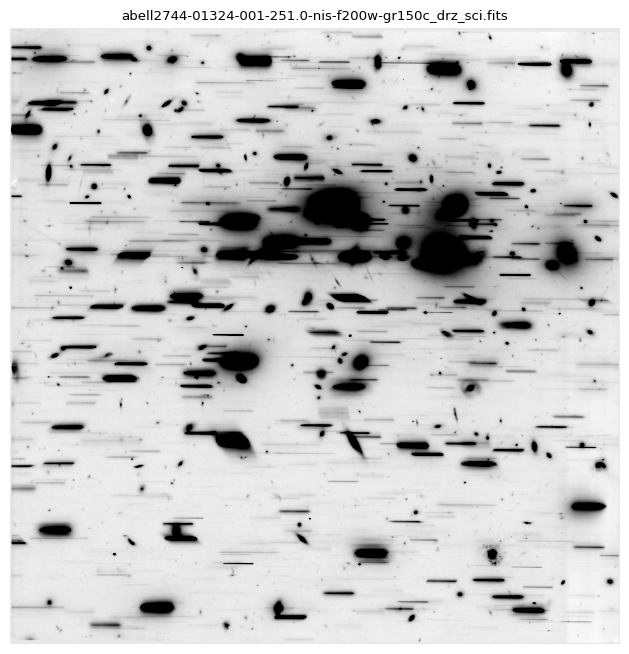

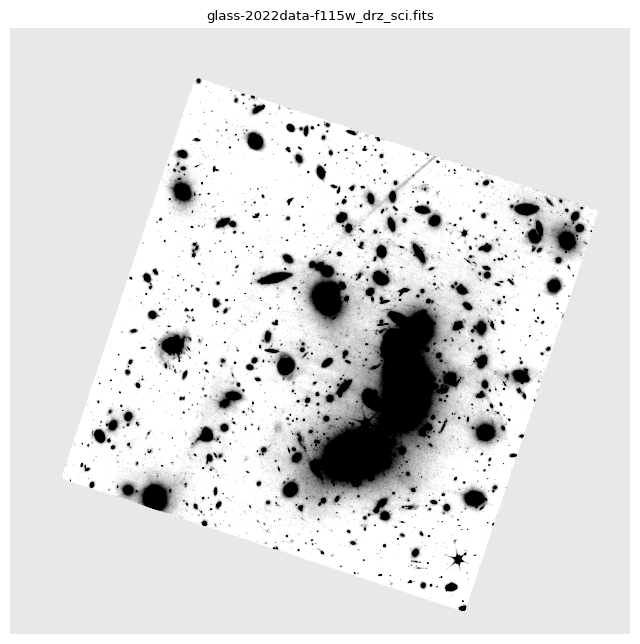

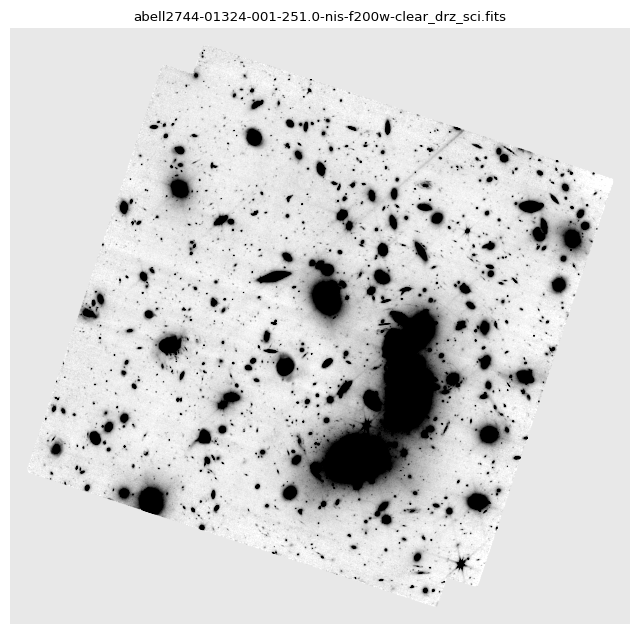

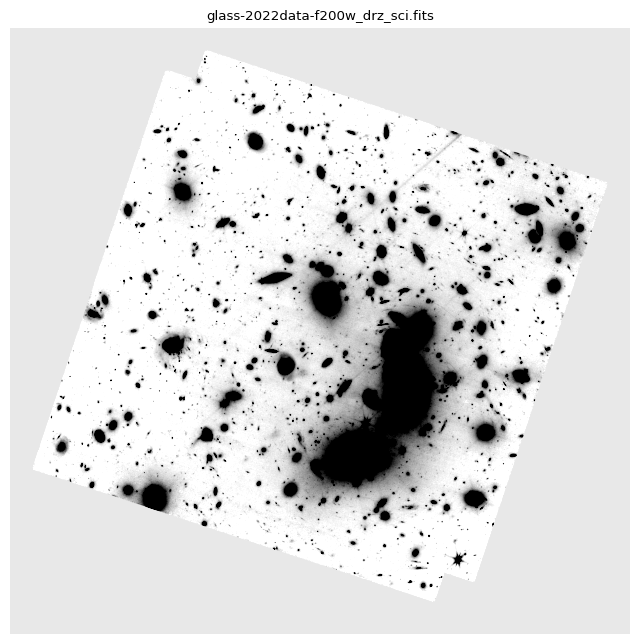

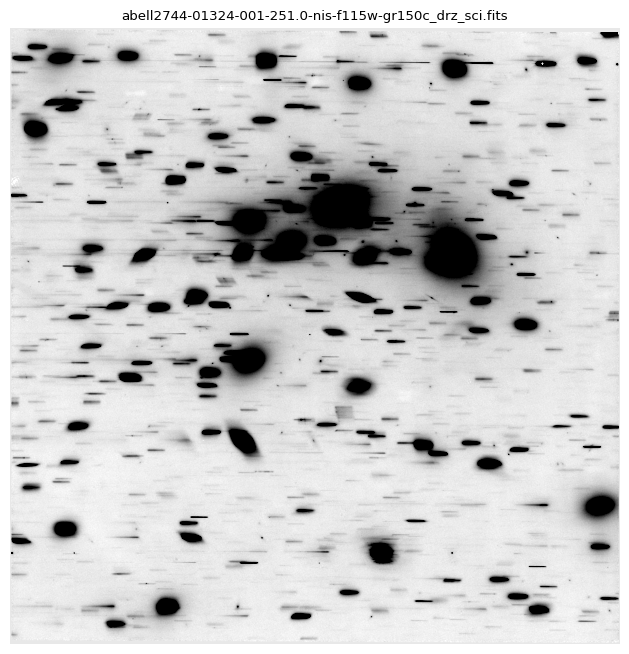

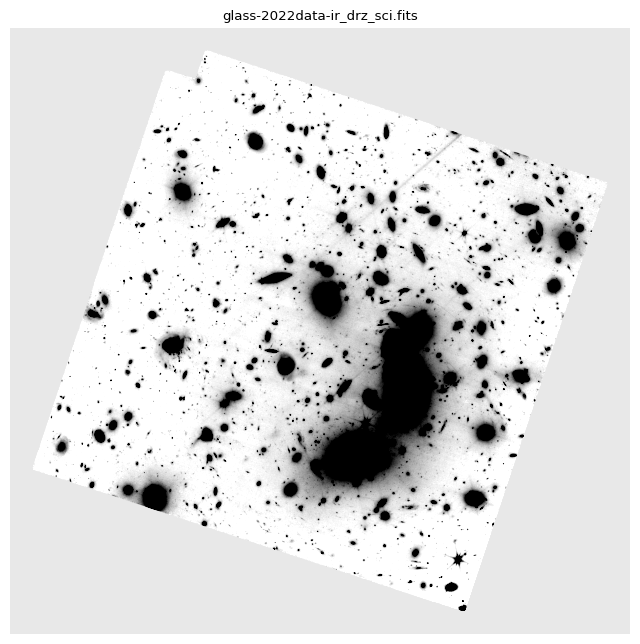

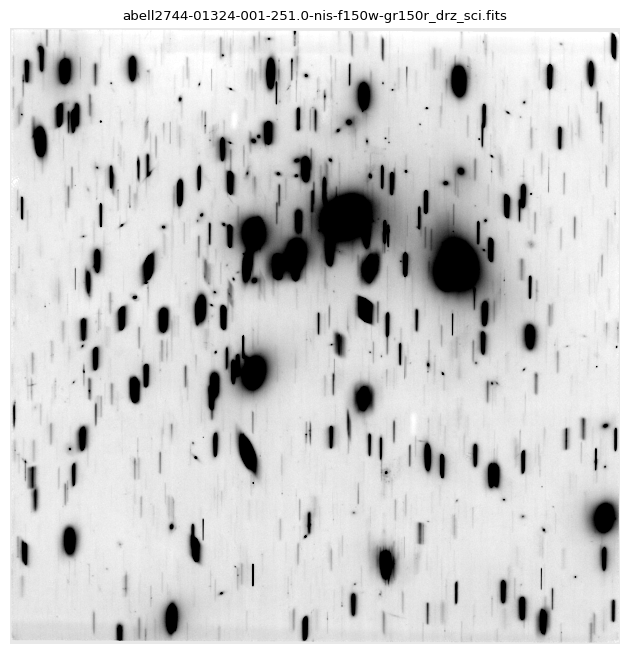

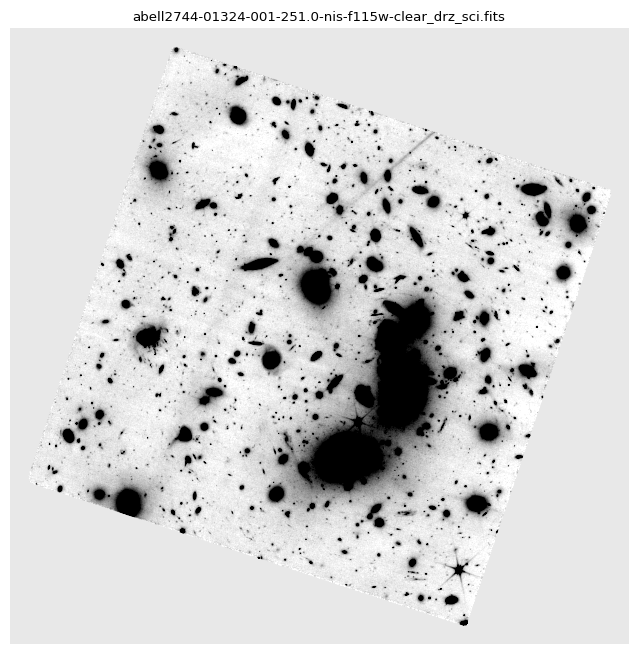

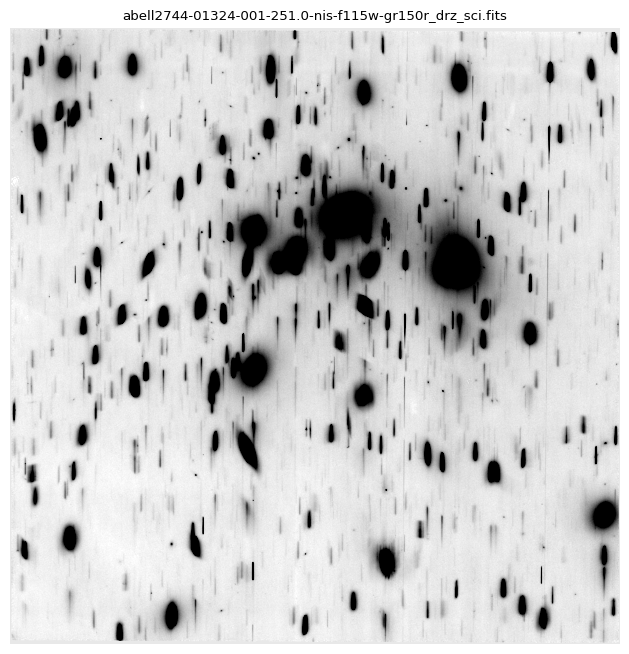

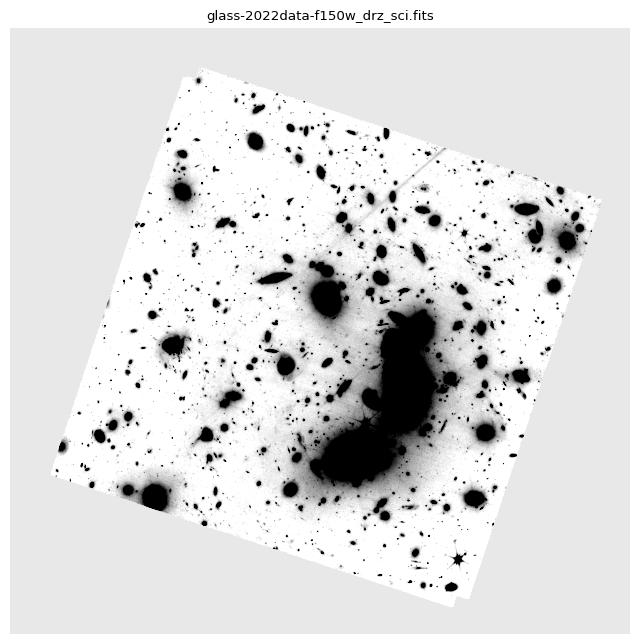

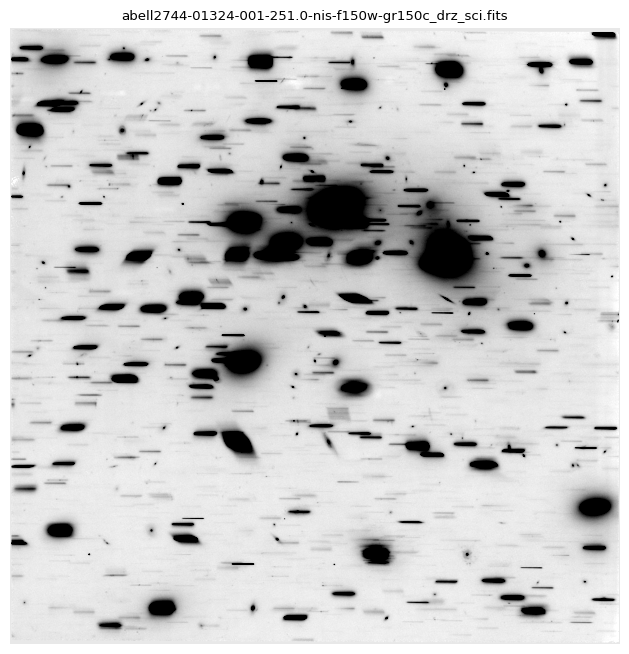

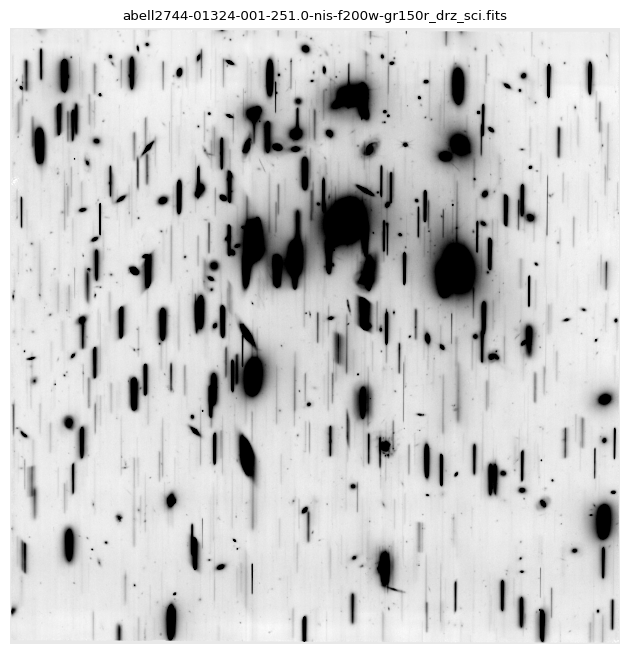

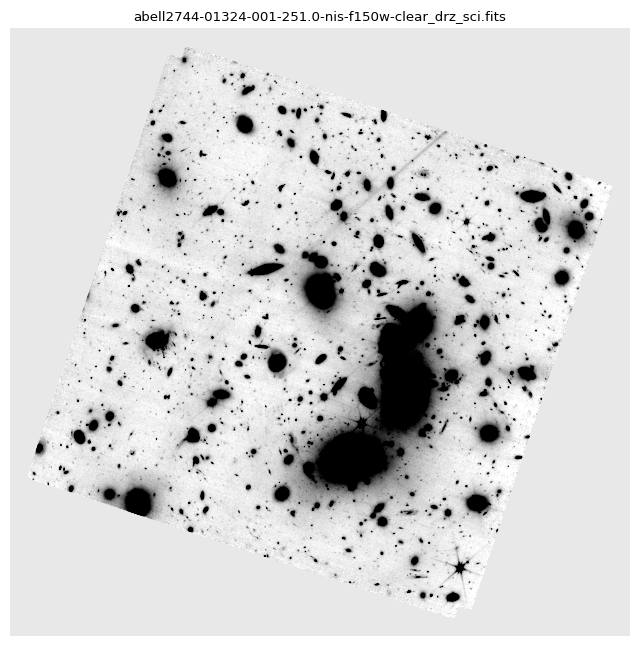

In [18]:
import matplotlib.pyplot as plt

files = glob.glob('*sci.fits')
for file in files:
    im = pyfits.open(file)
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    vm = np.nanpercentile(im[0].data, [5, 95])
    ax.imshow(im[0].data, vmin=-0.1*vm[1], vmax=vm[1], cmap='gray_r', origin='lower')
    ax.set_aspect(1)
    ax.set_title(file)
    ax.axis('off')